# Uncertainty, Statistics, and Reproducibility

<h1>Uncertainty, Statistics, and Reproducibility</h1>

<p>
<b>Quantitative Big Imaging - ETHZ: 227-0966-00L</b>
<br />

<div class='row'>
    <div class='column23'>
        <p style="font-size:1em;">April 10, 2025</p>
        <br /><br />
        <p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
        <p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>
    </div>
    <div class='column13'>
        <img src="../../docs/figures/np_statistics_4108630_000000.svg" style="height:300px" />
    </div>
</div> 

## Let's load some modules

In [1]:
%load_ext autoreload
%reload_ext autoreload
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import skimage.filters as flt
import pandas as pd
import matplotlib.patches as patches
import tifffile as tiff
from lecture8_support import *
import confmap as cm
import sys
sys.path.append('../common/')
import plotsupport as ps
import pointcloud as pc
from IPython.display import Markdown, display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # This is get sharper plots on digh density screens like the Retina screen on Macs

## Literature / Useful References

### Books
- Julien Claude, [_Morphometry with R_](http://link.springer.com/book/10.1007%2F978-0-387-77789-4), __Chapter 3__ 
- John C. Russ, [_The Image Processing Handbook_](http://dx.doi.org/10.1201/9780203881095),(Boca Raton, CRC Press)
- Gregory J. Privitera, _Statistics for the Behavioral Sciences_ [__Chapter 8__](http://www.sagepub.com/upm-data/40007_Chapter8.pdf)
- Drosg, 2009, ["Dealing with uncertainties"](https://doi.org/0.1007/978-3-642-01384-3), Springer Verlag  
- M. Grabe, 2014,["Measurement Uncertainties in Science and Technology"](https://doi.org/10.1007/978-3-319-04888-8), Springer Verlag  
- Ch. Gillmann, 2018,["Image processing under uncertainty"](https://kluedo.ub.rptu.de/frontdoor/deliver/index/docId/5470/file/Dissertation_Christina_Gillmann.pdf), PhD Thesis, Uni Kaiserslautern
- Leland and Wilkinson, [_Grammar of Graphics_](http://www.springer.com/gp/book/9780387245447)

### Papers / Sites
- [Databases Introduction](http://swcarpentry.github.io/sql-novice-survey/)
- [Measurement errors - European Commission Glossary](https://cros-legacy.ec.europa.eu/content/measurement-error_en)
- [Detection limit - Wikipedia](https://en.wikipedia.org/wiki/Detection_limit)  
- [Error propagation](https://www.webassign.net/question_assets/unccolphysmechl1/measurements/manual.html)  
- [Error bands - Stack exchange](https://physics.stackexchange.com/questions/496841/what-should-be-the-real-error-band-of-a-fit-function)
- [Visualizing Genomic Data](http://circos.ca/documentation/course/visualizing-genomic-data.pdf) (General Visualization Techniques)
- [NIMRod Parameter Studies](http://www.messagelab.monash.edu.au/nimrod)

- M.E. Wolak, D.J. Fairbairn, Y.R. Paulsen (2012) Guidelines for Estimating Repeatability. Methods in Ecology and Evolution 3(1):129-137.
- David J.C. MacKay, [Bayesian Interpolation](http://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.27.9072) (1991) 

### Videos / Podcasts
- [Google/Stanford Statistics Intro](https://www.youtube.com/watch?v=YFC2KUmEebc)
- [Last Week Tonight with John Oliver: Scientific Studies](https://www.youtube.com/watch?v=0Rnq1NpHdmw)
- [Credibility Crisis](https://www.datacamp.com/community/podcast/credibility-crisis-in-data-science)
- [Veritasium: Is Most Published Research Wrong?](https://youtu.be/42QuXLucH3Q)
- [Stand-up maths: The Minecraft boat-drop mystery](https://youtu.be/ei58gGM9Z8k?si=xw9V4w2tEIRypQLR)

### Further material
#### Slides
- Kieran Healy, [Data Visualization - A practical introduction](https://socviz.co/lookatdata.html)
- [P-Values with Puppies](https://hackernoon.com/explaining-p-values-with-puppies-af63d68005d0)


## Previously on QBI ...
  
<br> 
<img src="figures/08-all_icons-statistics.svg" style="height:300px" />


- Image Enhancement 
 - Highlighting the contrast of interest in images
 - Minimizing Noise
- Understanding image histograms
- Automatic Methods
- Component Labeling
- Single Shape Analysis
- Complicated Shapes

## Today's outline

- Motivation (Why and How?)
- Scientific Goals
- Uncertainties
- Statistical metrics and results
- Reproducibility
- Parameterization
    - Parameter sweep
    - Sensitivity analysis
- Visualization

## Quantitative "Big" Imaging


The course has covered imaging enough and there have been a few quantitative metrics, 

...but "big" has not really mentioned!

So, what does __big__ mean?

- Not just / even large
- it means being ready for _big data_
    - The three V's: __V__ olume, __V__ elocity, __V__ ariety
    - scalable, fast, easy to customize


So what is "big" imaging?

The three V's are one by themselves maybe not really producing big data. The data does, however, grow radically when you combine them. Tomography produce large images. Then we may want to study the sample over time to observe changes in the behaviour, the processes may even be rapid and require many sampling points to follow the process. This was only for a single sample, now we need variation to make a statistically solid conclusion from the measurement (today's lecture). 

Still, filling hard drives with data is only one part of big. You also need a strategy to manage, process, and anlyze the data in a reproducible manner. The readiness to handle large amonts of data is what really matters. 

## Objectives

Scientific Studies all try to get to a single or few numbers  
- Make sure this number is describing the structure well (earlier lectures)
- Making sure the number is meaningful (__today!__)  
 
How do we:
1. Compare the number from different samples and groups?  
     - Within a sample or same type of samples
     - Between samples
2. Compare different processing steps like filter choice, minimum volume, resolution, etc?  
3. Evaluate our parameter selection?  
4. _Ensure our techniques do what they are supposed to do?_
5. _Visualize so much data? Are there rules?_

## What do we start with?

Going back to our original cell image

<div class="row">
<div class="column23">

1. We have been able to 
    - __get rid of the noise__ in the image and 
    - __find all the cells__ (lecture 2-4)  

1. We have __analyzed the shape__ of the cells (lecture 5)  

1. We even __separated cells joined together__ using Watershed (lecture 6)  

1. We have created even more __metrics characterizing the distribution__ (lecture 7)

We have at least a few samples (or different regions), 
- large number of metrics and 
- and almost as large number of parameters to _tune_

__How do we do something meaningful with it?__
    
</div>
<div class="column13">
    <img src="figures/FIBSLICE0035_left_top.png" style="height:300px">
</div></div>
    

# Correlation and Causation


One of the most repeated criticisms of scientific work is that correlation and causation are confused. 

<div class="row">
<div class="column25">
        
__Correlation__  
    
<center><img src="figures/np_scatterplot_206502_000000.svg" style="height:150px"/></center>
    
 - means a statistical relationship
 - very easy to show (single calculation)
        
</div>
<div class="column35">
         
__Causation__  
    
<center><img src="figures/np_domino-effect_2020716_000000.svg" style="height:150px"/></center>      
    
 - implies there is a mechanism between A and B
 - can be very difficult to show (impossible to prove)
         
</div>
</div>

## Observational or Controlled

There are two broad classes of data and scientific studies. 

- Observational 
- Controlled

Each type appears, but it is more likely to perform observational studies in the early stages of a project to gain an overview of the working field. From this study it you will make observations for more detailed studies which then are controlled.

<div class="row">
<div class="column">
<center>
    
<h2>Observational</h2>  
    
<img src="figures/np_museum-visit_68542_000000.svg" style="height:400px"/>
</center>              
</div>
<div class="column">
<center>
    
<h2>Controlled</h2>
    
<img src="figures/np_puppet_57357_000000.svg" style="height:400px"/>
</center>      
</div>
</div>



```{figure} figures/noun_MuseumVisit.pdf
---
scale: 50%
name: fig_observer
---
In observational experiments you stand back and only observe what is happening.
```

```{figure} figures/noun_puppet.pdf
---
scale: 50%
name: fig_controller
---
In controlled experiments you prepare the samples for a specific purpose and control the environment.
```

### Observational

In observational experiments you are not interfering with the observed phenomenon. You only make a selection of specimens or individuals that will be measured as they appear.

<div class="row">
<div class="column45">    
    
__Exploring large datasets looking for trends__
 - Population is random
 - Not always hypothesis driven
 - Rarely leads to causation


#### Examples of observational experiments
- We examined 100 people 
    - the ones with blue eyes were on average 10cm taller
    
- In 100 cake samples
    - we found a 0.9 correlation between baking time and bubble size
    
</div>
<div class="column15">
<img src="figures/np_museum-visit_68542_000000.svg" style="height:400px"/>    
</div>
</div>    

### Controlled

The controlled experiments are designed to explore specific aspects of a population or phenomenon. To achieve this, you want to introduce differences between different groups and keep one as reference. The reference group can be the unmodified samples or samples prepared with an wellknown process.

<div class="row">
<div class="column45">    
    
__Most scientific studies fall into this category__
 - Specifics of the groups are controlled
 - Can lead to causation

#### Examples of controlled experiments
- We examined 50 mice with gene XYZ off and 50 gene XYZ on  
_as the foot size increased by 10%_
    
- We increased the temperature  
    _and the number of pores in the metal increased by 10%_
 
</div>
<div class="column15">
<img src="figures/np_puppet_57357_000000.svg" style="height:600px"/>    
</div>
</div> 

# Qualitative vs Quantitative
_From lecture 1_

<div class="row">
  <div class="column">
      <center>
      <img src="../Lecture-01/figures/GoldPendant.png" style="height:500px"/>
      </center>
  </div>
  <div class="column">
      <center>
        <img src="../Lecture-01/figures/NailHistogram.png" style="height:500px"/>
          </center>
  </div>
</div>

## Qualitative Assessment

<div class="row">
    <div class="column">

- Evaluating metrics using visual feedback
- Compare with expectations from  
    - other independent techniques 
    - or approach
- Are there artifacts which are included in the output?
- Do the shapes look correct?
- Are they distributed as expected?
- Is their orientation meaningful?

</div>
<div class="column">
        
<img src="figures/poros.png" style="width:800px" />
        
</div></div>

## Quantitative Metrics


With a quantitative approach, we can calculate 
- the specific shape 
- or distribution metrics on the sample 

with each parameter and establish the relationship between 
- parameter 
- and metric. 

This information will be used in our investigation to tell something about the sample condition allowing us to making conclusions in our investigation. 

# Handling uncertainties in image processing

## Why do we need to talk about the uncertain?

<div class="row">
<div class="column23">

> “Scientific knowledge is a body of statements of varying degree of certainty  
> – some most unsure, some nearly sure, but none absolutely certain.”    
>
>As found in Feynman, RP (1997) Surely You Are Joking, Mr. Feynman, Norton, New York.
  
</div>
<div class="column13">
<img src="figures/feynman01-NEWS-WEB.width-450_3YN6pEE.jpg" style="height:400px">
Credit: Caltech Archives
</div></div>    

There is no measurement that doesn't have an uncertainty. The question how we use this information in our analysis.

## What we want

<div class='row'>
<div class='column23'>
        
Error bars beyond the confidence interval of the noise
    
- Each measurement has an uncertainty
- Uncertainty propagation in image processing is non-trivial

</div>  
<div class='column13'>
<img src="figures/xkcd_errorbars.png" style="width:500px">

[xkcd - 2110](https://xkcd.com/2110/)
        
</div>
</div>

Imaging and image processing are no exception to the fact that there uncertainties related the all measurement. The problem is that there is a chain of uncertainties to consider in the uncertainty analysis. Knowing each is a non-trivial task. In the following sections, you will see some examples of uncertainty analysis.

## Error or uncertainty?

<div class="row">
<div class="column">

### Error
The difference between measured value $c'$  
    and true value $c^*$
    
$$e = |c'-c^*| $$
    
You need a ground truth!
</div>
<div class="column">
         
    
### Uncertainty
    
The quantification of the doubt about the measurement result. 
    
$$u_{range}= [c' - u, c' + u ]$$
    
    
</div></div>
<br/>
<center>
<img src="figures/error-uncertain.png" style="width:600px" />
</center>
    
    
[Ch. Gillmann, 2018](https://kluedo.ub.rptu.de/frontdoor/deliver/index/docId/5470/file/Dissertation_Christina_Gillmann.pdf)

We often (sloppily) talk about measurement errors, but it is mostly the uncertainty we mean. The error needs the ground truth to be determined. 

The uncertainty is an interval around the measured value, like the confidence interval, in which the true value is included.

## Which uncertainties are we dealing with?

<div class="row">
<div class="column">

### Technical uncertainties
- Metric
- SNR
- Unsharpness
- Effects from image processing
- Numerical errors 
    
</div>
<div class="column">    

### Field specific uncertainties
- Model simplifications
- Variations in population
- Noise

</div>
</div>  

## Uncertainty categories

<div class="row">
<div class="column">

### Systematic
Reproducible - no statistical analysis
- Rounding errors 
- Uncalibrated systems
- Algorithmic choices
- Etc.

</div>    
<div class="column">  
    
### Random
Statistical fluctuations
- Natural variations in studied population
- Source fluctuations
- Detector noise
    
</div></div>

## Target practicing

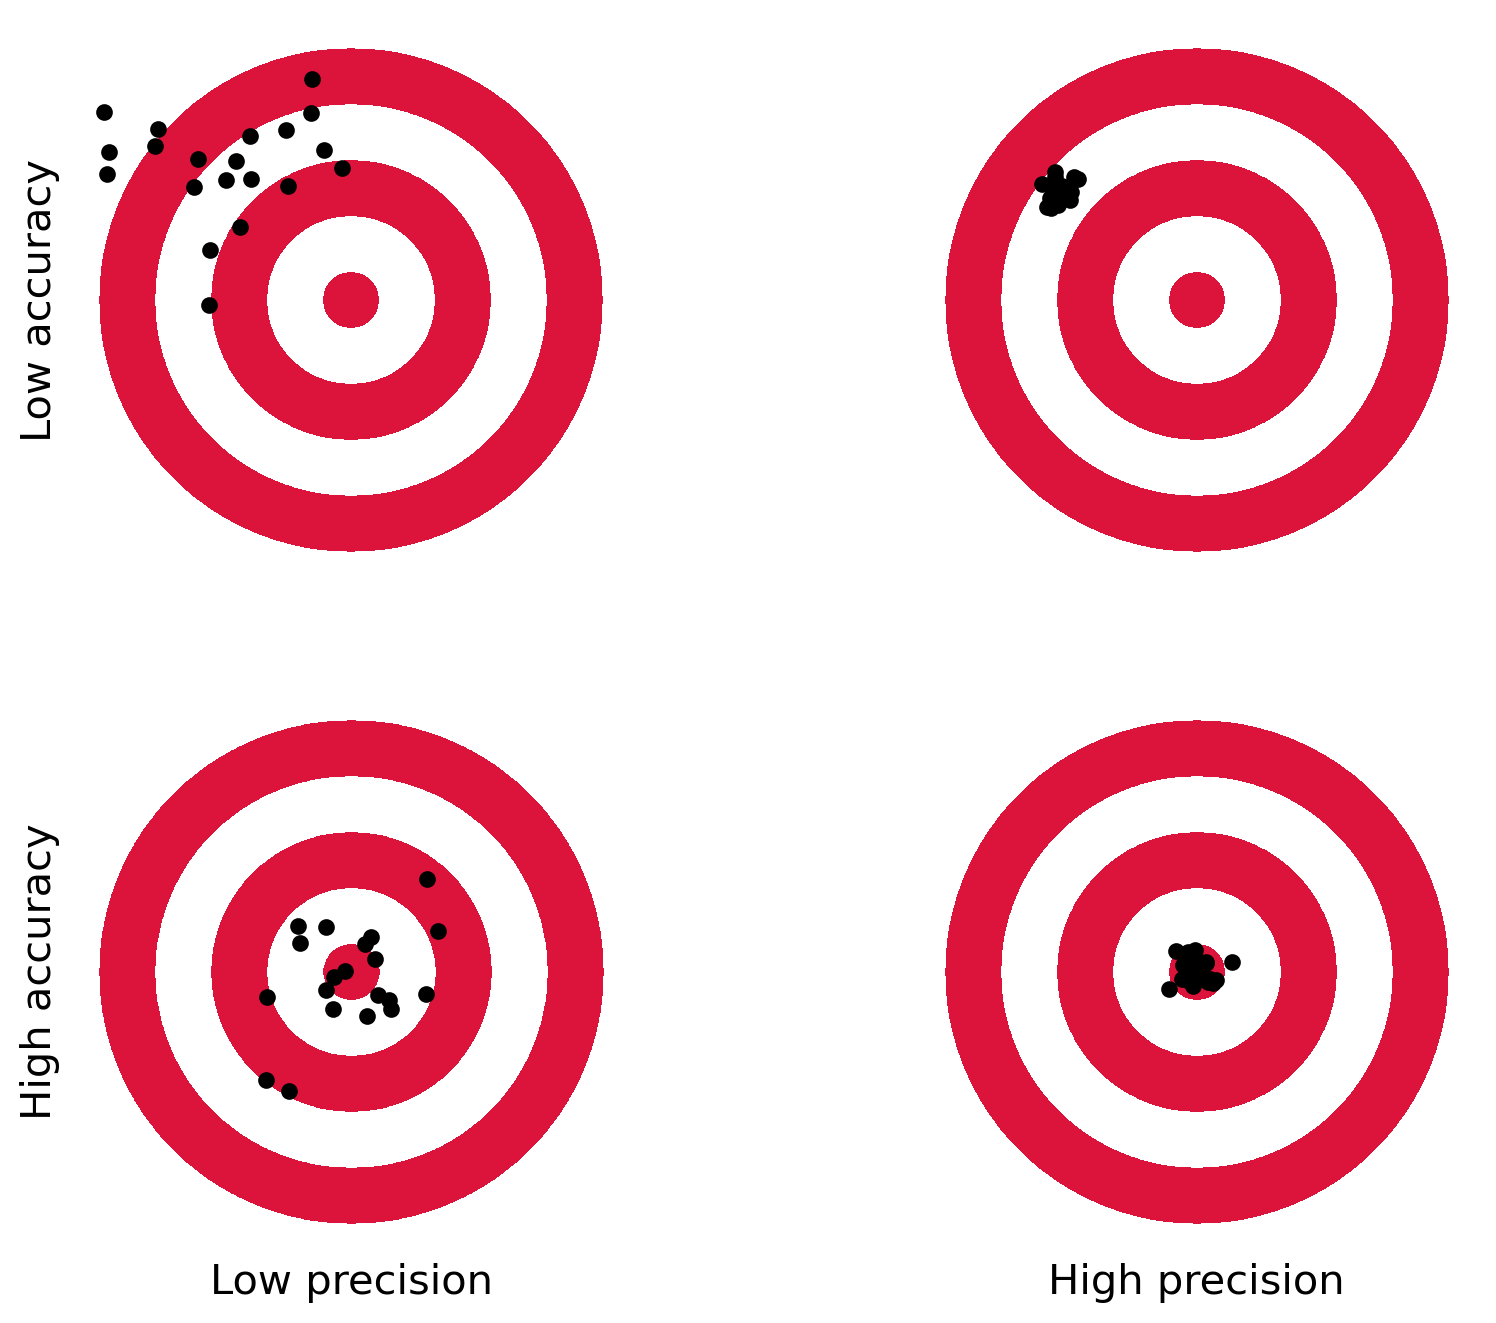

In [2]:
precacc(1000)

The uncertainty has two components precision and accuracy. The accuracy tells how far away our measurement is from the expected true value. The precision tell how widespread the measurements are. 

### Target practicing in statistical terms

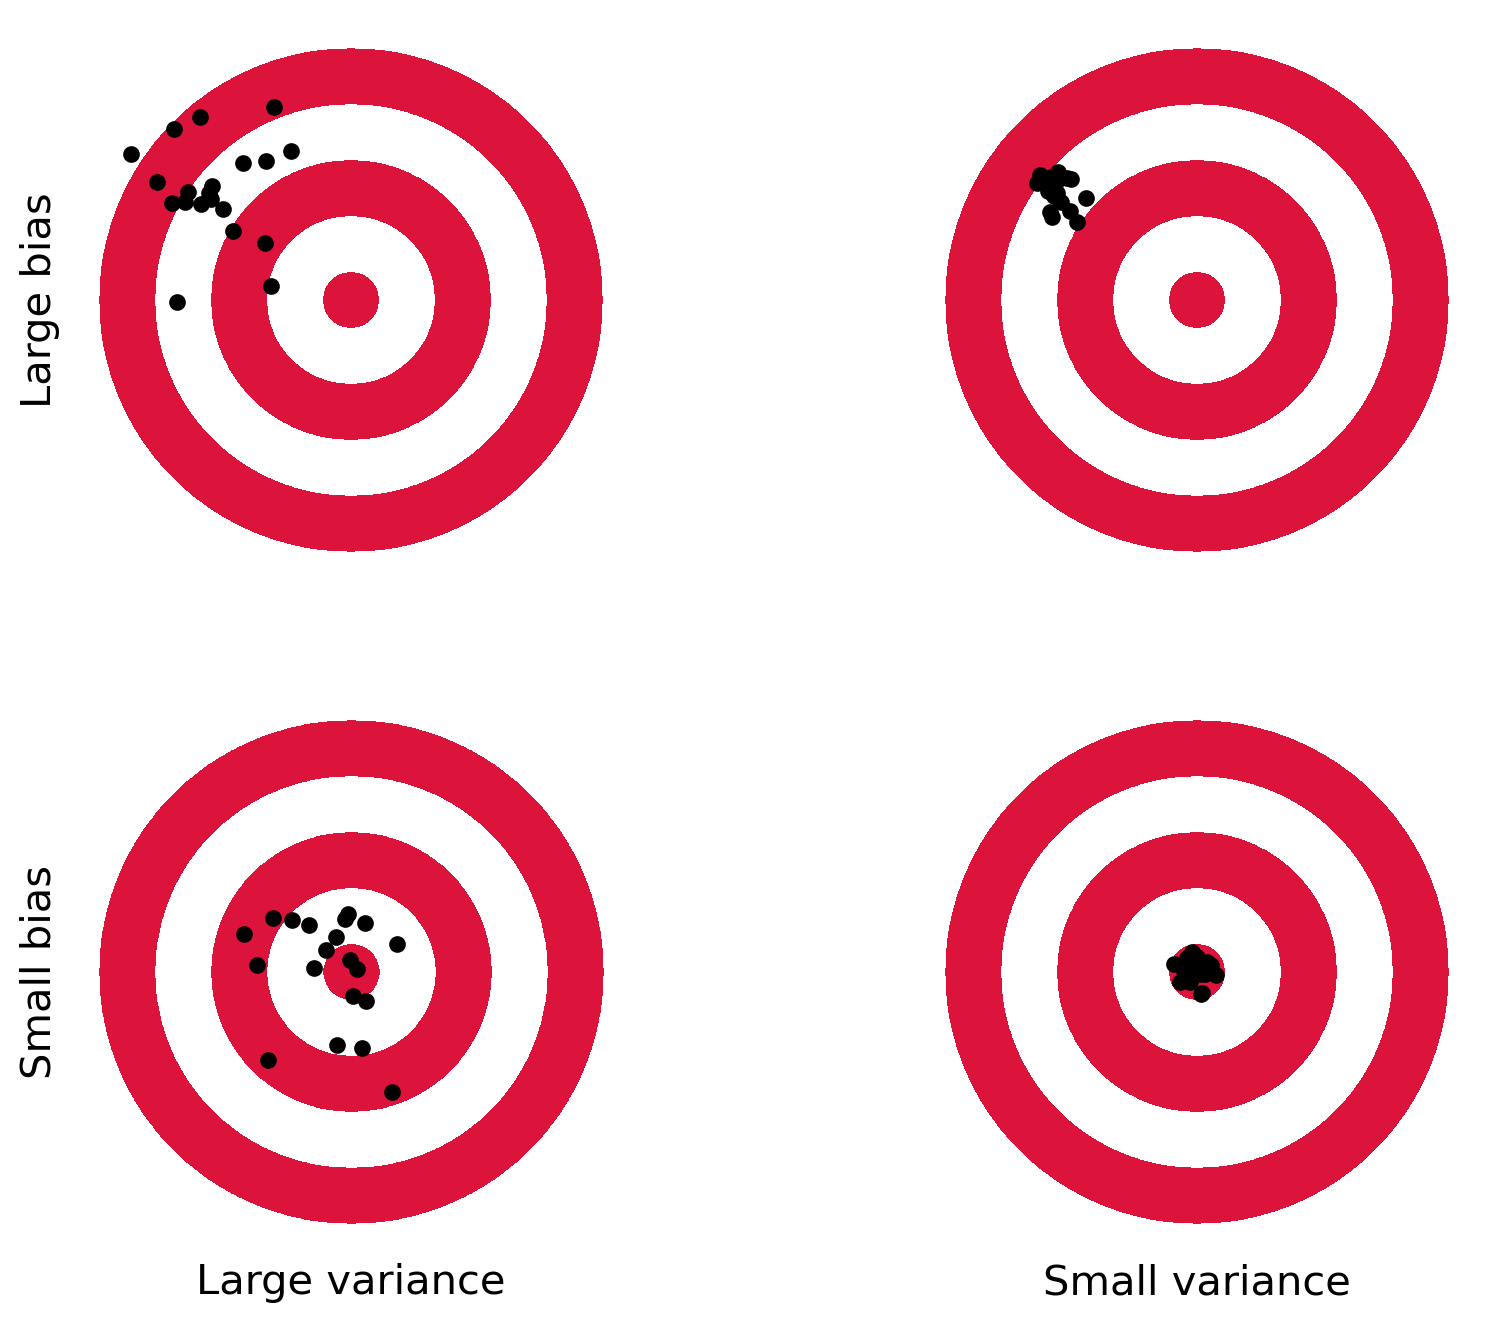

In [3]:
precacc(1000,['Large bias','Small bias','Large variance','Small variance'])

Precision and accuracy can be translated in statistical terms such that 
- The precicion corresponds to the variance of the measured values, i.e. high precision means that the variance if low. 
- The accuracy is translated to a bias in the measurement, i.e. low accuracy means that the bias is great. 

## Counting or measuring

We always have uncertainties in our measurements. Some, more obvious than others. Here, we will look into the two cases counting and measuring.

### Counting    
- Discrete countable items
- Absolute values
    
Uncertainties: from preparation  

_Example:_ area of segmented region
        
<center><img src="figures/np_counting.png" style="height:300px"/></center>    


The smallest countable item in an image is the pixel. The area is determined as the sum of the pixels in a specified region. Some perimeter metrics are based on counting the boundary pixels.

Counting seems like an absolute task, just count labelled regions and tell how many there are. The uncertainties originate from the image preparation leading to the regions:

1. Does image noise affect the number of detected items?
2. How well was the image segmented? How many misclassified pixels are there?


### Measuring
- Physical quantities
- Values with uncertainties

Uncertainties: Noise, instrumentation  

_Example:_ mixing ratios from gray levels

<center><img src="figures/np_measure.png" style="height:250px"/></center>      


In some experiments we observe changes in the gray levels. The gray level has several sources of uncertainty
- The conversion from measured radiation to a signal that can be measured by the detector
- The quantization. How many levels were used in the acquisition.
- Noise
    - counting noise from the radiation
    - detector noise
    - quantization noise
- Algorithmic uncertainty. The reconstruction may be biased.


## Absolute vs relative uncertainties
Uncertainties must be compared from a neutral perspective

<div class="row">
    <div class="column">

### Absolute uncertainty
Assume we can measure a distance with an uncertainty of 1mm
> Distance to the moon - 384400km

> The diameter of a coin - 20mm

</div>        
<div class="column">        
        
### Relative uncertainty
Relates the error to the measured quantity
    
> Distance to the moon - 0.000000002601457

> Diameter of a coin - 0.05
    
</div></div>

## Propagation of uncertainty


### Uncertainty of f(x)

$$\sigma_f(x) = \frac{\partial f}{\partial x}\cdot \sigma_{x}$$        
               
        
### Uncertainty of f(x,y)

$$\sigma_f(x,y)^2 = \left(\frac{\partial f}{\partial x}\cdot \sigma_{x}\right)^2 + \left(\frac{\partial f}{\partial y}\cdot \sigma_{y}\right)^2 + \underbrace{\frac{\partial f}{\partial x}\cdot\frac{\partial f}{\partial y}\cdot\overline{\sigma_{xy}}}_{\mbox{x and y uncorrelated?}}$$        


## Uncertain quantities in imaging experiments

- Pixel size
- Segmentation
- Sampling time stamps in time series
- Intensity levels

![](figures/Uncertainties.png)

### Three examples

We want to measure:

<div class="row">
<div class="column13">
       
The pixel size
        
<center><img src="figures/np_caliper_5858067_000000.svg" style="height:200px"/></center>
</div>
<div class="column13">
       
The perimeter length
        
<center><img src="figures/np_head-circumference_6420647_000000.svg" style="height:200px" /></center>
</div>
<div class="column13">
       
Water volume behind a pixel
        
<center><img src="figures/np_bucket_681234_000000.svg" style="height:120px"/></center>
</div>
</div>

### Example: measure the pixel size
To measure pixel size we need:
- An object with known length
- An image of the object

$$\mbox{pixel size}=\frac{\mbox{Object length}}{\mbox{Pixel distance between edges}}$$

#### Uncertainty equation
We assume that the two measured values are uncorrelated
$$\frac{\sigma_{a/b}}{a/b}=\sqrt{\left(\frac{\sigma_a}{a}\right)^2 + \left(\frac{\sigma_b}{b}\right)^2}$$

[From this tutorial](https://www.webassign.net/question_assets/unccolphysmechl1/measurements/manual.html)

#### Our measurements

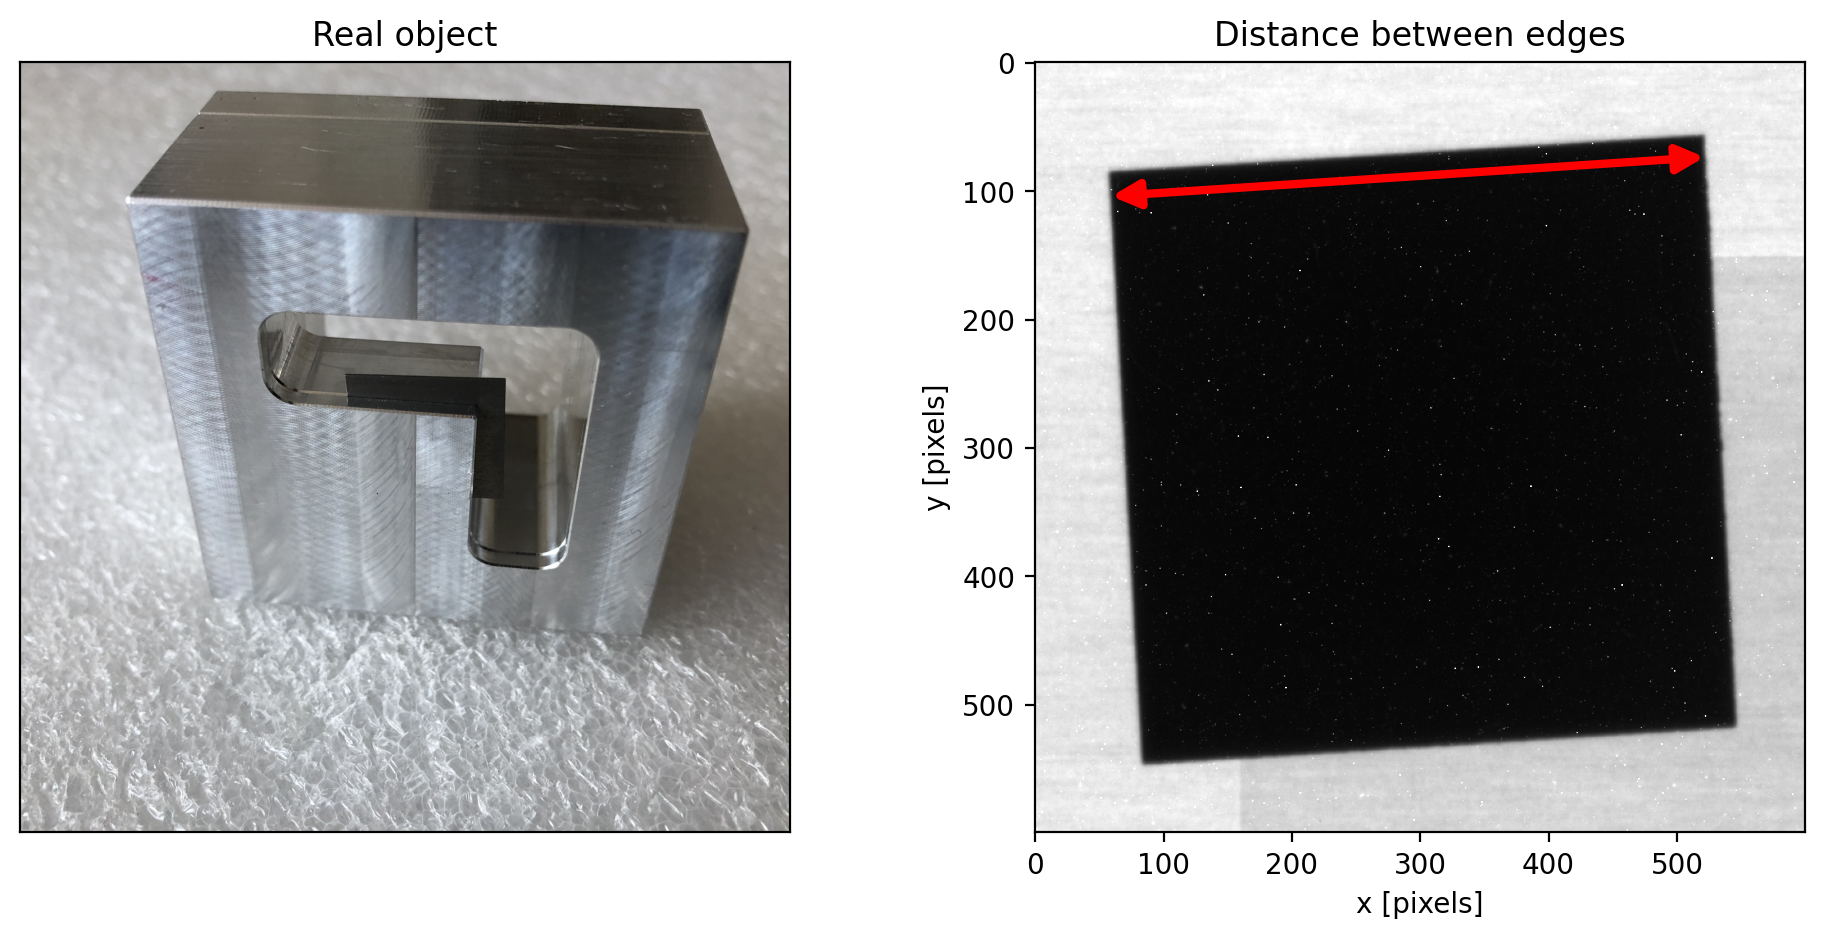

In [4]:
img1 = tiff.imread('data/edge20mm_0000.tif')
pic = plt.imread('figures/edge_object.jpg')
fig,ax=plt.subplots(1,2,figsize=(12,5))

ax[0].imshow(pic)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Real object')

ax[1].imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax[1].set_xlabel('x [pixels]')
ax[1].set_ylabel('y [pixels]');
arrow = patches.FancyArrowPatch((55,104), (526, 73),
                                 mutation_scale=20,
                                 #ec='blue',fc='cornflowerblue',
                                 color='red',
                                 arrowstyle='<|-|>',linewidth=3
                                )
ax[1].add_patch(arrow);
#ax.annotate(text='', xy=(54,104), xytext=(527,71), arrowprops=dict(arrowstyle='<->',color='yellow',lw=4))
d=np.sqrt((528-53)**2+(104-73)**2)
ax[1].set_title('Distance between edges');


| Quantity  | Measurement | Uncertainty   | Unit |
|:---|---:|---:|---|
| Caliper distance  | 20.0 | 0.05 | mm |
| Pixel distance    | 464.9  | 0.32  | pixels |


[A tutorial showing the detailed analysis](https://colab.research.google.com/github/ImagingELearning/resolution/blob/main/tutorials/02_PixelSize/02_PixelSize.ipynb)

#### Pixel size with uncertainty
We know uncertainty equation for $a/b$. 

Let's plug in the pixel meassurements:

$$\frac{\sigma_{Pixelsize}}{Pixelsize}=\sqrt{\biggl({\frac{\sigma_{pixels}}{pixels} }\biggr)^2+ \biggl({\frac{\sigma_{length}}{length}}\biggr)^2}$$

In [5]:
length       = 20.0 # mm
error_length = 0.05 # mm
pixels       = 464.9 # pixels
error_pixels = 0.32  # pixels

pixel_size = length/pixels

rel_uncertainty = np.sqrt((error_pixels/pixels)**2 + (error_length/length)**2)

display(Markdown('<span style="font-size:1.75em"> Pixel size = {0:0.2f} $\mu$m +/- {1:0.2f}$\mu$m</span>'.format(pixel_size*1000,pixel_size*rel_uncertainty*1000)))

<span style="font-size:1.75em"> Pixel size = 43.02 $\mu$m +/- 0.11$\mu$m</span>

#### The uncertainties package
Uncertainties can be tricky to compute. The [uncertainties package](https://uncertainties.readthedocs.io/en/latest/) takes some of this burden from you

In [6]:
from uncertainties import ufloat

length = ufloat(20.0,0.05)
pixels = ufloat(464.9,0.32)

pixel_size = length/pixels

print(pixel_size)

0.04302+/-0.00011


### Measurements in segmented images

In lecture 5 we learned to measure

- Area 
- Perimeter 
- Positions 
- Distances

Considering them to be absolute values as we mostly just count pixels...

_Let's see how the uncertainty of the pixel size among others changes this_ 



### Meassure the perimeter length

The perimeter length has three sources of uncertainty:
- How were the edge pixels identified?
    _Method choices can introduce biases_
- The pixel size... 

and...

- How well was the image segmented?  
    _Edges are segmented with least confidence_

#### Selecting edge pixels

A method to identify edge pixels is 
$$edge(f) = f - \varepsilon_{SE}(f)$$
which pixels depends on the used SE.


<center>
<img src="figures/edge_detail.png" style="width:250px"/>
</center>

#### Counting perimeter elements

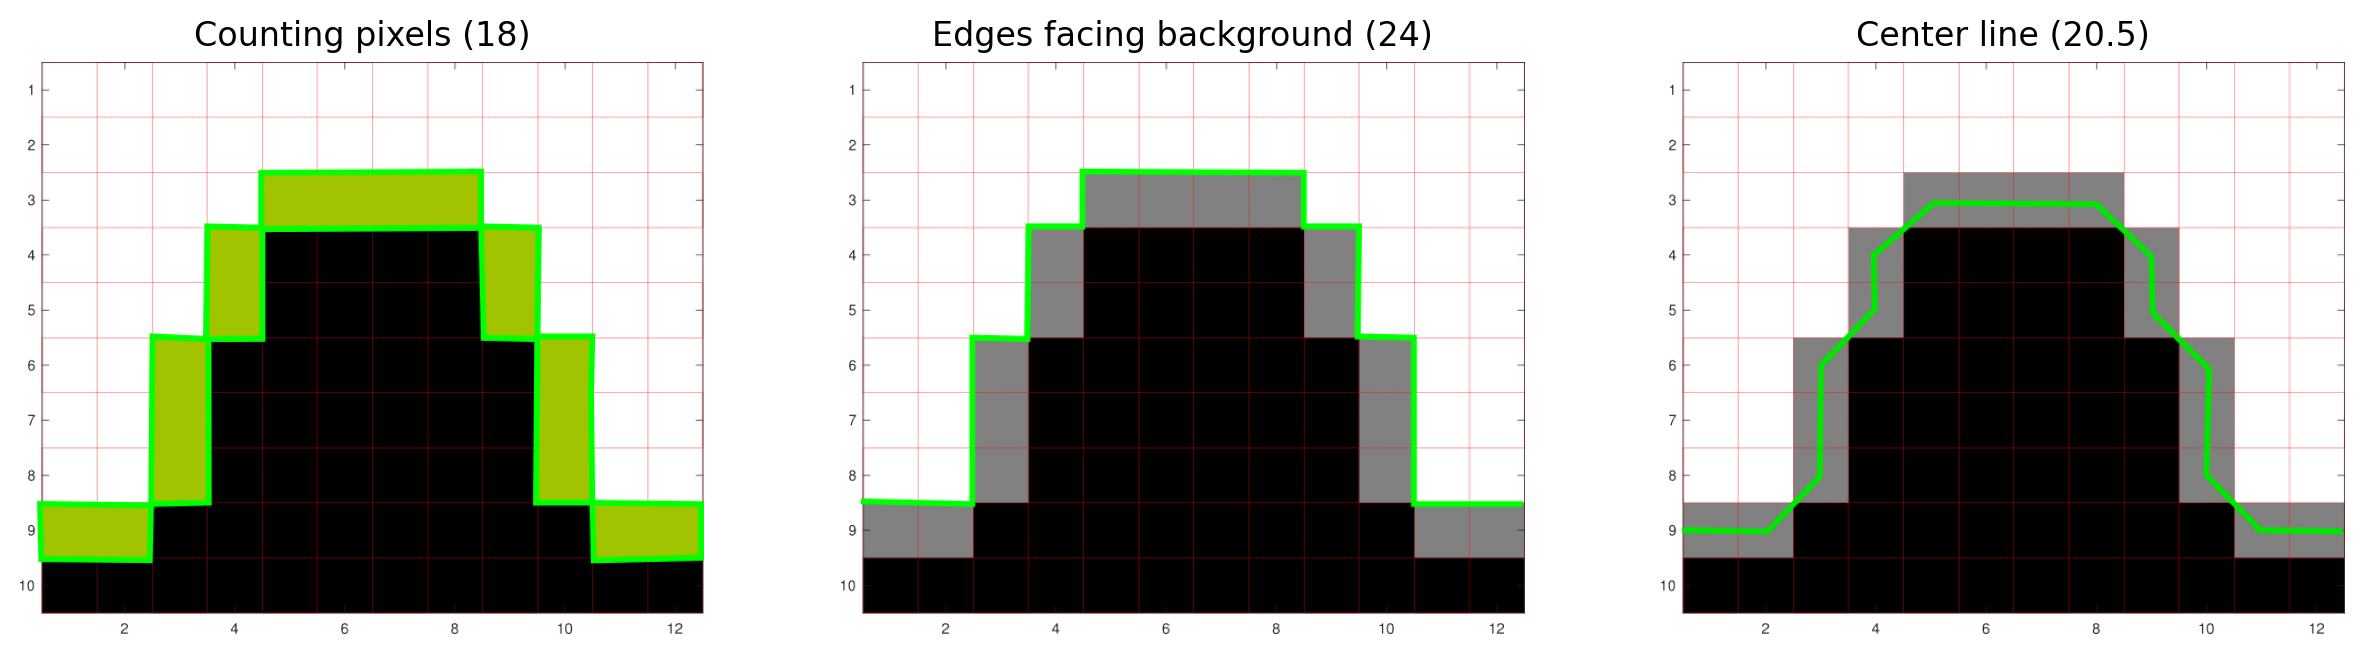

In [7]:
imgs=[plt.imread('figures/edge_detail_pixel_count.png'), 
      plt.imread('figures/edge_detail_outline.png'), 
      plt.imread('figures/edge_detail_centerline.png')]
lbls=['Counting pixels (18)', 'Edges facing background (24)','Center line (20.5)']

_,axs = plt.subplots(1,3, figsize=(15,6))
for ax,img,lbl in zip(axs,imgs,lbls) :
    ax.imshow(img)
    ax.set_title(lbl)
    ax.axis('off')

#### Perimeter length with uncertainty

Let's assume we can trust the segmentation:
- Edge is 18 pixels long
- The pixel size is 43.02 $\mu$m $\pm$  0.11$\mu$m

##### Perimeter uncertainty equation
In this case we sum the edge pixels 

_Derivation of the equation_

The uncertainty of a sum of measurements $\sum^N_{i=1}x_i$ each with all $x_i$ uncorrelated and the same uncertainty $\sigma_x$. 

Lets start with the derivative:
$\frac{\partial f}{\partial x_i}=1\quad \forall i$

now the uncertainty is the sum of all $x_i$  

${\sigma_{\sum x_i}} = \sum_{i=1}^N {\sigma_x} = N {\sigma_x}$

which leads to 

$$\sigma_{\sum x_i} = \sigma_x \cdot N$$

We have $\sigma_{Pixelsize} = 0.11\,\mu{}m$, which gives $\sigma_{Edgelength} = 0.11 \cdot 18=1.98 \mu{}m$

The edge length is 774 $\pm$ 2.0 $\mu{}m$

### Measure water volume from gray levels
In neutron imaging it is common to quantify the water content from radiographs.

<div class="row">
<div class="column23">
    


- The transmission (gray level) is $T=\frac{I}{I_0}=e^{-\mu \cdot d}$
    
- The metric pixel area (pixel size)

    
The water volume is $V_{water}=pixelsize^2 \cdot d$
    
    
    
Our uncertainties are now:
- Standard deviation of the transmission (confidence interval)
- The pixel size ... again
    


</div>
<div class="column13">
    
![](figures/pixel_volume.png)    
    
</div></div>   

# Volume with uncertainty

Let's assume we can trust the segmentation:
- Thickness $d=5\pm0.1~mm$
- The pixel size is $p=43 \pm 0.11~\mu{}m$

##### Volume uncertainty equation
In this case, we know the uncertainty of $V=p^2\cdot d$

_Derivation of the equation_

The uncertainty of a multi product $\prod^N_{i=1}x_i$ each with all $x_i$ uncorrelated and the uncertainty $\sigma_{x_i}$, or more specific $x^2\cdot y$ with $\sigma_{x}$ $\sigma_{y}$. 

Lets start with the derivative:  

$\frac{\partial (x^2\cdot y)}{\partial x}=2xy$  

and  

$\frac{\partial (x^2\cdot y)}{\partial y}=x^2$

Now the uncertainty is 
${\sigma_{x^2\cdot y}}^2 = \left(2xy \cdot \sigma_x \right)^2+ \left(x^2 \cdot \sigma_y \right)^2 $

Dividing both sides by $x^2\cdot y$ and taking the square root to get the relative uncertainty

$\frac{{\sigma_{x^2\cdot y}}}{x^2\cdot y} = \sqrt{\frac{\left(2xy \cdot \sigma_x \right)^2}{\left(x^2\cdot y\right)^2}+ \frac{\left(x^2 \cdot \sigma_y \right)^2}{\left(x^2\cdot y\right)^2} } = \sqrt{4\left(\frac{\sigma_x }{x}\right)^2+ \left(\frac{\sigma_y}{y}\right)^2}$

Which gives the relative uncertainty 
$$\frac{\sigma_V}{V}=\sqrt{4\left(\frac{\sigma_{Pixelsize}}{Pixelsize}\right)^2 + \left(\frac{\sigma_{d}}{d}\right)^2}$$

#### Computing the volume with uncertainty 
Plugging in the measurements in the equation:

$$\frac{\sigma_V}{V}=\sqrt{4\left(\frac{\sigma_{Pixelsize}}{Pixelsize}\right)^2 + \left(\frac{\sigma_{d}}{d}\right)^2}$$

In [8]:
d           = 5.0      # mm
d_uncertain = 0.1     # mm
p           = 0.043    # mm
p_uncertain = 0.00011  # mm

V = p**2 * d

rel_uncertainty = np.sqrt(4*(p_uncertain/p)**2 + (d_uncertain/d)**2)

display(Markdown('<span style="font-size:1.75em">Volume V = ({0:0.5f} +/- {1:0.5f}) mm$^3$</span>'.format(V,rel_uncertainty*V)))

<span style="font-size:1.75em">Volume V = (0.00924 +/- 0.00019) mm$^3$</span>

## Confidence of a segmentation
_Freely from P. Moonen's talk at ICTMS2019_

There are different ways to evaluate segmentation algorithm performance;
_From lectures 2, 4, and 5_
- Confusion matrix
- ROC curve 
- Hit map

... but they require a ground truth

What if we want to know how well an image was segmented without ground truth?
 

In [9]:
import importlib
importlib.reload(cm);

## Confidence map without ground truth
### Assume Gaussian noise


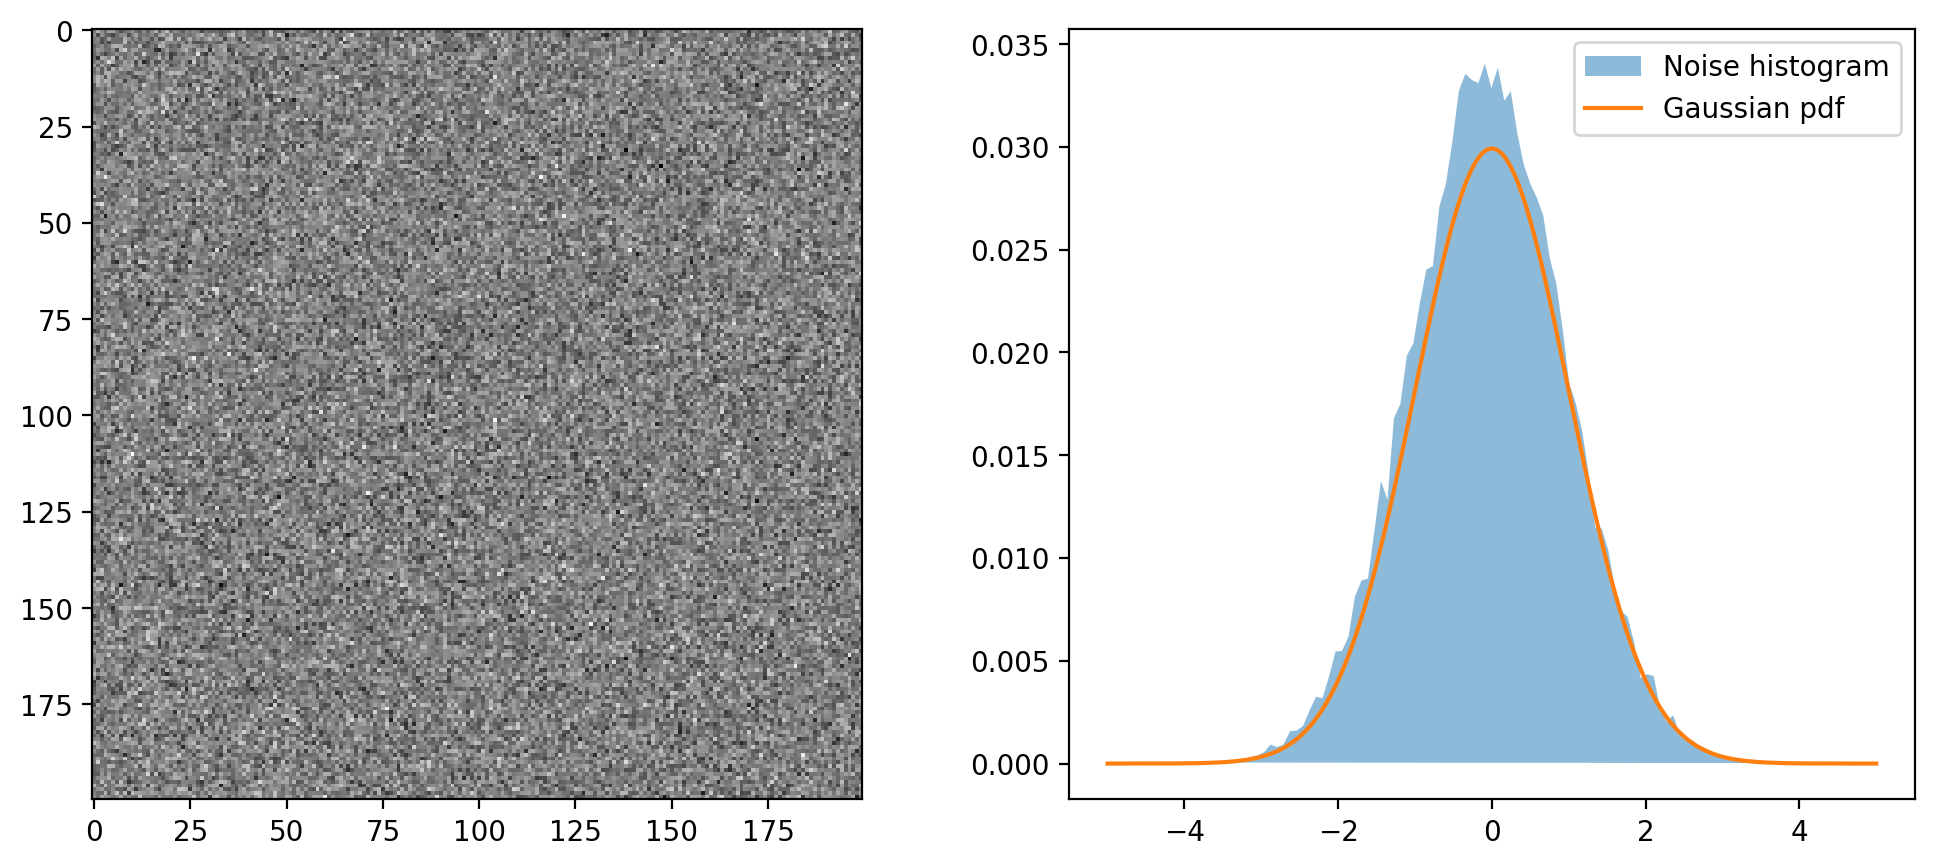

In [10]:
s0=1;
noise = np.random.normal(size=[200,200])
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].imshow(noise,cmap='gray')
h,bins = np.histogram(noise.ravel(),bins=100)
normh=h/h.sum()
ax[1].fill(bins[:-1],normh,alpha=0.5,label='Noise histogram')
x=np.linspace(-5,5,201)
pdf = cm.gaussian(x,0,1)
ax[1].plot(x,1.5*pdf/pdf.sum(),color=dcolors[1], label='Gaussian pdf')
ax[1].legend();

### Threshold between two Gaussian classes
_From lecture 4_

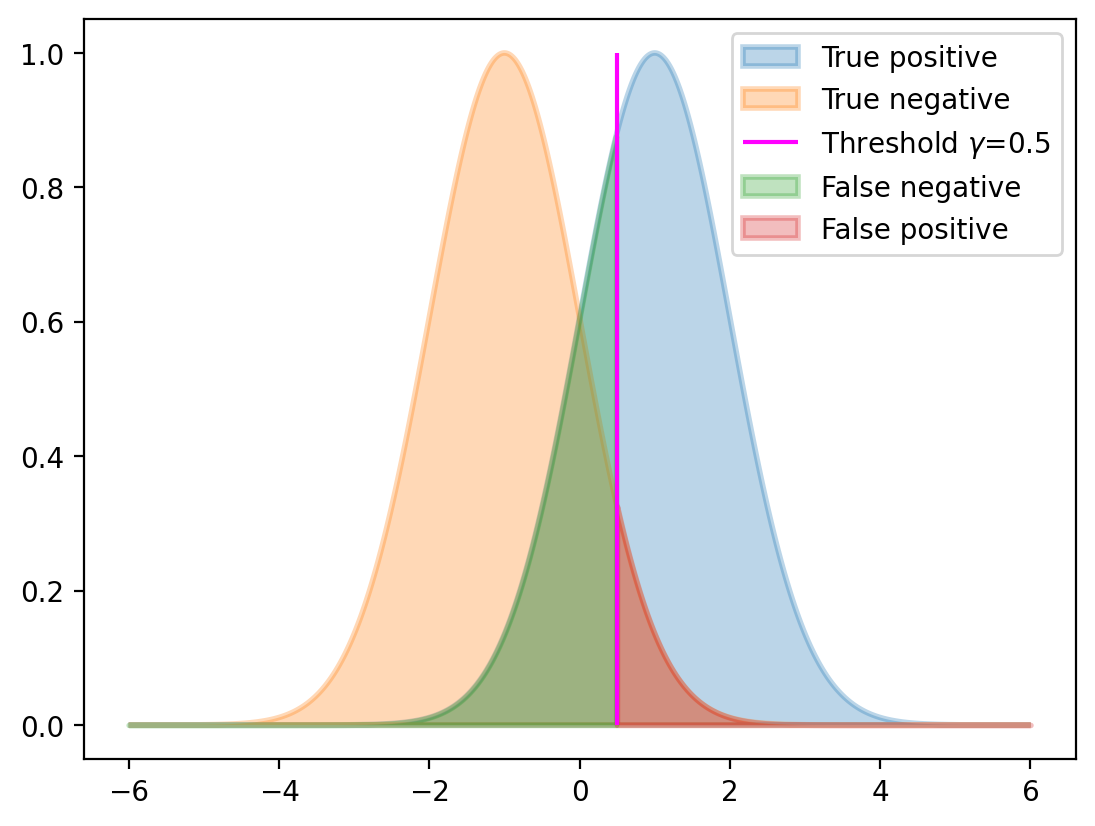

In [11]:
x=np.linspace(-6,6,1000)
h0 = np.exp(-(x-1)**2/2)
h1 = np.exp(-(x+1)**2/2)

gamma=0.5

# Visualization
gidx = np.abs(x - gamma).argmin()
plt.fill(x,h0,label='True positive',alpha=0.3,ec=dcolors[0],lw=2)
plt.fill(x,h1,label='True negative',alpha=0.3,ec=dcolors[1],lw=2)

plt.vlines([x[gidx]],ymin=0,ymax=1,color='magenta',label='Threshold $\gamma$={0}'.format(gamma))

plt.fill_between(x[:gidx],0,h0[:gidx],color=dcolors[2],label='False negative',alpha=0.3,ec=dcolors[2],lw=2)
plt.fill_between(x[gidx:],0,h1[gidx:],color=dcolors[3],label='False positive',alpha=0.3,ec=dcolors[3],lw=2)

plt.legend();

### Compute the confidence based on the class pdf's

We want the probability mix of the classes for each gray level:
1. Find the pdf for each class using Gaussian Mixture Models ([GMM](https://scikit-learn.org/stable/modules/mixture.html))
2. Normalize
    - Peak to one
    - AOC is one
3. For each gray level $x$ compute weights
$$w_i(x)= pdf_i(x)$$
for Gaussians $w_i(x)=e^{-\frac{(x-\mu_i)^2}{2 \sigma_i^2}}$
4. Then the confidence for class $i$ is 
$$c_i(x)=\frac{w_i(x)}{\sum_j w_j(x)}$$
5. Create a confidence map using the segmented image to select $c_i$ for each pixel



#### What are the weights?

In our algorithm we used $w_i(x)=e^{-\frac{(x-\mu_i)^2}{2 \sigma_i^2}}$

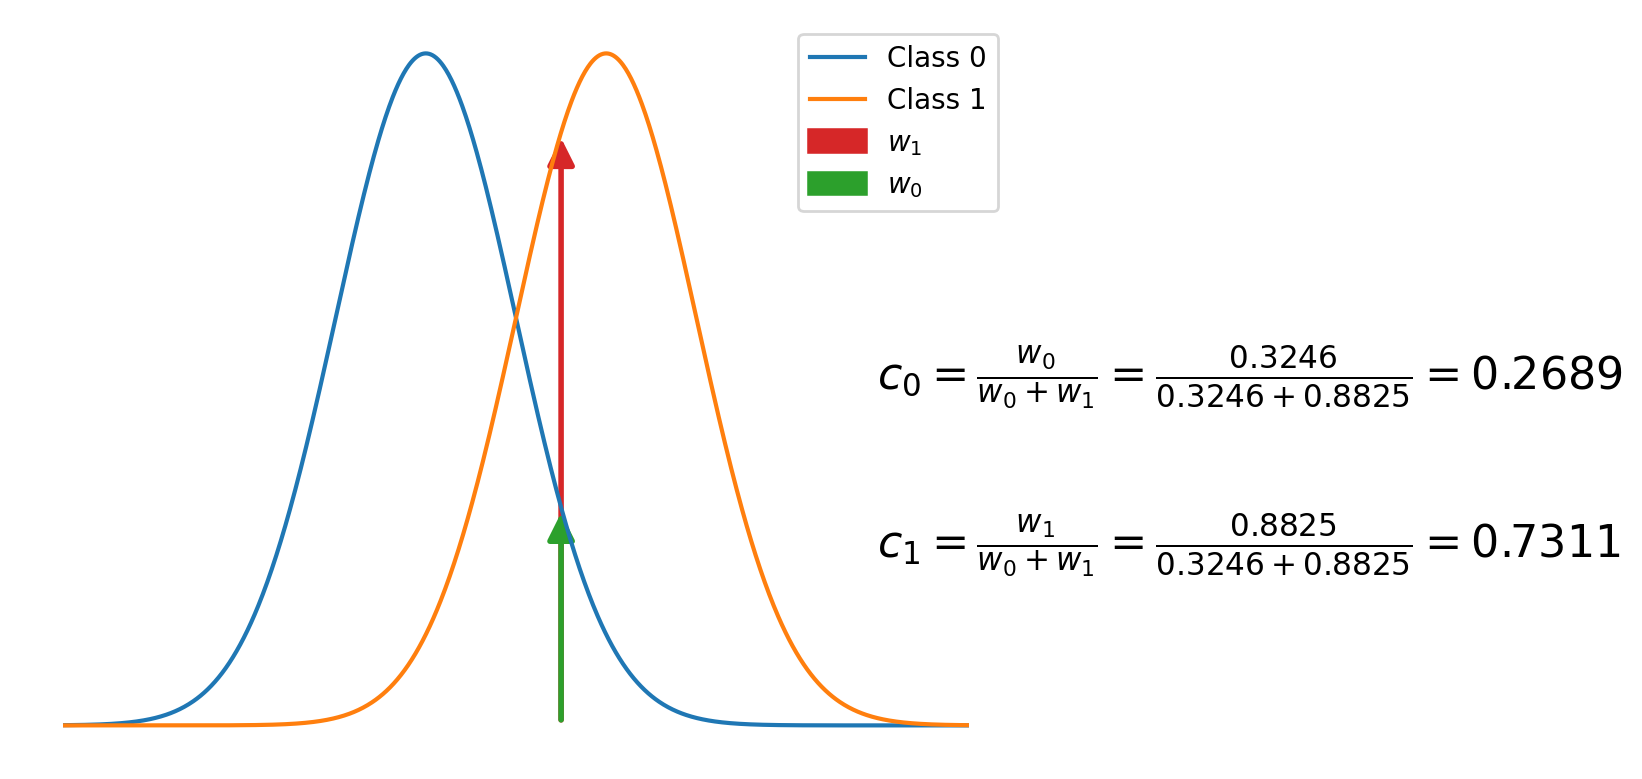

In [51]:
x=np.linspace(-5,5,1000)
g0=cm.gaussian(x,-1,1)
g0m=g0.max()
g0=g0/g0.max()
g1=cm.gaussian(x,1,1)
g1m=g1.max()
g1=g1/g1.max()
_,ax=plt.subplots(1)
ax.plot(x,g0,label=r'Class 0')
ax.plot(x,g1,label=r'Class 1')
xx=0.5
arrow = patches.FancyArrowPatch((xx,0), (xx,cm.gaussian(xx,1,1)/g1m),
                                 mutation_scale=20,
                                 color=dcolors[3],
                                 arrowstyle='-|>',linewidth=2,
                                label=r'$w_1$'
                                )
ax.add_patch(arrow);

arrow = patches.FancyArrowPatch((xx,0), (xx,cm.gaussian(xx,-1,1)/g0m),
                                 mutation_scale=20,
                                 color=dcolors[2],
                                 arrowstyle='-|>',linewidth=2,
                                label=r'$w_0$'
                                )
ax.add_patch(arrow);

ax.text(4,0.5,r'$c_0=\frac{w_0}{w_0+w_1}=\frac{0.3246}{0.3246+0.8825}=0.2689$',size=16)
ax.text(4,0.25,r'$c_1=\frac{w_1}{w_0+w_1}=\frac{0.8825}{0.3246+0.8825}=0.7311$',size=16)

plt.legend()
plt.axis('off');

# print(cm.gaussian(xx,-1,1)/g0m,cm.gaussian(xx,1,1)/g1m,cm.gaussian(xx,-1,1)/g0m/(cm.gaussian(xx,-1,1)+cm.gaussian(xx,1,1)/g1m),cm.gaussian(xx,1,1)/g0m/(cm.gaussian(xx,-1,1)+cm.gaussian(xx,1,1)/g1m))lass

### Example: Three phase segmentation

Our test data
- Three classes with $\mu$=[-3,1,5]
- Gaussian noise $~ \mathcal{N}(\mu, \sigma=1.0)$
- Unsharpness - Gaussian filter ($\sigma$=1)

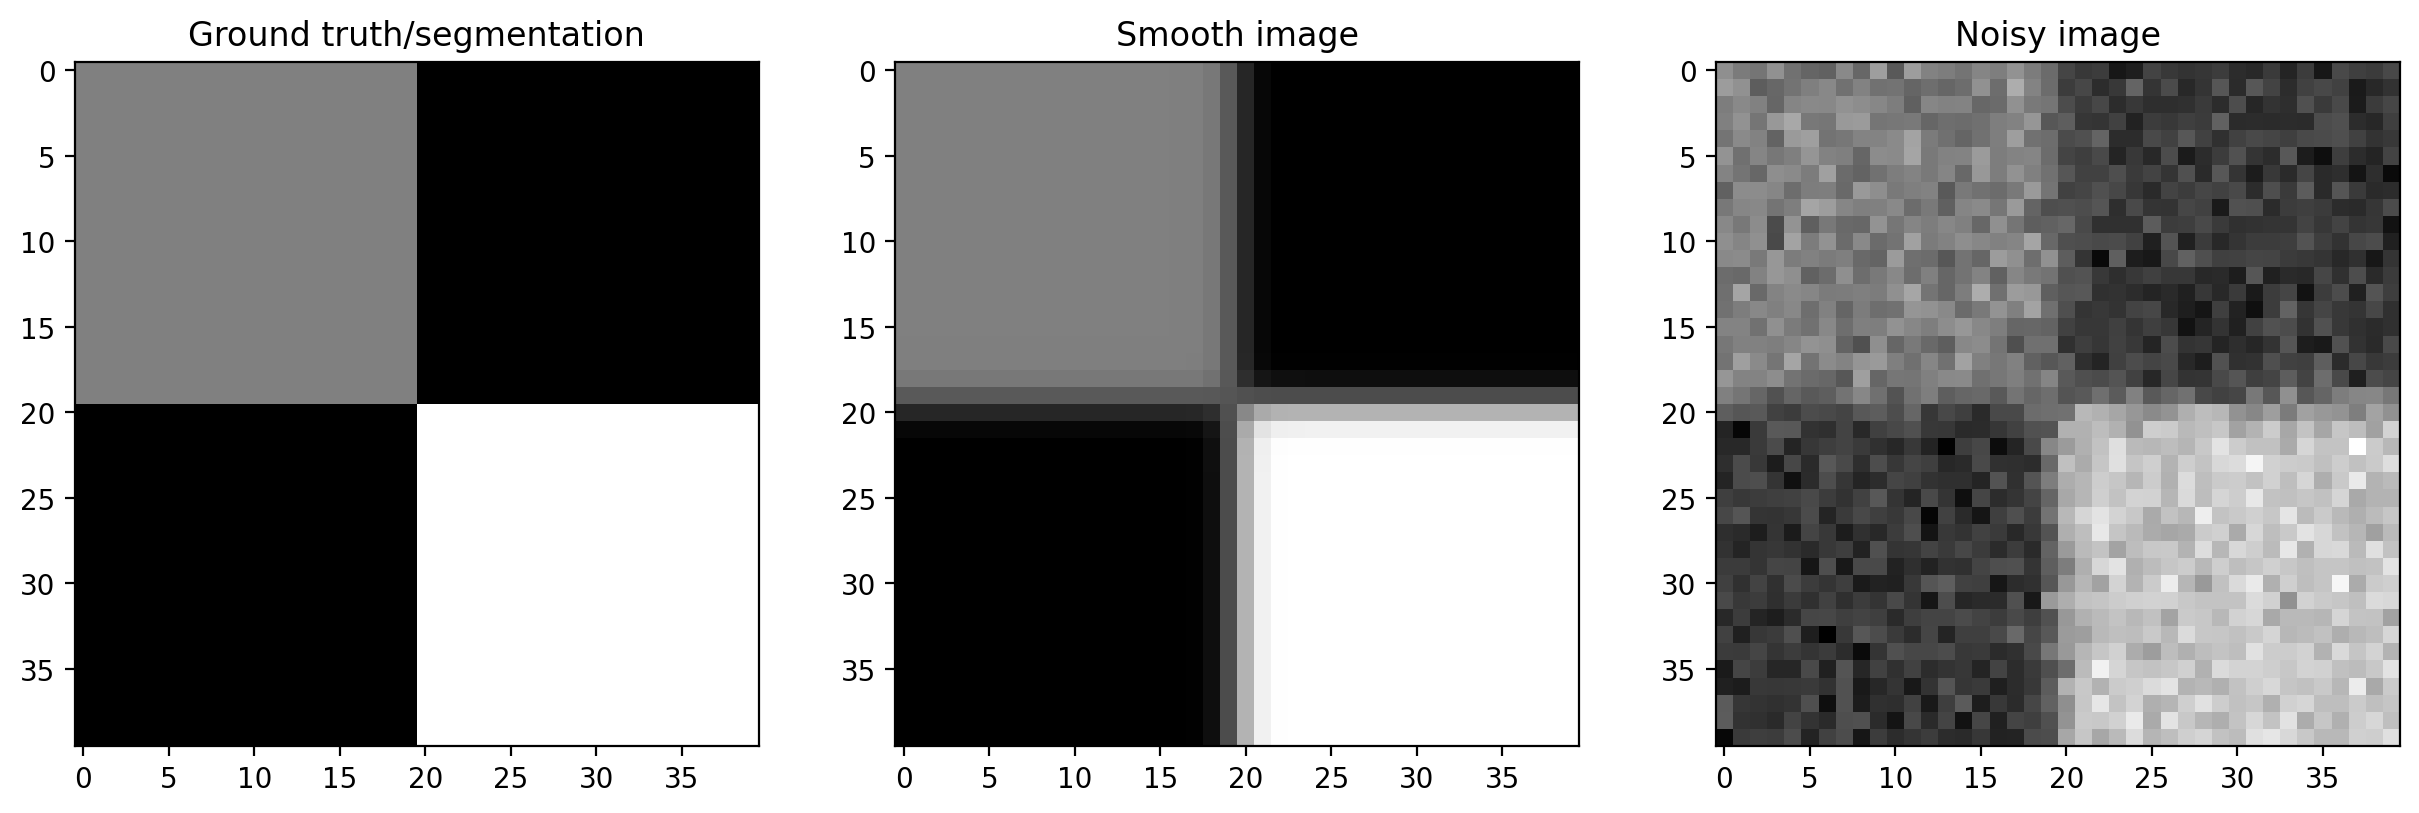

In [52]:
ss = 1
N = 20 
m=np.array([-3,1,5])
s=np.array([ss,ss,ss])
xx=np.linspace(-10,10,1001)
res = np.array([cm.multi_gaussian(x,m=m,s=s) for x in xx])

img=np.repeat(np.repeat(np.array([[m[1],m[0]],[m[0],m[2]]]),N,axis=0),N,axis=1)
seg=np.zeros(img.shape)
fimg = flt.gaussian(img,sigma=1,preserve_range=True)
for idx in range(len(m)):
    seg[img==m[idx]]=idx

nm = fimg+np.random.normal(loc=0,scale=ss,size=img.shape)

cmap = cm.conf_map(nm,seg,m,s)

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(seg,cmap='gray')
ax[0].set_title('Ground truth/segmentation')
ax[1].imshow(fimg,cmap='gray')
ax[1].set_title('Smooth image')
ax[2].imshow(nm,cmap='gray')
ax[2].set_title('Noisy image');

### The confidence maps for the segmenation
_Here, we cheat by using the original class image as segmented image_

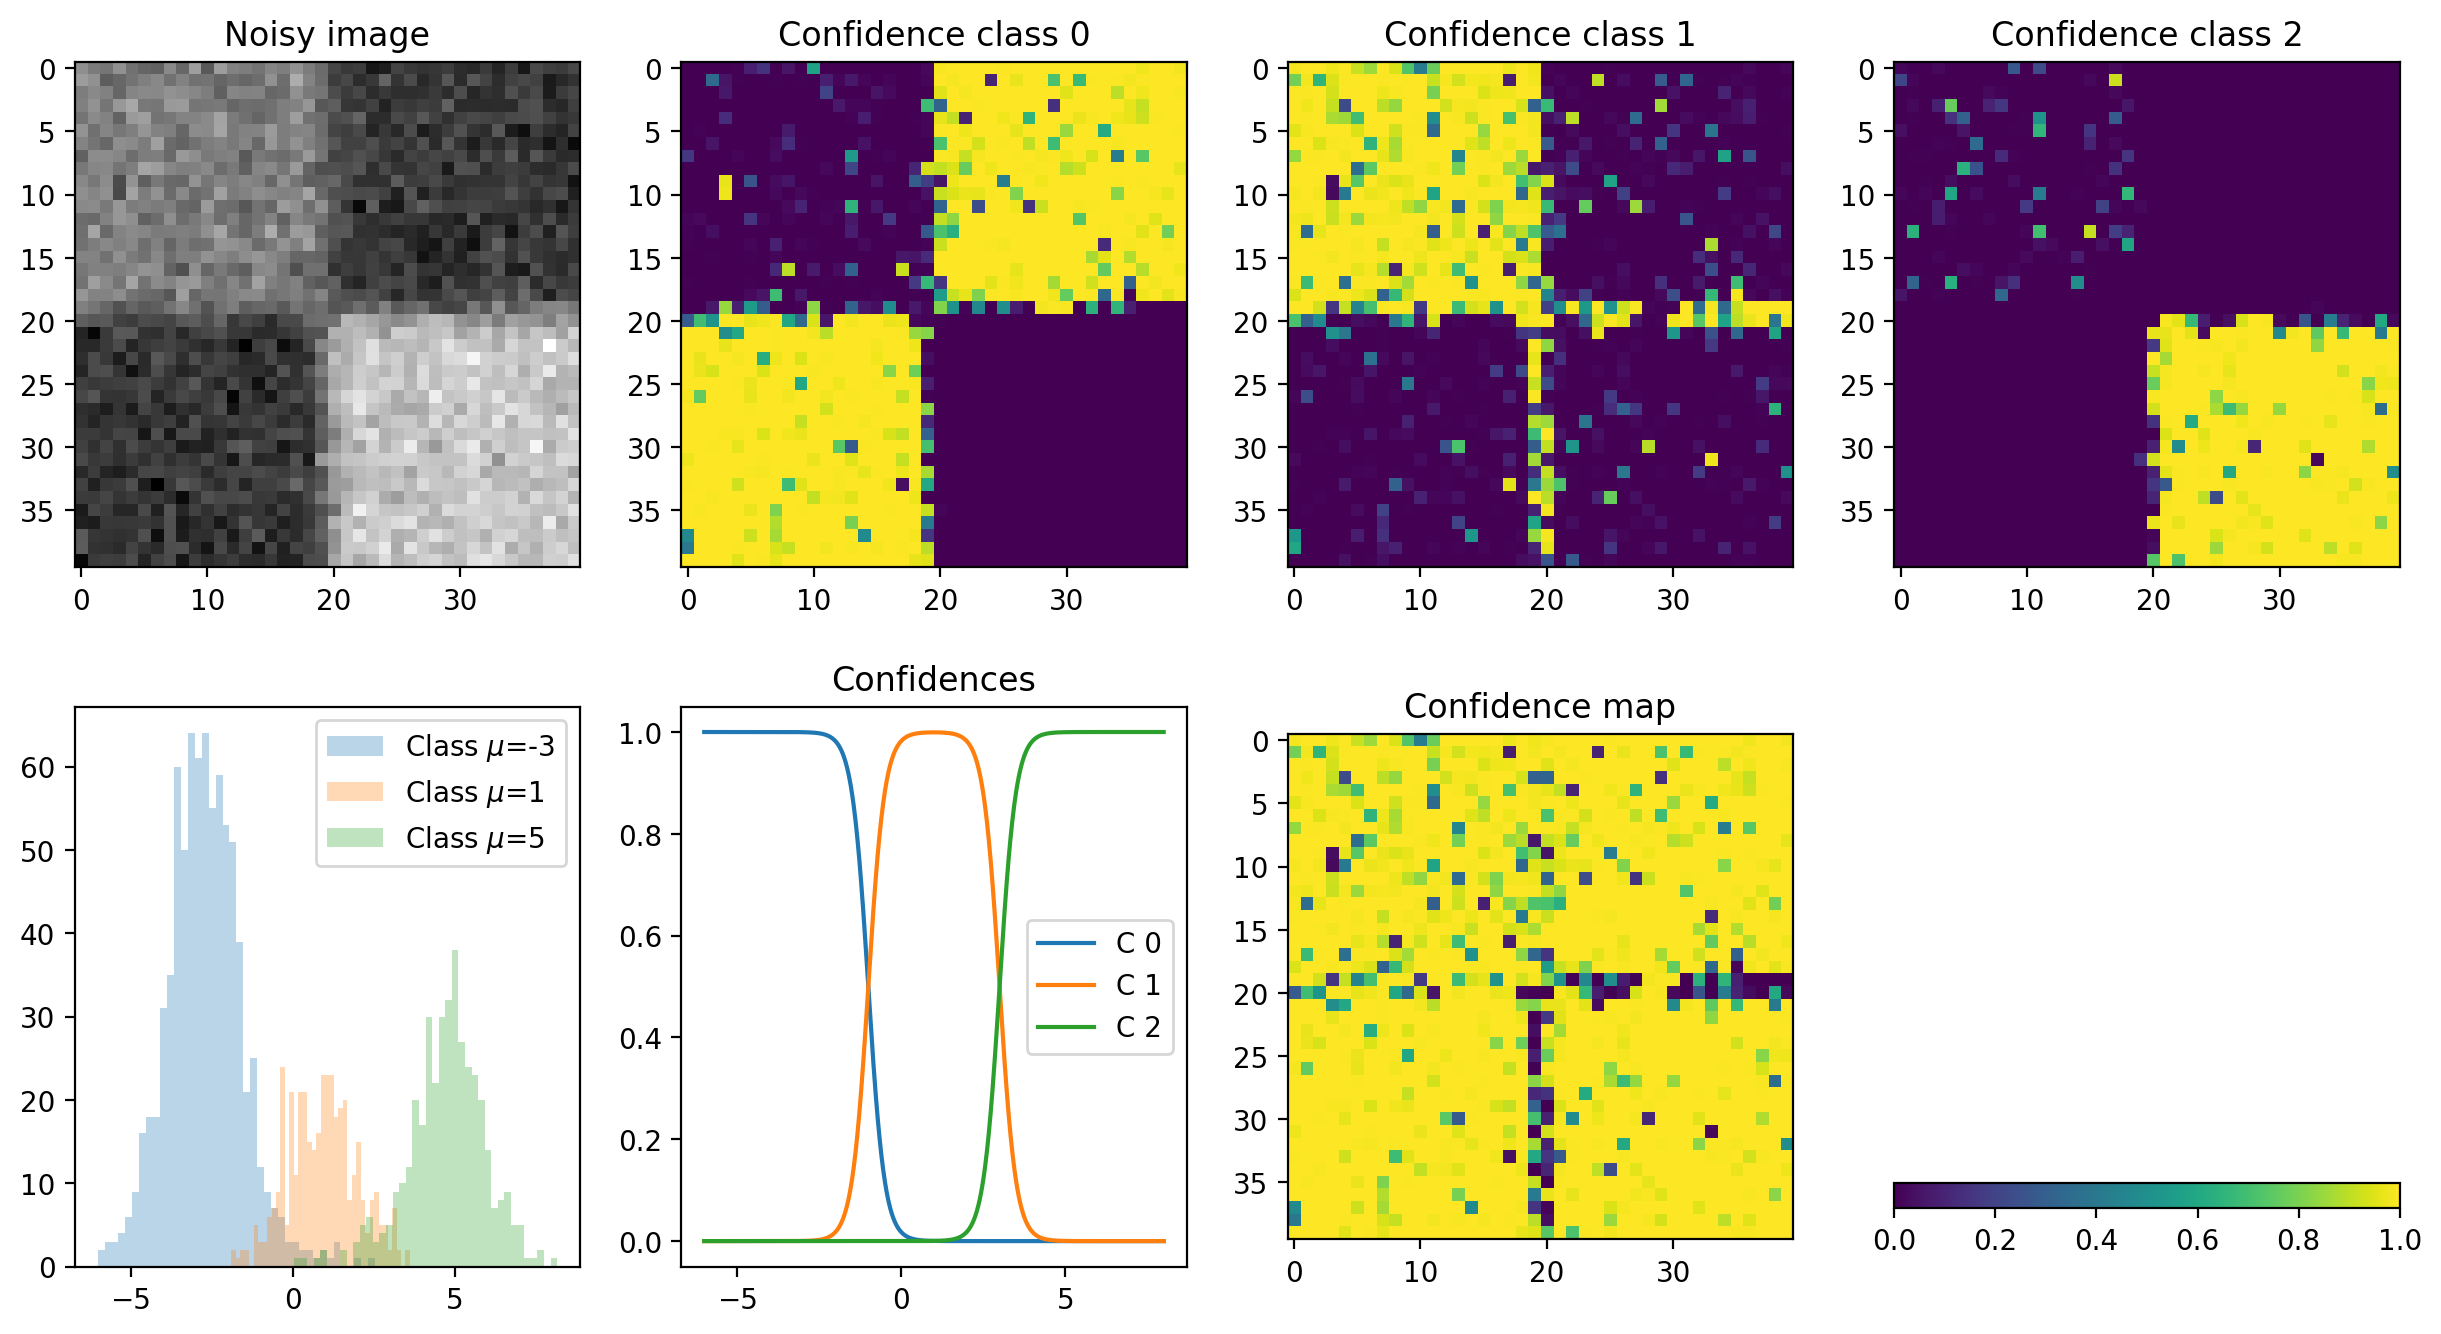

In [53]:
seg=np.zeros(img.shape)
fimg = flt.gaussian(img,sigma=1,preserve_range=True)
for idx in range(len(m)):
    seg[img==m[idx]]=idx

fig,ax=plt.subplots(2,4,figsize=(15,8))

ax=ax.ravel()
ax[0].imshow(nm,cmap='gray')
ax[0].set_title('Noisy image')

for idx in range(3):
    cmap = cm.conf_map(nm,seg,m,s,c=idx)
    ax[idx+1].imshow(cmap,clim=[0,1])
    ax[idx+1].set_title('Confidence class {}'.format(idx))

ax[4].hist(nm[seg==0].ravel(),bins=40, label="Class $\mu$=-3", alpha=0.3);
ax[4].hist(nm[seg==1].ravel(),bins=40, label="Class $\mu$=1", alpha=0.3);
ax[4].hist(nm[seg==2].ravel(),bins=40, label="Class $\mu$=5", alpha=0.3);
ax[4].legend()

# ax[4].plot(xx,res);
# ax[4].set_title('Normalized class distributions')

cmap = cm.conf_map(nm,seg,m,s)
ax6=ax[6].imshow(cmap,clim=[0,1])
ax[6].set_title('Confidence map')
xx,w = cm.conf_plot(m,s)
for idx in range(len(m)) :
    ax[5].plot(xx,w[idx]/np.sum(w,axis=0), label="C {}".format(idx));
    
ax[5].legend()
ax[5].set_title('Confidences');

ax[7].axis('off')
fig.colorbar(ax6,ax=ax[7],location='bottom');

## When does it matter?

<div class="row">
<div class="column">
        
### High SNR images
Edges have lowest confidence; most impact for
- Perimeter
- Turtosity
- Network connectivity
- Volumes of small items
        
</div>
<div class="column">
            
### Low SNR image
Low confidence on most pixels!
- All high-SNR issues
    
and
    
- Porosity
- Volumes
- Labeling
            
</div>

## Concluding uncertainties

- Scientific analysis requires uncertainties

- Uncertainties in imaging is not straight forward
    - Physical uncertainties can be quantified
    - Noise can be measured
    - Image analysis precision depends on object/pixel size ratio
    - The effect of processing must be quantified through simulations

# Statistical analysis of experiments

It often convenient to start with a simplified models for your experiments where most uncertainties are reduced. In particular here in this lecture we chose a simple model for the demonstration

We go for a simple model...

Since most of the experiments in science are usually 
- Application specific, 
- Noisy, 
- and often very complicated 

and are not usually good teaching examples.

##  A simple Model: Magic / Biased Coin

Our model is the task to flip a coin and determine if it is a fair or loaded. The coin has two outcomes
- head
- or tail

You buy a _magic_ coin at a shop.

__How many times do you need to flip it to _prove_ it is not fair?__

Next step is to describe an experiment strategy. Some examples are:

If I flip it 10 times and ...
- another person flips it 10 times. Is that the same as 20 flips?
- then multiply the results by 10. Is that the same as 100 flips?

As you already may have guessed, these are not the best assumtions, in particular not the second one. 

A different question is about collections of random variables:

What if
- I buy 10 coins and want to know which ones are fair, what do I do?

<center><img src="figures/np_coin-toss.svg" style='height:200px' /></center>


```{figure} figures/np_coin-toss.pdf
---
scale: 25%
---
Tossing a coin is a simple random process.
```

### Experiment: Magic / Weighted Coin


1. Each coin represents a stochastic variable $\mathcal{X}$ and each flip represents an observation $\mathcal{X}_i$.
1. The act of performing a coin flip $\mathcal{F}$ is an observation $\mathcal{X}_i = \mathcal{F}(\mathcal{X})$

We normally assume:
1. A _fair_ coin has an expected value of $E(\mathcal{X})=\frac{1}{2}$:
    - 50% Heads, 
    - 50% Tails
    
1. An _unbiased_ flip(er) means  _each flip is independent of the others_
$$P(\mathcal{F}_1(\mathcal{X})\cdot{}\mathcal{F}_2(\mathcal{X}))= P(\mathcal{F}_1(\mathcal{X}))\cdot{}P(\mathcal{F}_2(\mathcal{X}))$$

 - the expected value of the flip is the same as that of the coin
$$ E\left(\prod_{i=0}^\infty \mathcal{F}_i(\mathcal{X})\right) = E(\mathcal{X}) $$

## Transfer the Simple Model to Reality


### Coin Flip

1. Each flip gives us a small piece of information about 
    - the coin 
    - _and_ the flipper

<br/>

2. More flips provides more information
    - __Random / Stochastic variations__ in coin and flipper __cancel out__
    - __Systematic variations accumulate__

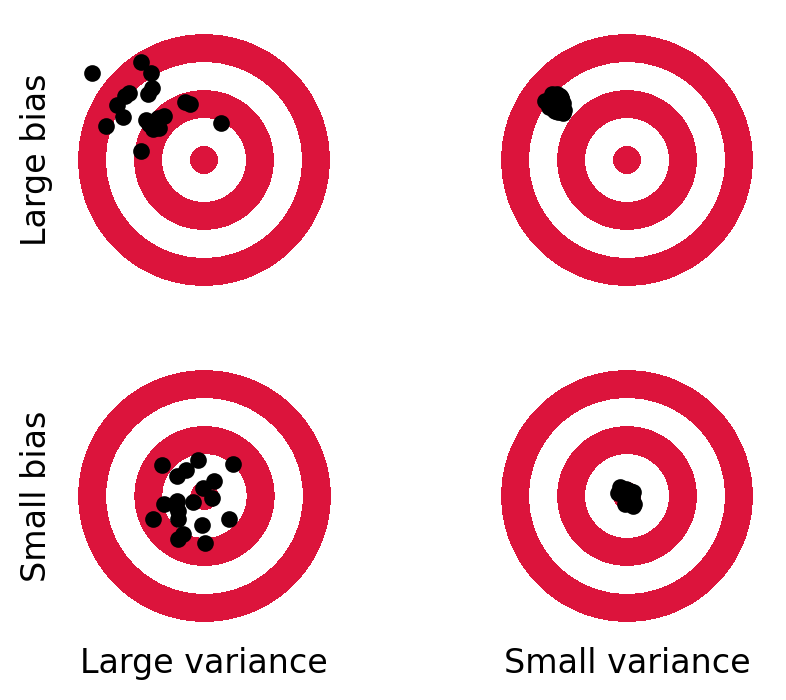

In [54]:
precacc(1000,['Large bias','Small bias','Large variance','Small variance'],figsize=[5,4],fontsize=12)

### Real experiment


1. Each measurement tells us about: 
    - our sample, 
    - our instrument, 
    - _and_ our analysis      
    
2. More measurements provide more information:
    - __Random / Stochastic__ variations in _sample, instrument, and analysis_ __cancel out__
    - _Normally_, the analysis has very little to no stochastic variation
    - __Systematic variations__ accumulate

This is also the reason why we want many repeated observations in an experiment. Repetitions are however expensive, they require time to perform the experiment and more material for the specimens. Therefore, a pragmatic choice must be made that balances the cost versus a reasonable amount of observations. 

# A more complicated model

Coin flips are very simple and probably difficult to match to another experiment. 

A very popular dataset for learning about such values beyond 'coin-flips' is called the [Iris dataset](http://archive.ics.uci.edu/ml/datasets/iris).  

It covers:
- a number of measurements 
- from different plants 
- and the corresponding species.

<center>
<img src="figures/Iris.png" style="height:300px"/>
</center>

## Let's load the Iris Dataset

Fisher, [The Use of Multiple Measurements in Taxonomic Problems](https://doi.org/10.1111/j.1469-1809.1936.tb02137.x), 1936

The data set has information about dimensions of the flower anatomy for each of the three species. We load the data which is provided as a python dictionary and prepare a data frame for the table. You will get a more detailed introduction to pandas data frames later in this lecture.

In [55]:
data              = load_iris()
iris_df           = pd.DataFrame(data['data'], columns=data['feature_names'])
iris_df['target'] = data['target_names'][data['target']]
iris_df.sample(5)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
30                 4.8               3.1                1.6               0.2   
98                 5.1               2.5                3.0               1.1   
104                6.5               3.0                5.8               2.2   
100                6.3               3.3                6.0               2.5   
128                6.4               2.8                5.6               2.1   

         target  
30       setosa  
98   versicolor  
104   virginica  
100   virginica  
128   virginica

## A first inspection of the data

We use a pair plot to inspect the table. Each target species is assigned a color to allow conclusions regarding clusters.

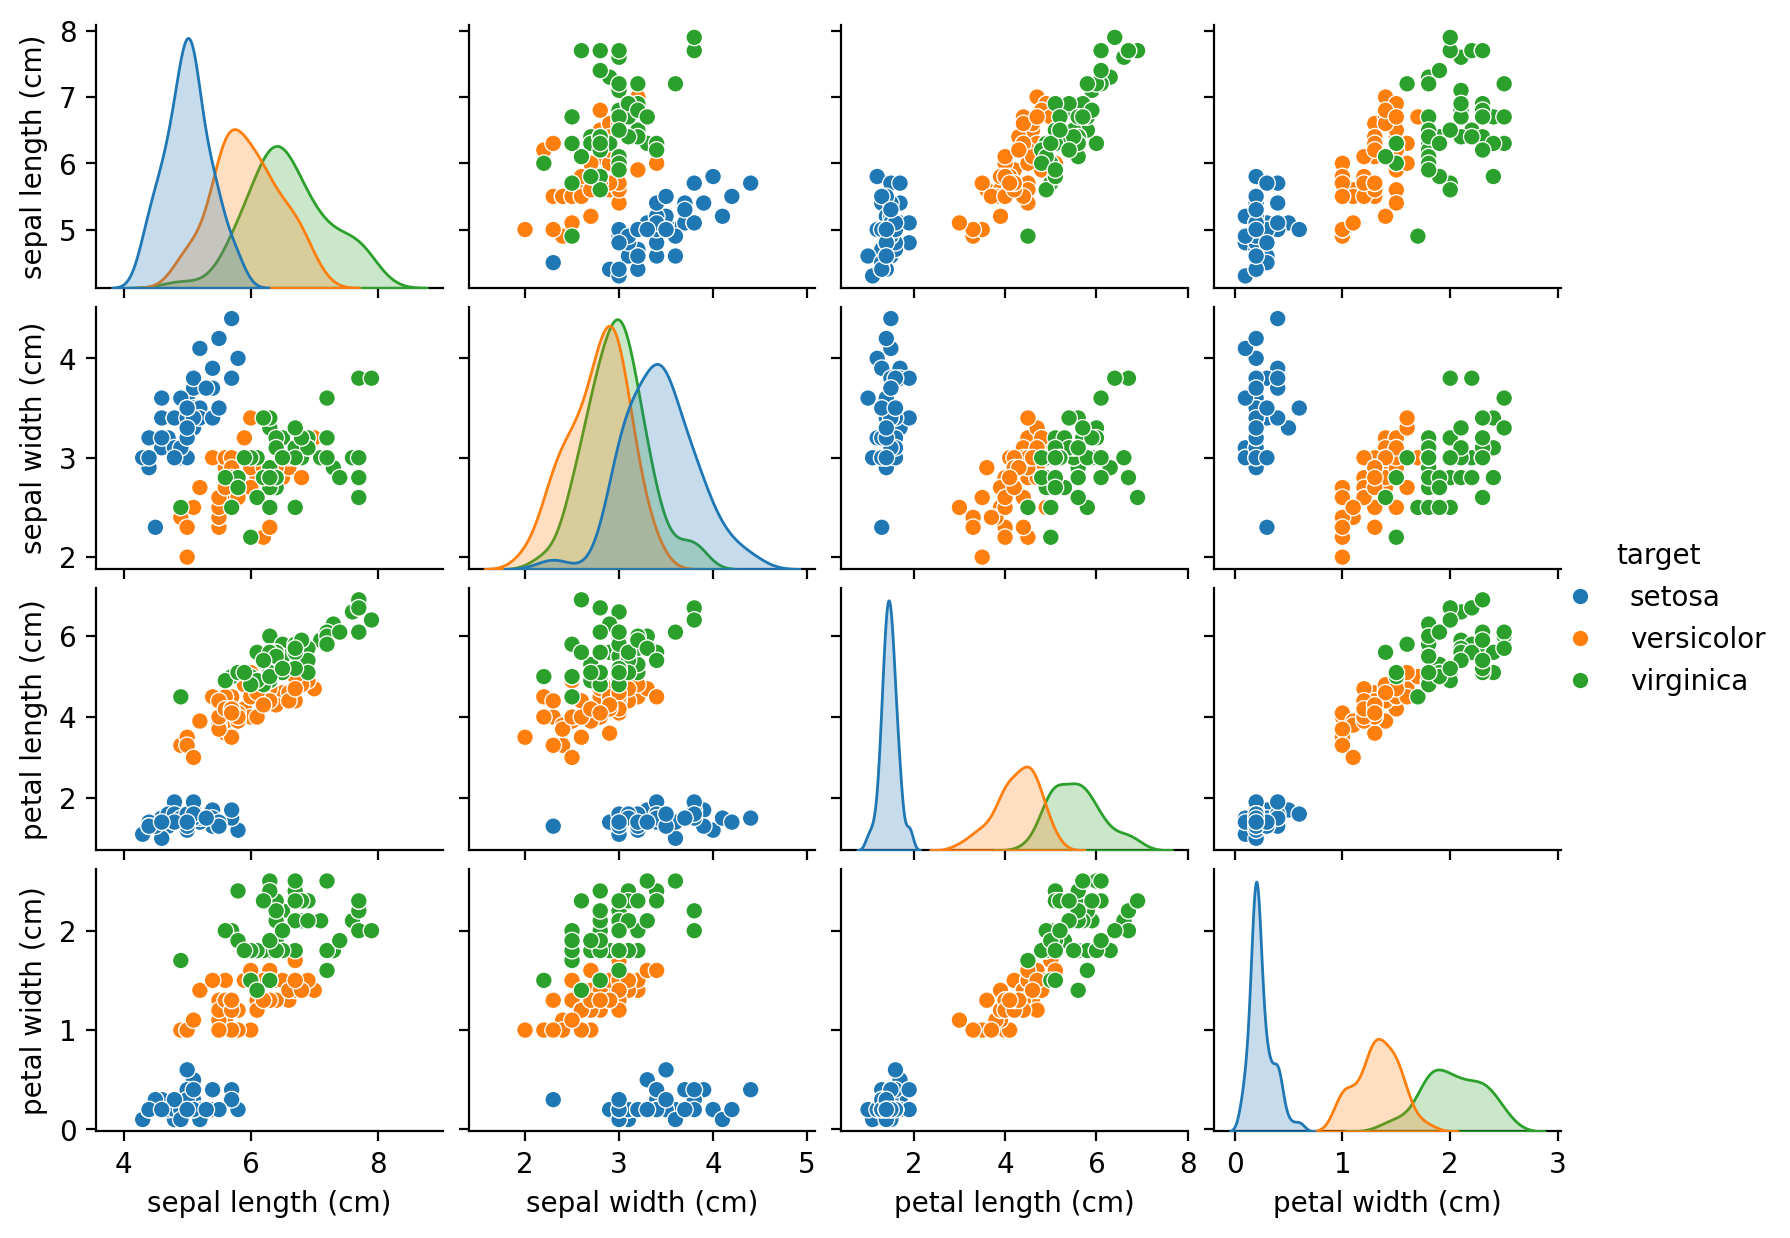

In [56]:
p=sns.pairplot(iris_df, hue='target');
plt.gcf().set_size_inches(9, 6)

In the plot, we clearly see that one species (setosa) in general has other flower leaf dimensions than the other two. 

## Comparing Groups: Intraclass Correlation Coefficient

The intraclass correlation coefficient basically looking at 
- how similar objects within a group are 
- compared to the similarity between groups

### Group similarity
How well are groups separated in a study
- Low group similarity - overlapping histograms, harder to separate
- High group similarity - separated histograms, easier to separate 

### Sepal width

Sepals are the green leaves of the flower bud. In this swarm plot we look at the width of the sepals and see that the variance of each class is about the same and also the the average width doesn't vary much. Under such conditions it is hard to separate the groups from each other and we are talking about a _low group similarity_.

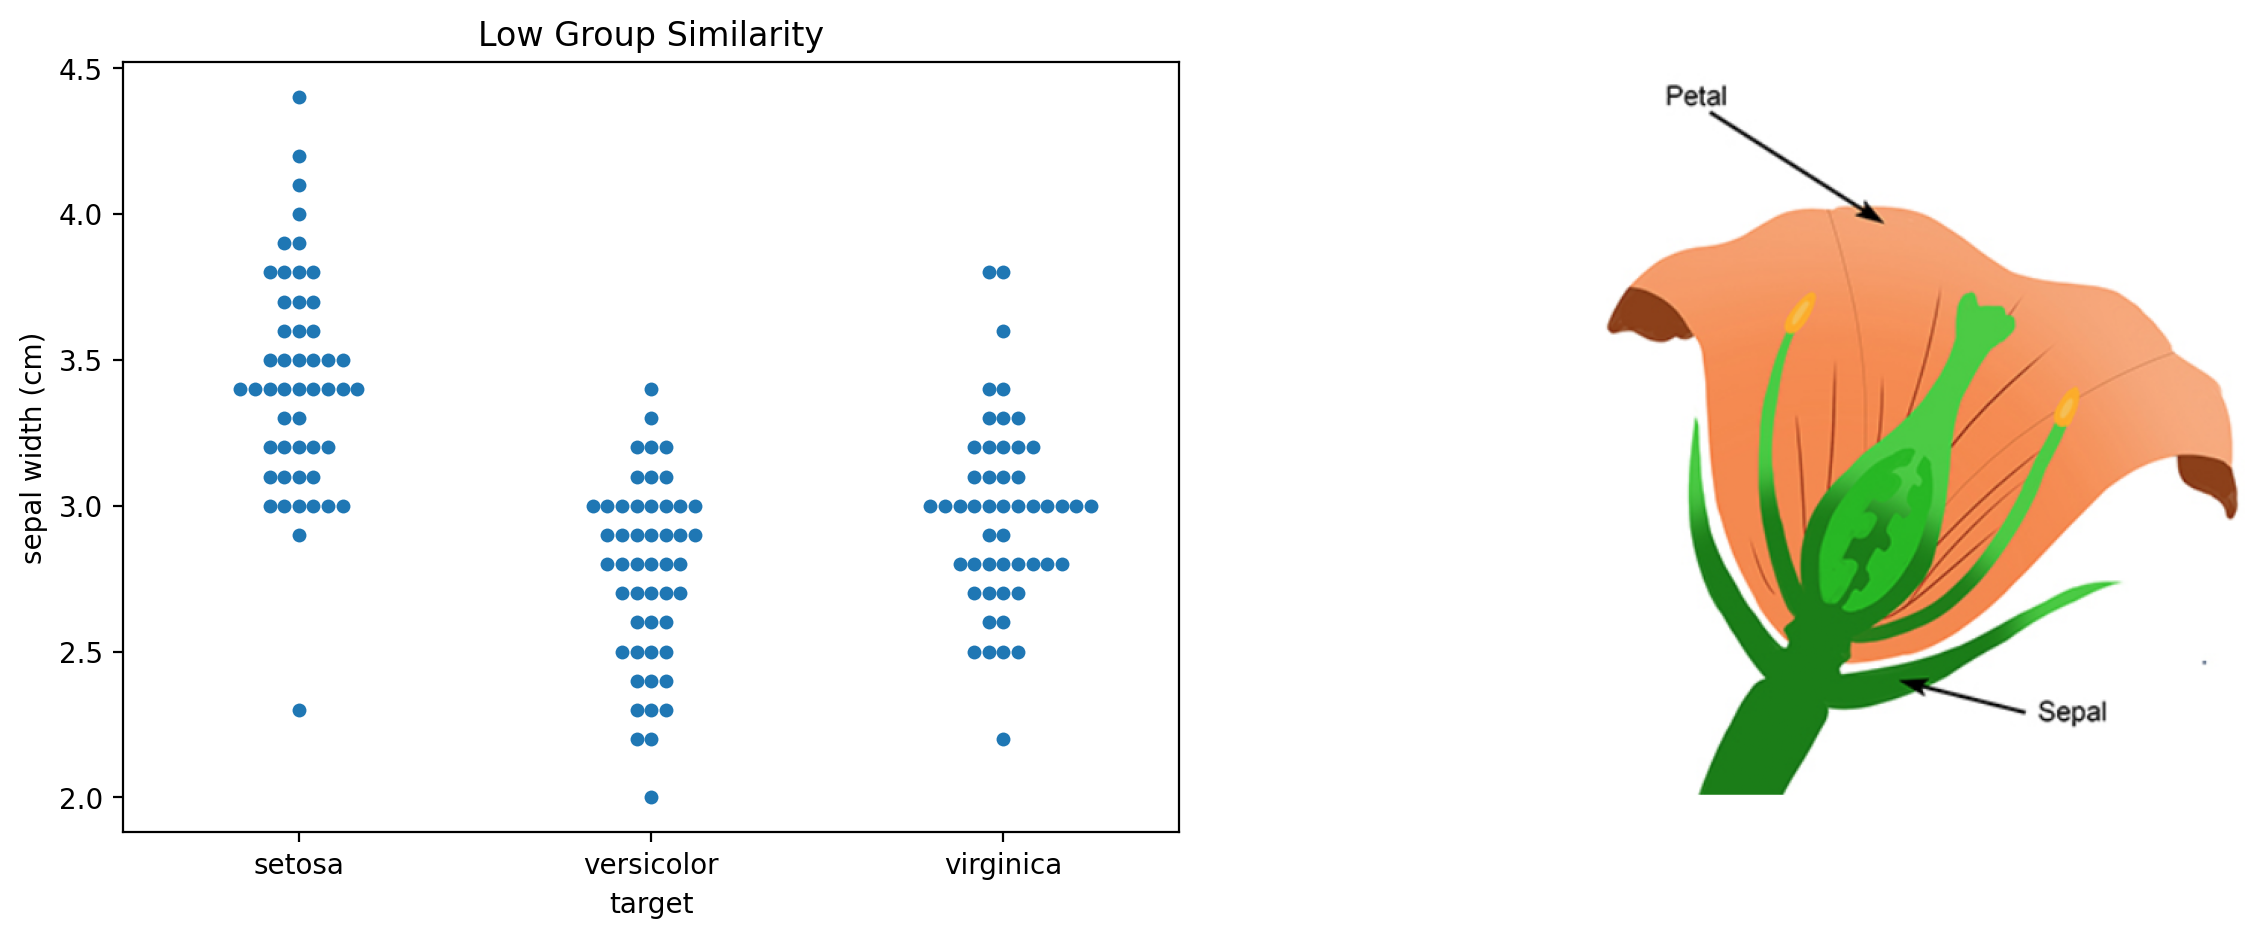

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.swarmplot(data=iris_df, ax = ax1,
               x='target', y='sepal width (cm)');ax1.set_title('Low Group Similarity');
ax2.imshow(plt.imread('figures/FlowerAnatomy.png')); ax2.axis('off');

### Petal length

Petals are the colourful and beautiful leaves of the flower. In this swarm plot of the petal length we see that the petals are more clustered and the averages are well separated from each other. This is a case we know is easy to separate the groups and we are talkning about data with a _high group similarity_.

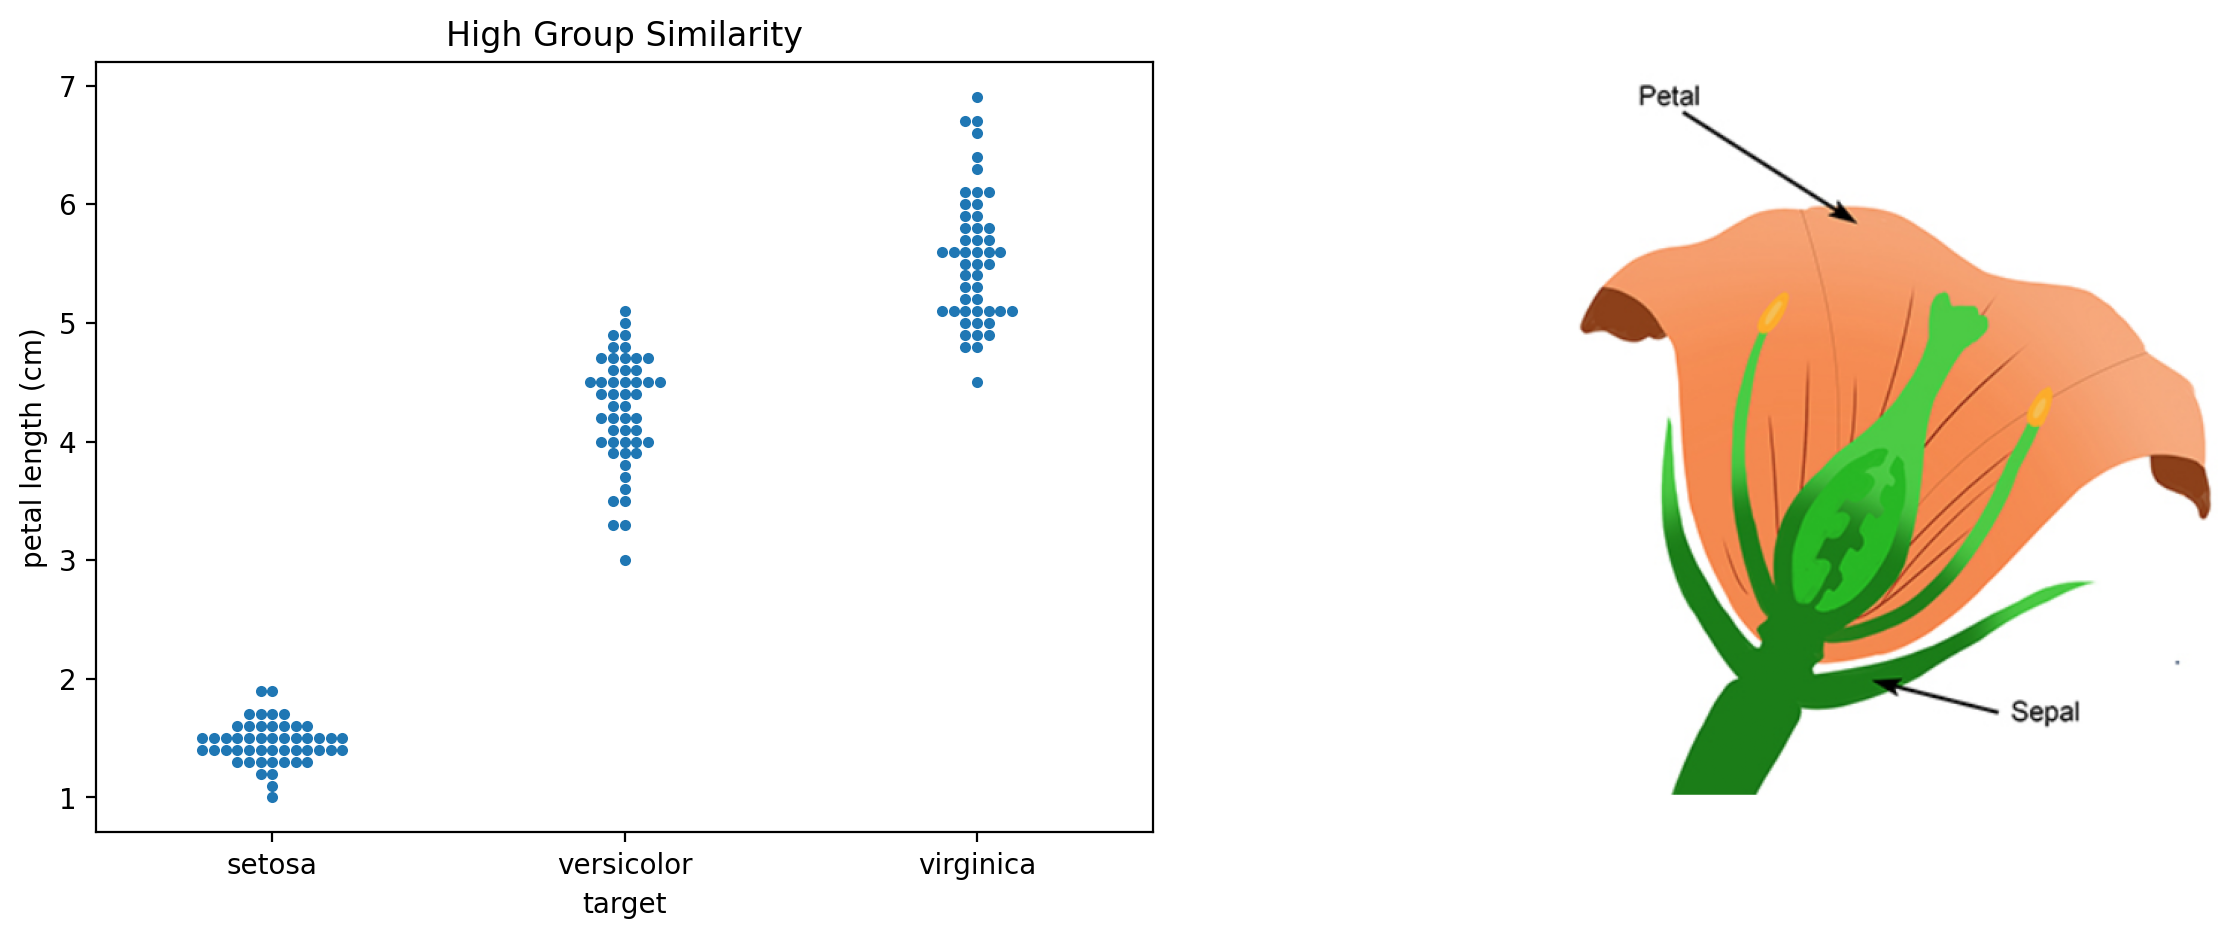

In [58]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
g = sns.swarmplot(data=iris_df, ax=ax1,
               x='target', y='petal length (cm)',size=4);g.set_title('High Group Similarity');
ax2.imshow(plt.imread('figures/FlowerAnatomy.png')); ax2.axis('off');

## Making quantitative statements
### Intraclass Correlation Coefficient Definition
$$ICC=\frac{S_A^2}{S_A^2+S_W^2}$$
where 
- The variance among groups or classes  
Estimate with the standard deviations of the mean values for each group  

    $$S_A^2=\mathrm{s}[\mathrm{E}[x_{group}]]^2$$
    
- The variance within groups or classes  
Estimate with the average of standard deviations for each group  

    $$S_W^2=\mathrm{E}[\mathrm{s}[x_{group}]^2]$$

#### Interpretation of the ICC
$$ICC=\frac{S_A^2}{S_A^2+S_W^2}$$

$$ICC=\begin{cases}1&\mbox{means 100 percent of the variance is between classes, well separated}\\0&\mbox{means 0 percent of the variance is between classes, overlapping}\end{cases}$$

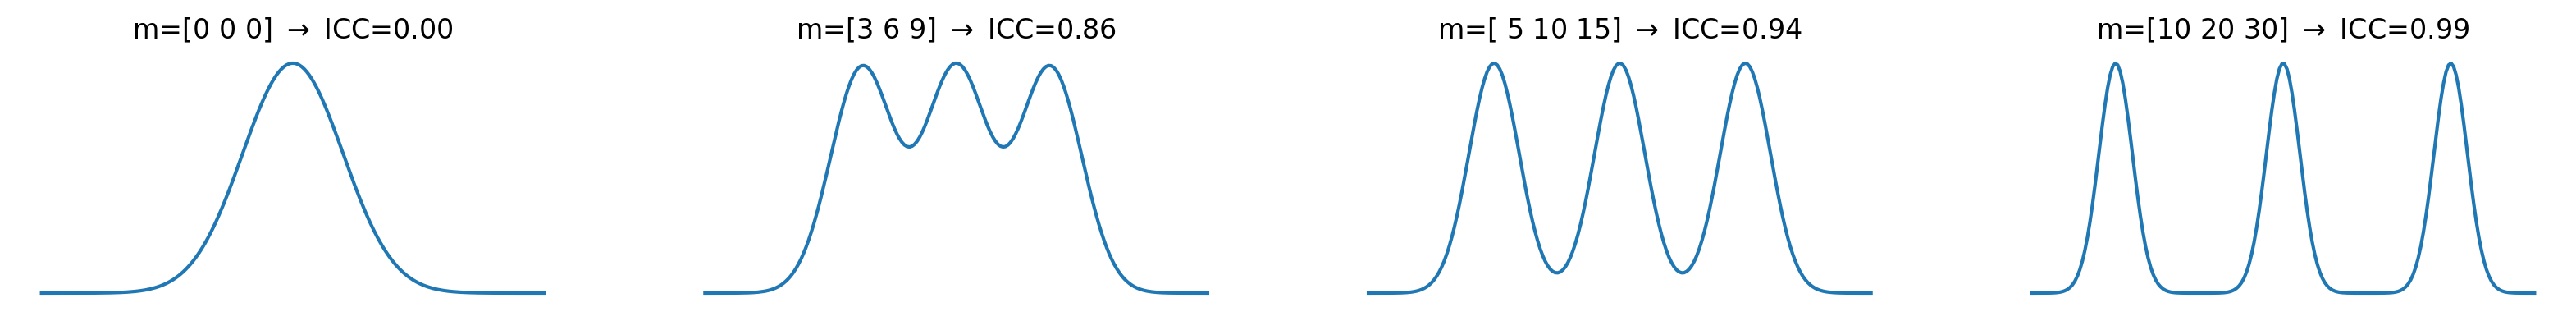

In [59]:
def sum_gaussian(x,A,m,s) :
    g=np.zeros(x.shape[0])
    
    for aa,mm,ss in zip(A,m,s) :
        g=g+aa*np.exp(-(x-mm)**2/(2*ss**2))
    return g
        

A=[1,1,1]
m=np.array([1,2,3])
s=np.array([1,1,1])

def icc(m,s) :
    return m.var()/(m.var()+s.mean()**2)

def plot_icc_examples(m,s,mscale) :
    N=len(mscale)
    fig,ax = plt.subplots(1,N,figsize=[5*N,2])
    
    for idx in range(N) :
        x=np.linspace(m[0]*mscale[idx]-5*s[0],m[-1]*mscale[idx]+5*s[-1],200)
        ax[idx].plot(x,sum_gaussian(x,A,m*mscale[idx],s))
        ax[idx].set(title=r"m={0} $\rightarrow$ ICC={1:0.2f}".format(m*mscale[idx],icc(m*mscale[idx],s)),
                   xticks=[],yticks=[])
        ax[idx].axis('off')
        
plot_icc_examples(m,s,[0,3,5,10])
        

### Intraclass Correlation Coefficient: Values
$$ICC=\frac{S_A^2}{S_A^2+S_W^2}$$

When compute the ICC for sepal width and petal length, we see that the ICC confirms our first qualitative assessment about the group similiarity.

sepal width (cm): S_w=0.12, S_a=0.11
petal length (cm): S_w=0.19, S_a=4.37


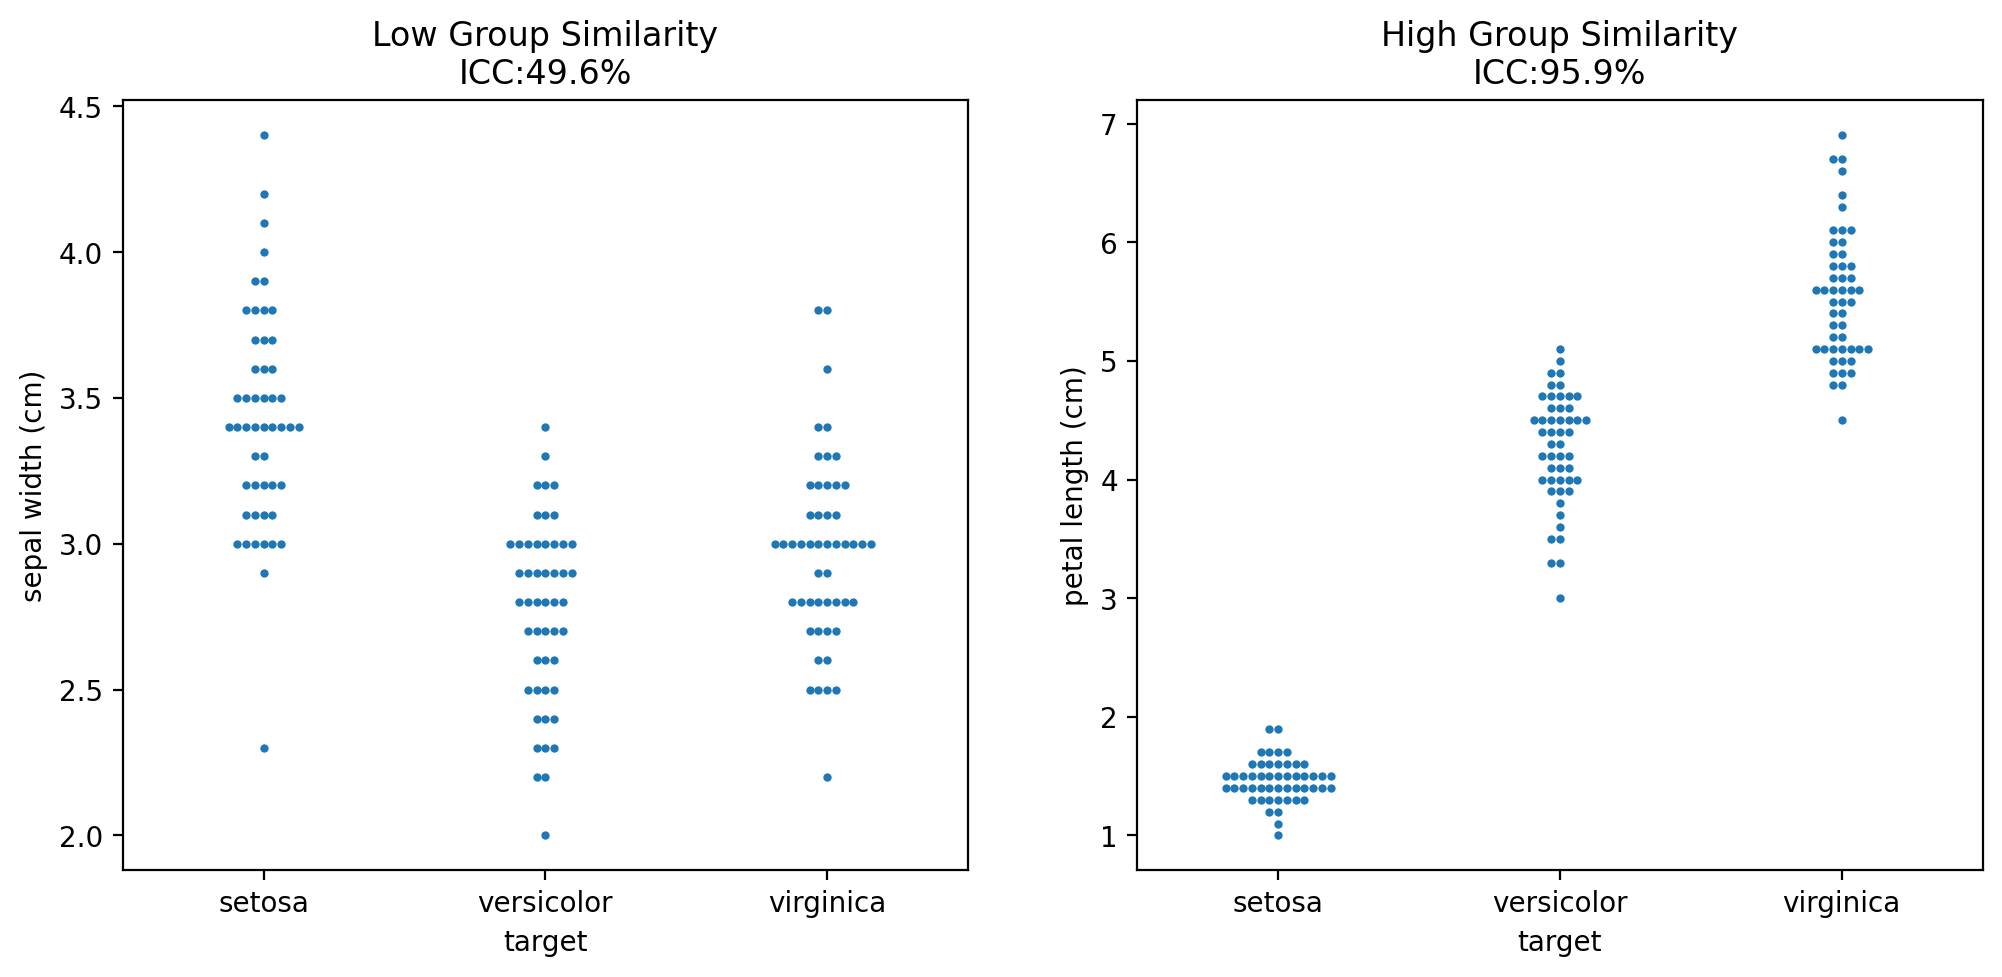

In [60]:
def icc_calc(value_name, group_name, data_df):
    data_agg = data_df.groupby(group_name).agg({value_name: ['mean', 'var']}).reset_index()
    data_agg.columns = data_agg.columns.get_level_values(1)
    S_w = data_agg['var'].mean()
    S_a = data_agg['mean'].var()
    print('{0}: S_w={1:0.02f}, S_a={2:0.2f}'.format(value_name,S_w,S_a))
    return S_a/(S_a+S_w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.swarmplot(data=iris_df, ax=ax1,
               x='target', y='sepal width (cm)',size=3)
ax1.set_title('Low Group Similarity\nICC:{:2.1%}'.format(icc_calc('sepal width (cm)', 'target', iris_df)));

sns.swarmplot(data=iris_df,ax=ax2, 
               x='target', y='petal length (cm)',size=3)
ax2.set_title('High Group Similarity\nICC:{:2.1%}'.format(icc_calc('petal length (cm)', 'target', iris_df)));

# Comparing Groups


Once the reproducibility has been measured, it is possible to compare groups. 

The idea is to make a test to assess the likelihood that two groups are the same given the data

1. List assumptions
1. Establish a null hypothesis $\mathcal{H}_0$
    - Usually that both groups are the same  
 
1. Calculate the probability of the observations given the truth of the null hypothesis
    - Requires knowledge of probability distribution of the data
    - Modeling can be exceptionally complicated
 

### Outcomes for decision making
![](figures/cases_of_decision_making.png)
With error probabilites:
- $\alpha$ - probability of Type I errors / significance level
- $\beta$ - probability of Type II errors

From [Privitera 2017](http://www.sagepub.com/upm-data/40007_Chapter8.pdf)

## Loaded Coin example

We have 1 coin from a magic shop. Our assumptions are:
- we flip and observe flips of coins accurately and independently
- the coin is invariant and always has the same expected value  

Testing
- Our null hypothesis ($\mathcal{H}_0$): the coin is unbiased $E(\mathcal{X})=0.5$
- we can calculate the likelihood of a given observation given the number of flips ([p-value](https://en.wikipedia.org/wiki/P-value))

<center>
<img src="figures/p-value.svg" style="height:250px"/>
</center>

How good is good enough?

```{figure} figures/p-value.pdf
---
scale: 100%
---
Explaining p-value with the normal distribution.
```

## Comparing Groups: Student's T Distribution

- Since we do not usually know our distribution very well   
_or_
- have enough samples to create a sufficient probability model

### [Student T Distribution](http://en.wikipedia.org/wiki/Student's_t-distribution)
We assume the distribution of our stochastic variable 
- is normal (Gaussian) 
- and the t-distribution provides an estimate for the mean of the underlying distribution based on few observations.

We estimate the likelihood of our observed values assuming they are coming from random observations of a normal process

### [Student T-Test](https://en.wikipedia.org/wiki/Student%27s_t-test)

- Incorporates the Student T distribution 
- and provides an easy method for assessing the likelihood that the two given sets of observations are coming from the same underlying process (null hypothesis, $\mathcal{H}_0$)

The test assume
- unbiased observations
- normal distribution

# Multiple Testing Bias


Back to the magic coin, let's assume we are trying to publish a paper, 
 
- Null-hypothesis ($\mathcal{H}_0$): the coin is fair
- we heard a p-value of < 0.05 (5%) was good enough.

That means if we get 5 heads ($P=0.5^5\approx 0.031$) we are good!

## Probability with increasing number of tosses

$$ P = \prod_i P(\mathcal{F}_i(\mathcal{X}))$$

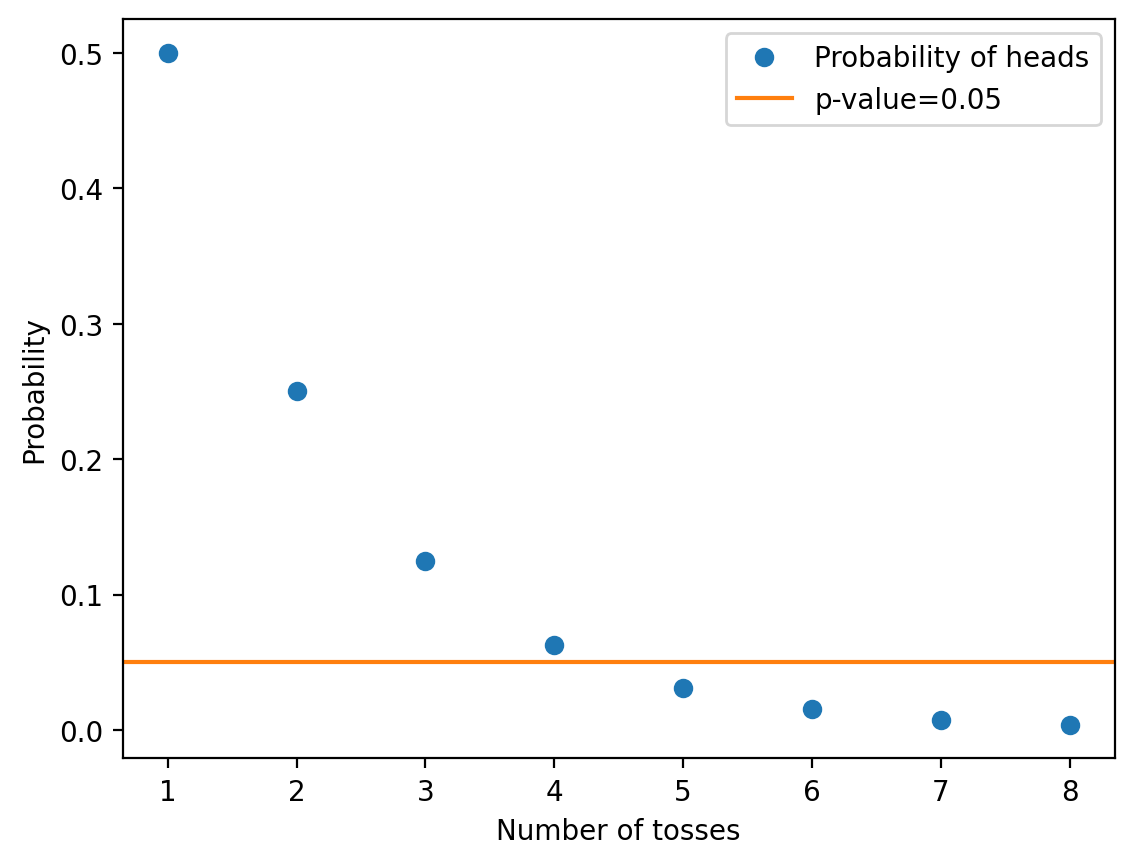

In [61]:
# import pandas as pd
# from scipy.stats import ttest_ind
# from IPython.display import display
# all_heads_df = pd.DataFrame({'n_flips': [1, 4, 5]})
# all_heads_df['Probability of # Heads'] = all_heads_df['n_flips'].map(
#     lambda x: '{:2.1%}'.format(0.5**x))
# display(all_heads_df)

flips = np.linspace(1,8,8)
plt.plot(flips,np.power(0.5,flips),'o',label="Probability of heads")
pval=0.05
plt.axhline(pval,color=dcolors[1], label="p-value={0}".format(pval))
plt.gca().set(xlabel='Number of tosses',ylabel='Probability')
plt.legend();


## Probability with many experiments
Let N friends make 5 tosses...

$$P = \overbrace{1-(\underbrace{1-0.5^{N_{Tosses}}}_{\mbox{Not getting 5 heads}})^{N_{Friends}}}^{\mbox{Get 5 heads}}$$

In [62]:
friends_heads_df = pd.DataFrame({'n_friends': [1, 10, 20, 40, 80]})
friends_heads_df['Probability of 5 Heads'] = friends_heads_df['n_friends'].map(
    lambda n_friends: '{:2.1%}'.format((1-(1-0.5**5)**n_friends)))
display(friends_heads_df)

n_friends Probability of 5 Heads
0          1                   3.1%
1         10                  27.2%
2         20                  47.0%
3         40                  71.9%
4         80                  92.1%

### A flaw in the evaluation
Clearly this is not the case, otherwise we could keep flipping coins or ask all of our friends to flip until we got 5 heads and publish

The p-value is only meaningful when the experiment matches what we did. 
- __We didn't say the chance of getting 5 heads ever was < 5%__
- __We said is if we have__
    - exactly 5 observations 
    - and all of them are heads 
    - the likelihood that a fair coin produced that result is <5%

__There are many [methods](http://en.wikipedia.org/wiki/Multiple_comparisons_problem) to correct.__

Most just involve scaling $p$: 
- The likelihood of a sequence of 5 heads in a row if you perform 10 flips is 5x higher.

## Multiple Testing Bias: Experiments


This is very bad news for us. We have the ability to quantify all sorts of interesting metrics 
- cell distance to other cells
- cell oblateness
- cell distribution oblateness

So, lets throw them all into a magical statistics algorithm and push the __publish__ button


With our p value of less than 0.05 and a study with 10 samples in each group, how does increasing the number of variables affect our result

### Let's look at multiple observations

We make five random variables with ten observations of a uniform distribution in the interval $\pm$1

$$var\_i \in \mathcal{U}(-1,1)$$

and make two groups '1' and '2'

In [63]:
import pandas as pd
import numpy as np
pd.set_option('display.precision', 2)
np.random.seed(2017)

def random_data_maker(rows, cols):
    data_df = pd.DataFrame(
        np.random.uniform(-1, 1, size=(rows, cols)),
        columns=['Var_{:02d}'.format(c_col) for c_col in range(cols)])
    data_df['Group'] = [1]*(rows-rows//2)+[2]*(rows//2)
    return data_df

rand_df = random_data_maker(10, 5)

rand_df

Var_00  Var_01  Var_02  Var_03  Var_04  Group
0   -0.96    0.53   -0.10   -0.76    0.86      1
1    0.30   -0.72   -0.54   -0.55   -0.48      1
2   -0.77    0.26   -0.23   -0.37    0.26      1
3   -0.41    0.89   -0.70   -0.85    0.41      1
4   -0.86   -0.39   -0.34   -0.38   -0.12      1
5    0.53   -0.05   -0.99    0.40    0.26      2
6   -0.94   -0.83    0.41   -0.09    0.41      2
7    0.86   -0.18   -0.92    0.24   -0.28      2
8    0.84    0.83   -0.46   -0.39   -0.97      2
9    0.08    0.34   -0.09    0.07    0.82      2

### Compute p-values for the table

The Student-t test is computed using the python function 
```python
scipy.stats import ttest_ind

ttest_ind(var_i[Group==1],var_i[Group==2])
```

This is a two-sided test for the null hypothesis that two independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

Here, we compute the p-values for the table we just created. The variables with p-values less than 0.05 are marked with yellow.

In the following example we compare the two groups of each random variable to determine if they are significantly different.

Essentially $ttest\_ind(var_i[Group==1],var_i[Group==2])$

We expect the two parts to be the same as all values are generated using the same random generator.

In [64]:
from scipy.stats import ttest_ind

def show_significant(in_df, cut_off=0.05):
    return in_df.sort_values('P-Value').style.apply(lambda x: ['background-color: yellow' if v<cut_off else '' for v in x])

def all_ttest(in_df):
    return pd.DataFrame(
        {'P-Value': {c_col: ttest_ind(
            a=in_df[in_df['Group'] == 1][c_col],
            b=in_df[in_df['Group'] == 2][c_col]
        ).pvalue
            for c_col in
            in_df.columns if 'Group' not in c_col}})


show_significant(all_ttest(rand_df))

### A larger table

Now, let's create a larger table with 150 rows and 20 independent variables. 

In [65]:
np.random.seed(2019)
show_significant(all_ttest(random_data_maker(150, 20)))

### Repeating the measurements

We saw with the coin tossing that the probability to detect the event we are looking for increased with the number of repeated independent measurements (friends tossing coins).

Let's see what happens when we do the the same with our table of experiments. First, we must generate the data. 

- We will try using tables with 1 to 150 variables and 100 observations. 
- Each measurement will be repeated 50 times.

In [66]:
import seaborn as sns
from tqdm import notebook # progressbar
out_list = []
for n_vars in notebook.tqdm(range(1, 150, 10)):
    for _ in range(50):
        p_values = all_ttest(random_data_maker(100, n_vars)).values
        out_list += [{'Variables in Study': n_vars,
                      'Significant Variables Found': np.sum(p_values < 0.05),
                     'raw_values': p_values}]
var_found_df = pd.DataFrame(out_list)

  0%|          | 0/15 [00:00<?, ?it/s]

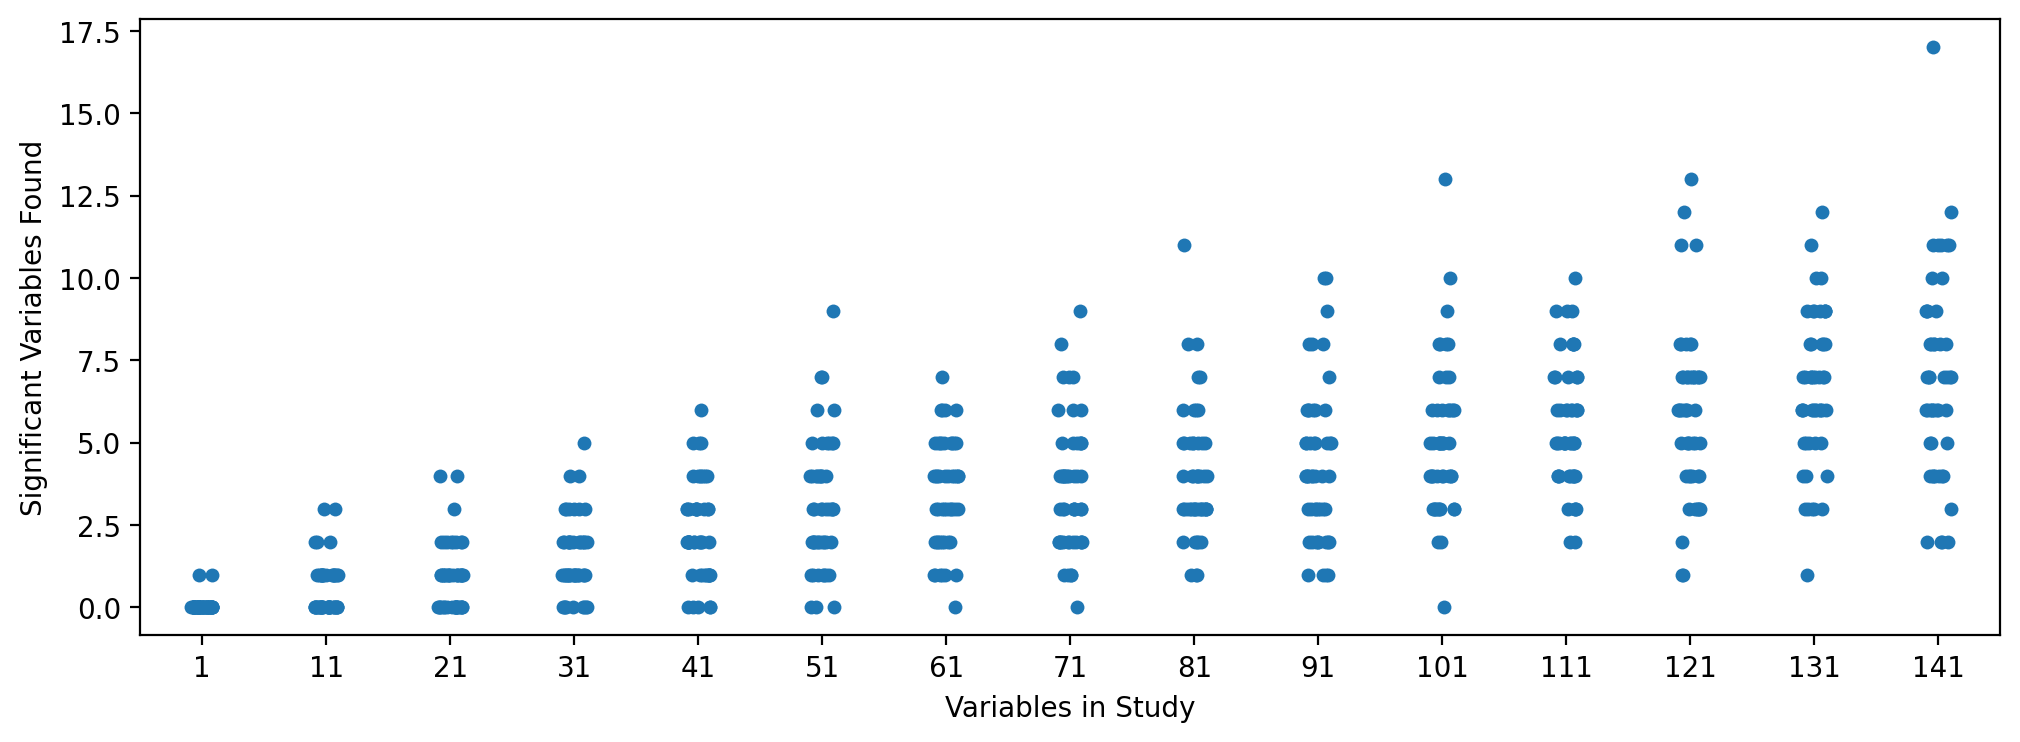

In [67]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
sns.stripplot(data=var_found_df, x='Variables in Study', y='Significant Variables Found');

### Visualize the results differently

The strip plot we just used gets cluttered when we have too many observations. A different way to show the results is to use a boxplot.

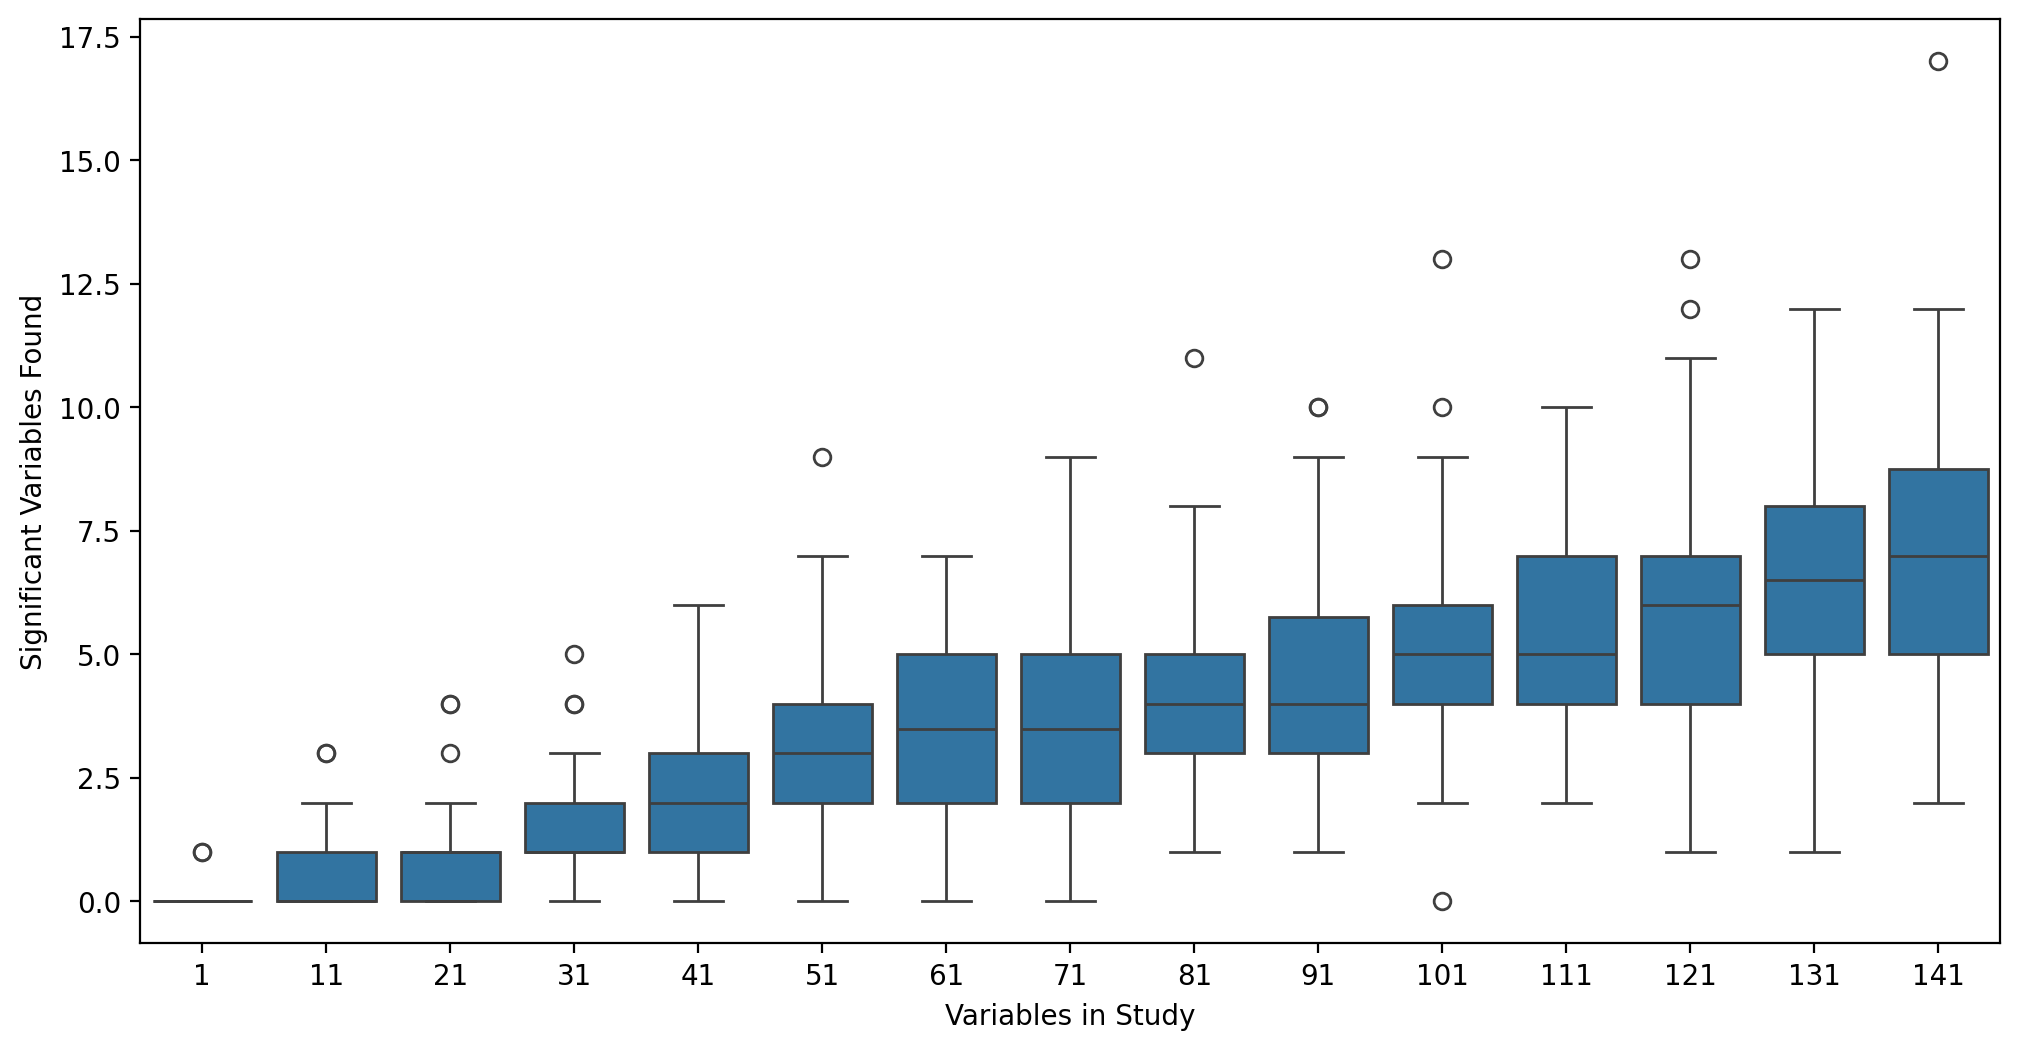

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(data=var_found_df,
            x='Variables in Study', y='Significant Variables Found');

## Multiple Testing Bias: Correction

We saw that increasing the number of tests also increases the probability of detection. This is missleading and needs to be corrected.

Using the simple correction factor (number of tests performed) as proposed by Bonferroni, we can make the significant findings constant again. 
$$ p_{\mbox{cutoff}} = \frac{0.05}{\textrm{Number of Tests}} $$

This comes from the familywise error 
$$\bar{\alpha}=1-\left(1-\alpha_{\mbox{per comparison}}\right)^m$$

where $m$ is the number of hypotheses tested. Then, with Boole's inequality we have

$$\bar{\alpha}\leq{} m\cdot \alpha_{\mbox{per comparison}}$$

Which leads to the Boniferroni correction.


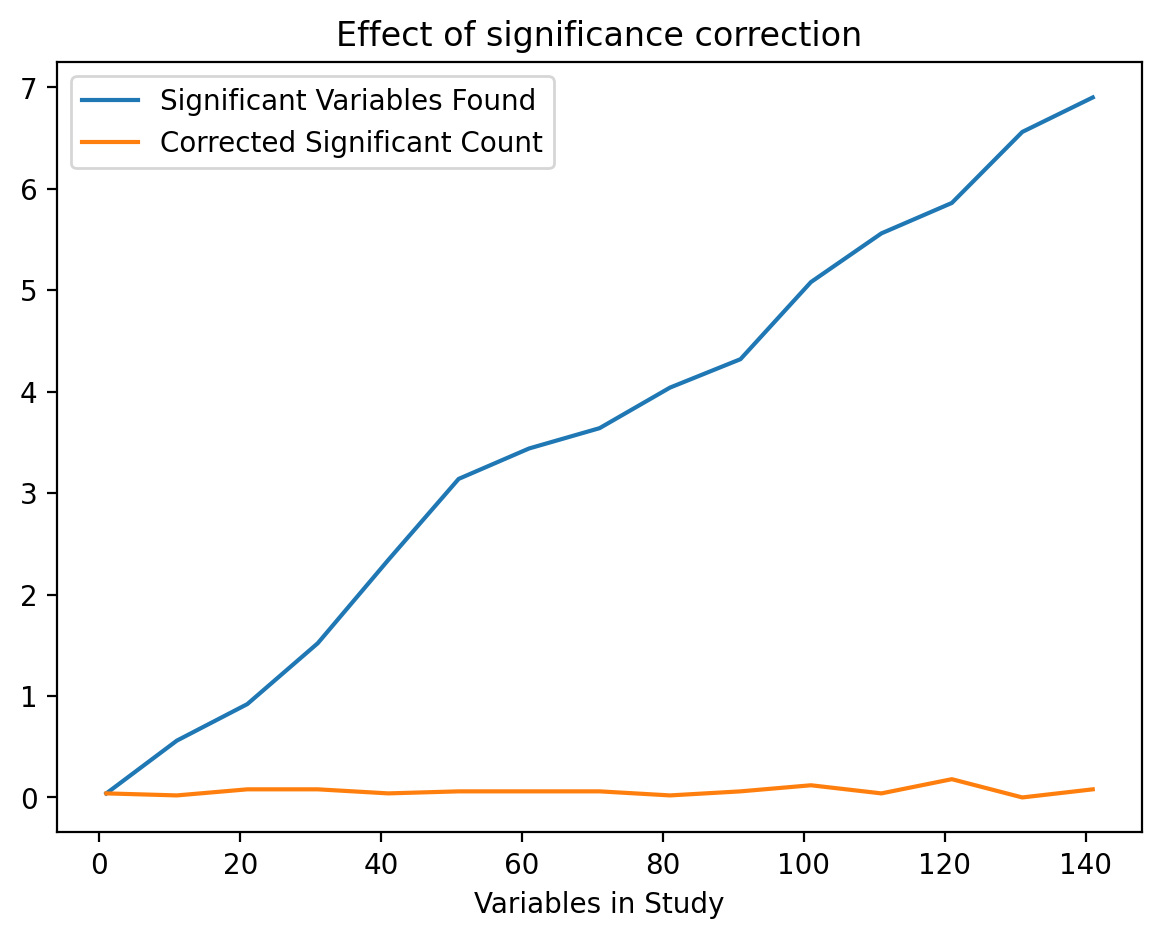

In [69]:
fig,ax=plt.subplots(1,figsize=(7,5))
var_found_df['Corrected Significant Count'] = var_found_df['raw_values'].map(lambda p_values: 
                                                                             np.sum(p_values<0.05/len(p_values)))
var_found_df.groupby('Variables in Study').agg({'Significant Variables Found':'mean','Corrected Significant Count':'mean'}).plot(ax=ax)
plt.title('Effect of significance correction');

### No free lunch

![](figures/Balance_ErrorTypes.png)

There is no free lunch. If you adjust your statistical threshold to obtain less Type I errors you'll have to take  the cost of increasting the number of Type II errors. This is the same as we have seen when thresholding images.

### Is this correction factor sufficient?
So no harm done there we just add this correction factor right?

Well, what if we have exactly one variable with shift of 1.0 standard deviations from the other. 

In a dataset where we check $n$ variables?

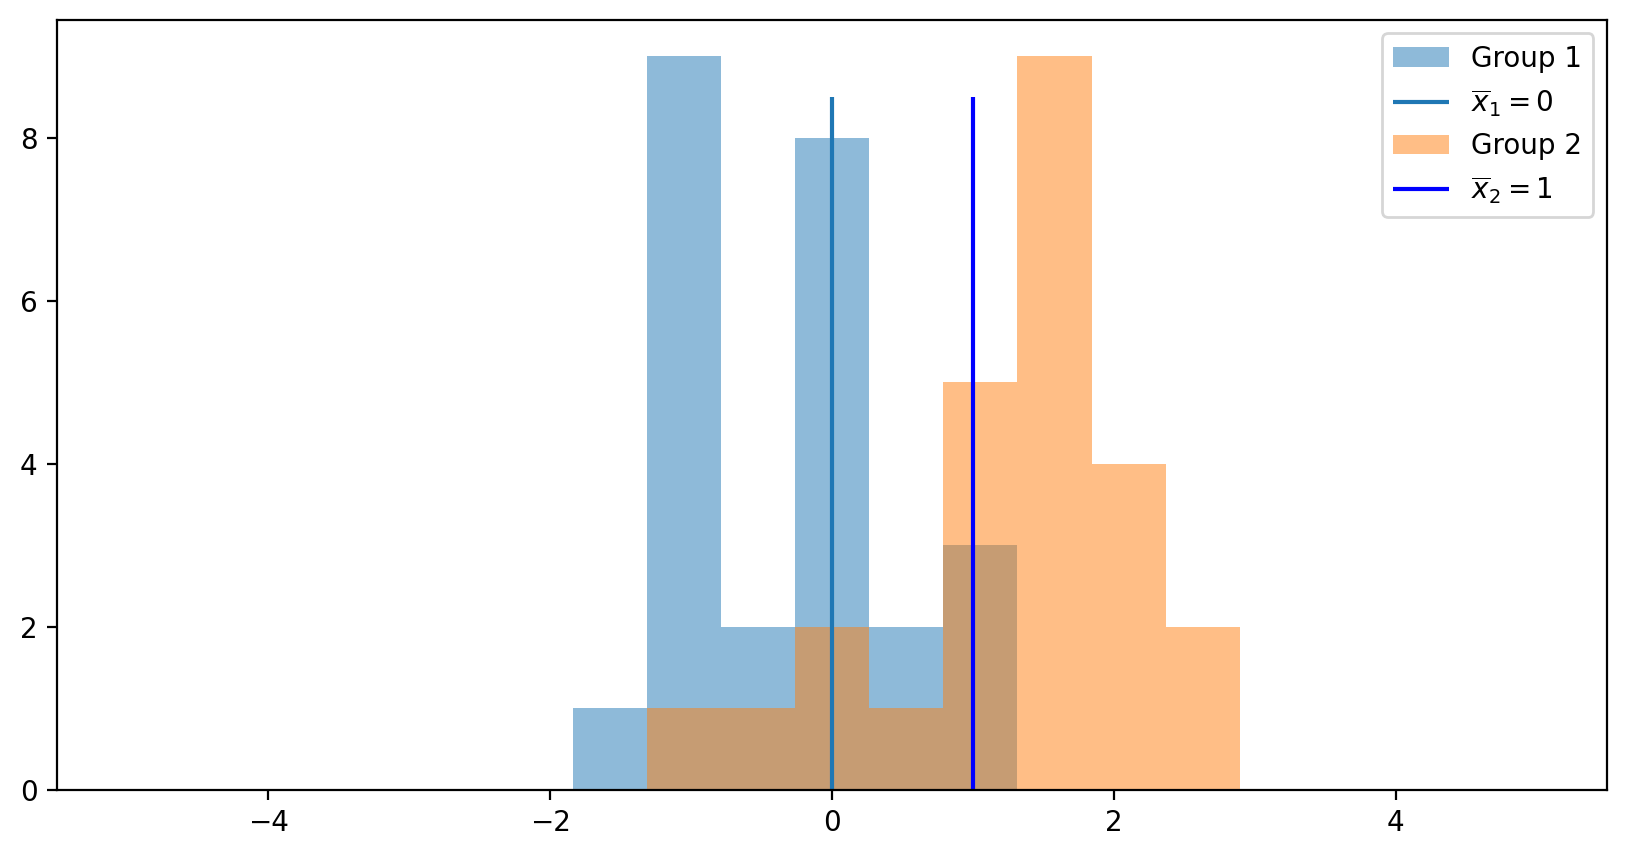

In [71]:
table_df = random_data_maker(50, 10)
really_different_var = np.concatenate([
    np.random.normal(loc=0, scale=1.0, size=(table_df.shape[0]//2)),
    np.random.normal(loc=1, scale=1.0, size=(table_df.shape[0]//2))
])
table_df['Really Different Var'] = really_different_var
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.hist(table_df.query('Group==1')['Really Different Var'], np.linspace(-5, 5, 20), label='Group 1', alpha=0.5);
ax1.vlines(0,ymin=0,ymax=8.5,label='$\overline{x}_1=0$')
ax1.hist(table_df.query('Group==2')['Really Different Var'], np.linspace(-5, 5, 20), label='Group 2', alpha=0.5);
ax1.vlines(1,ymin=0,ymax=8.5,color='blue',label='$\overline{x}_2=1$')
ax1.legend();

### Run many tests

We run 200 tests with two variables with $x \in \mathcal{N}(0,1)$ and $y \in \mathcal{N}(1,1)$ and compute the p-values for each test.

Using $\mathcal{H}_0$: $x=y$

In [72]:
out_p_value = []
for _ in range(200):
    out_p_value += [ttest_ind(np.random.normal(loc=0, scale=1.0, size=(table_df.shape[0]//2)),
          np.random.normal(loc=1, scale=1.0, size=(table_df.shape[0]//2))).pvalue]

When we look at the histograms of p-values scale by the number of variables in the test we see that there is a greater probability to accept the null-hypothesis.

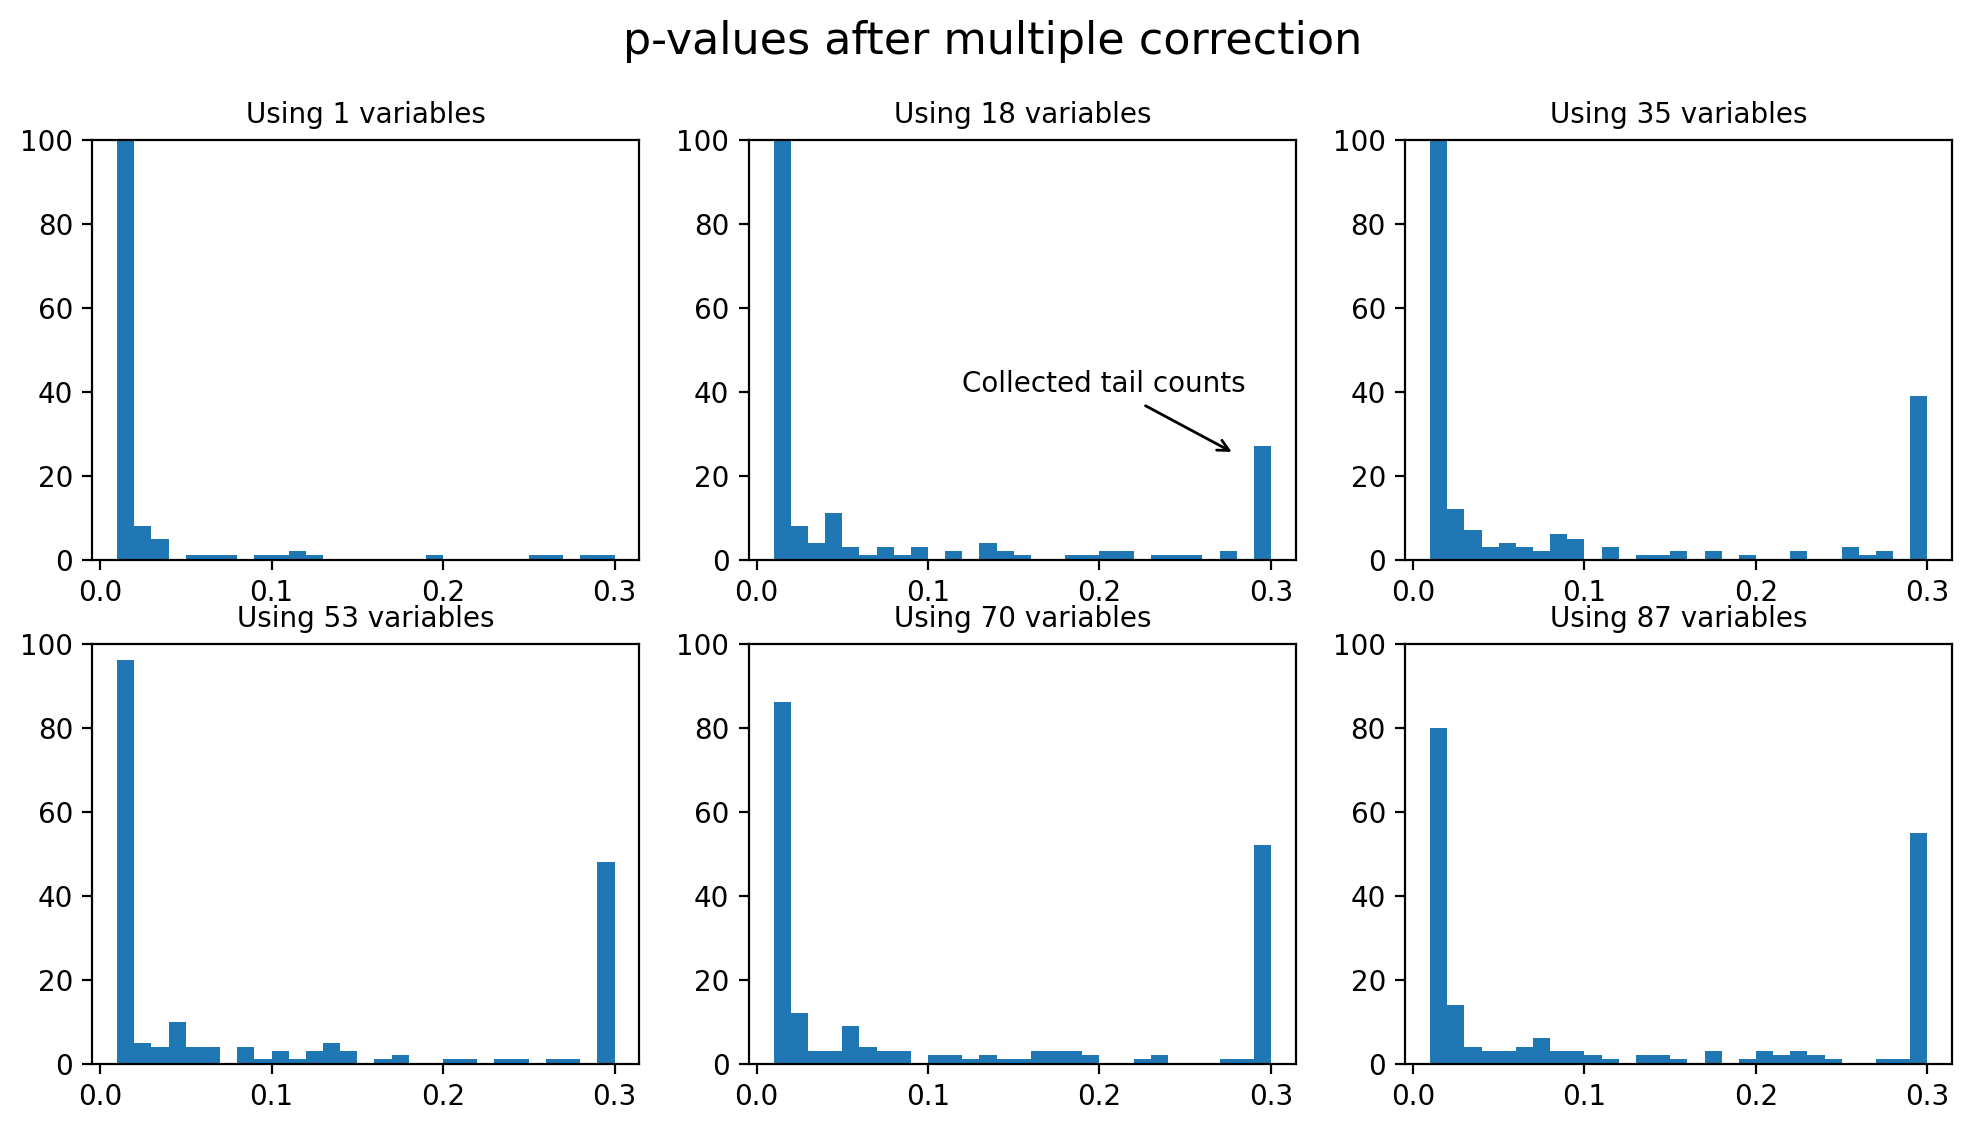

In [73]:
fig, m_axs = plt.subplots(2, 3, figsize=(12, 6))

for c_ax, var_count in zip(m_axs.flatten(), np.linspace(1, 140, 9).astype(int)):
    c_ax.hist(np.clip(np.array(out_p_value)*var_count, 0.01, 0.3), np.linspace(0.01, 0.3, 30))
    c_ax.set_ylim(0, 100)
    c_ax.set_title('Using {} variables'.format(var_count),fontsize=10)
    
plt.suptitle('p-values after multiple correction',fontsize=16)
m_axs[0,1].annotate("Collected tail counts", xy=(0.28, 25), xytext=(0.12, 40), arrowprops=dict(arrowstyle="->",color="black"),fontsize=10);

_Note_: Don't mind the peak on the right hand side of the histogram. It is there because we limited the interval of the histogram and all values beyond this limit are collected in this histgram bin.

### The likelihood to find a different variable

The scaling by the number of variables means that we are less likely to reject the null hypothesis. So, what is the likelihood?

We count the number of the p-values less than 0.05 to compute the likelihood of detecting a really different variable. 

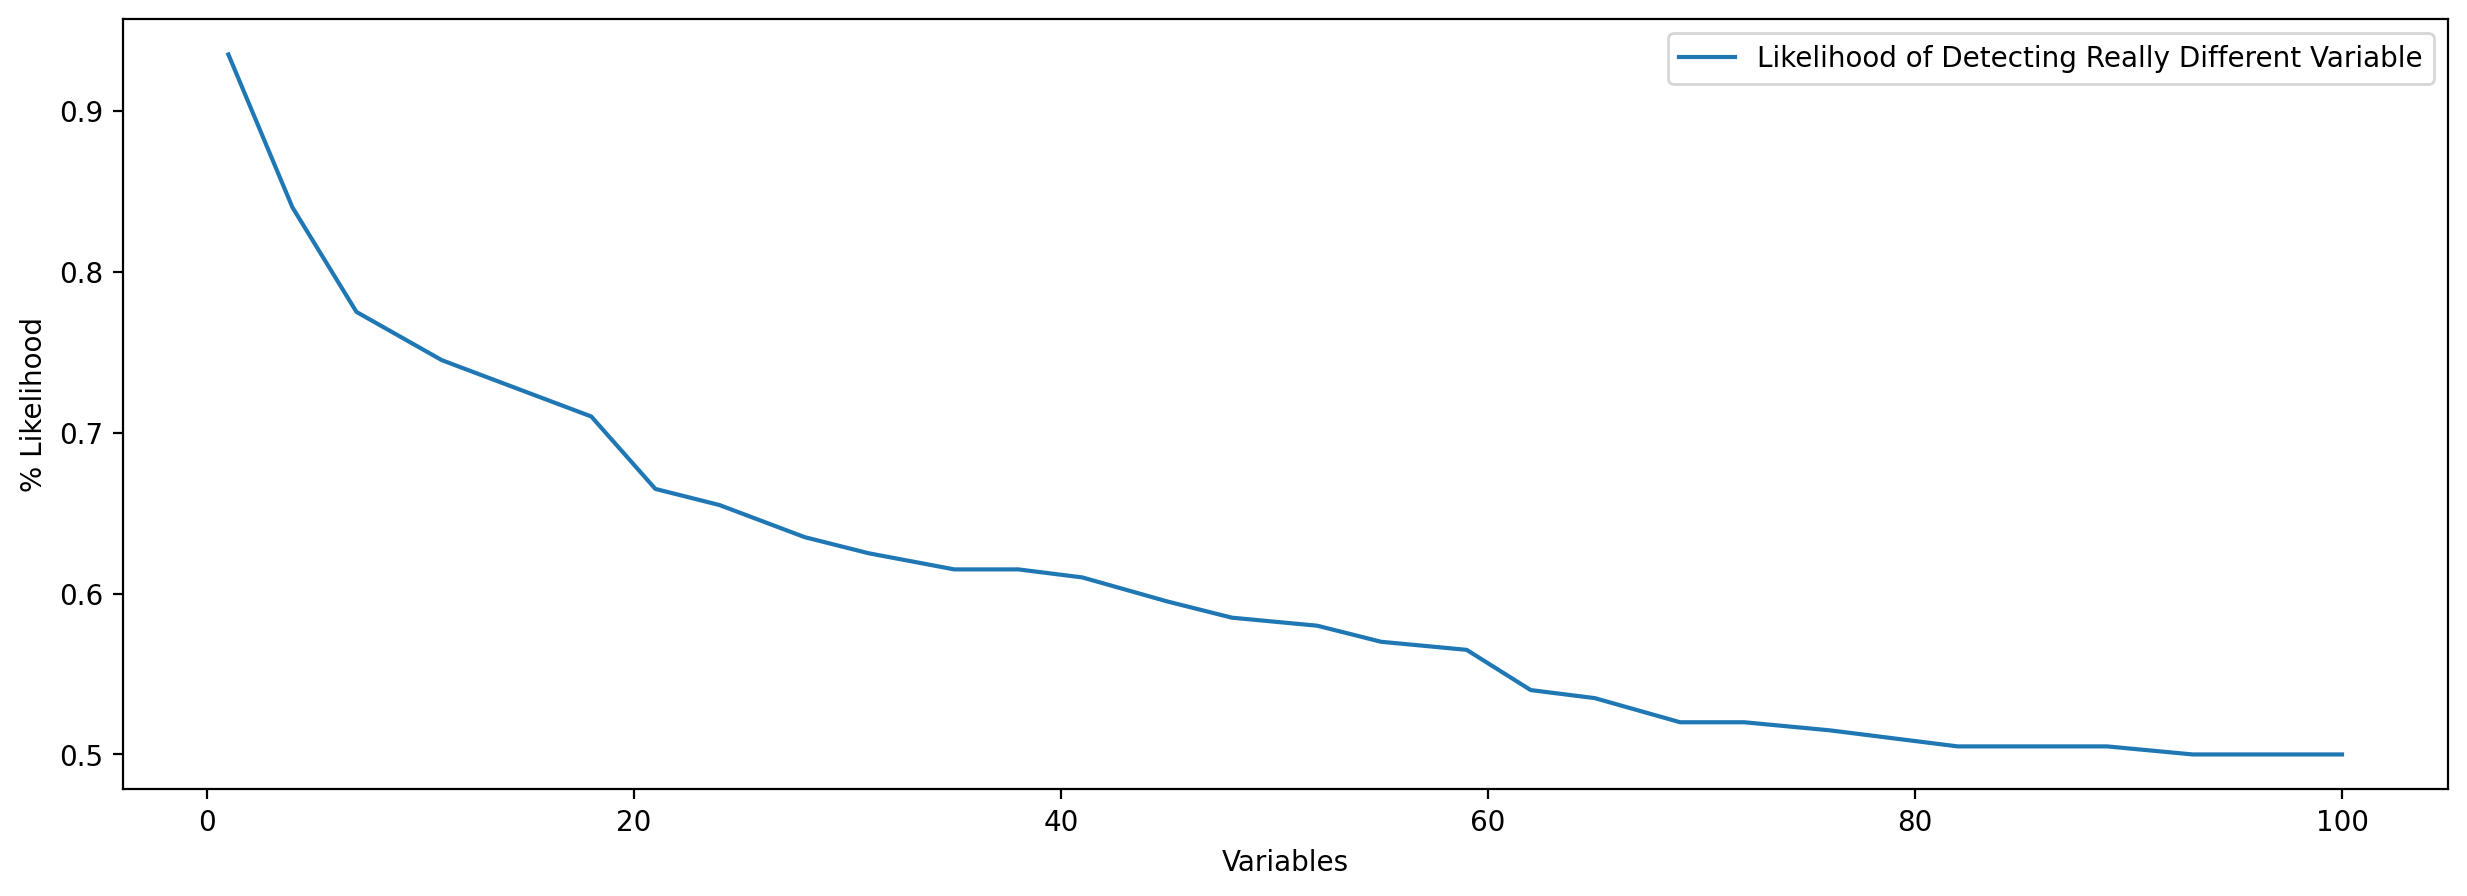

In [74]:
var_find_df = pd.DataFrame({'Variables': np.linspace(1, 100, 30).astype(int)})
var_find_df['Likelihood of Detecting Really Different Variable'] = var_find_df['Variables'].map(
    lambda var_count: np.mean(np.array(out_p_value)*var_count<0.05)
)
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
var_find_df.plot('Variables', 'Likelihood of Detecting Really Different Variable', ax=ax1)
ax1.set_ylabel('% Likelihood');

Here, we see that the likelihood is very low for many varibles. A reason in that we are working on a limited number of samples and split these on an incresing number of variables.

## A statistical study from images
### Setting the stage

We have a new treatment and want to compare cell cultures

<div class="row">
<div class="column13">
    <center><h2>Microscope image</h2><img src="figures/Microscope-image-of-mature-yeast-culture.jpg"></center>
    
[Volkov 2015](http://dx.doi.org/10.3389/fpls.2015.00425)
</div>
<div class="column13">
    <center><h2>Control</h2><img src="figures/np_petri-dish_375820_0433FF.png"></center>
</div>
<div class="column13">
    <center><h2>Treatment</h2><img src="figures/np_petri-dish_375820_FF2600.png"></center>
</div>
</div>

Are they different?

#### Recap from previous lectures
We saw that a cell culture can be reduced to a point cloud
- Segmentation
- Labelling
- Region properties
- Voronoi tesselation
- Area distribution 

### Point clouds to compare
In our test we generate two types of point clouds

In [75]:
intensity_control = 5.5
intensity_treatment = 6.0

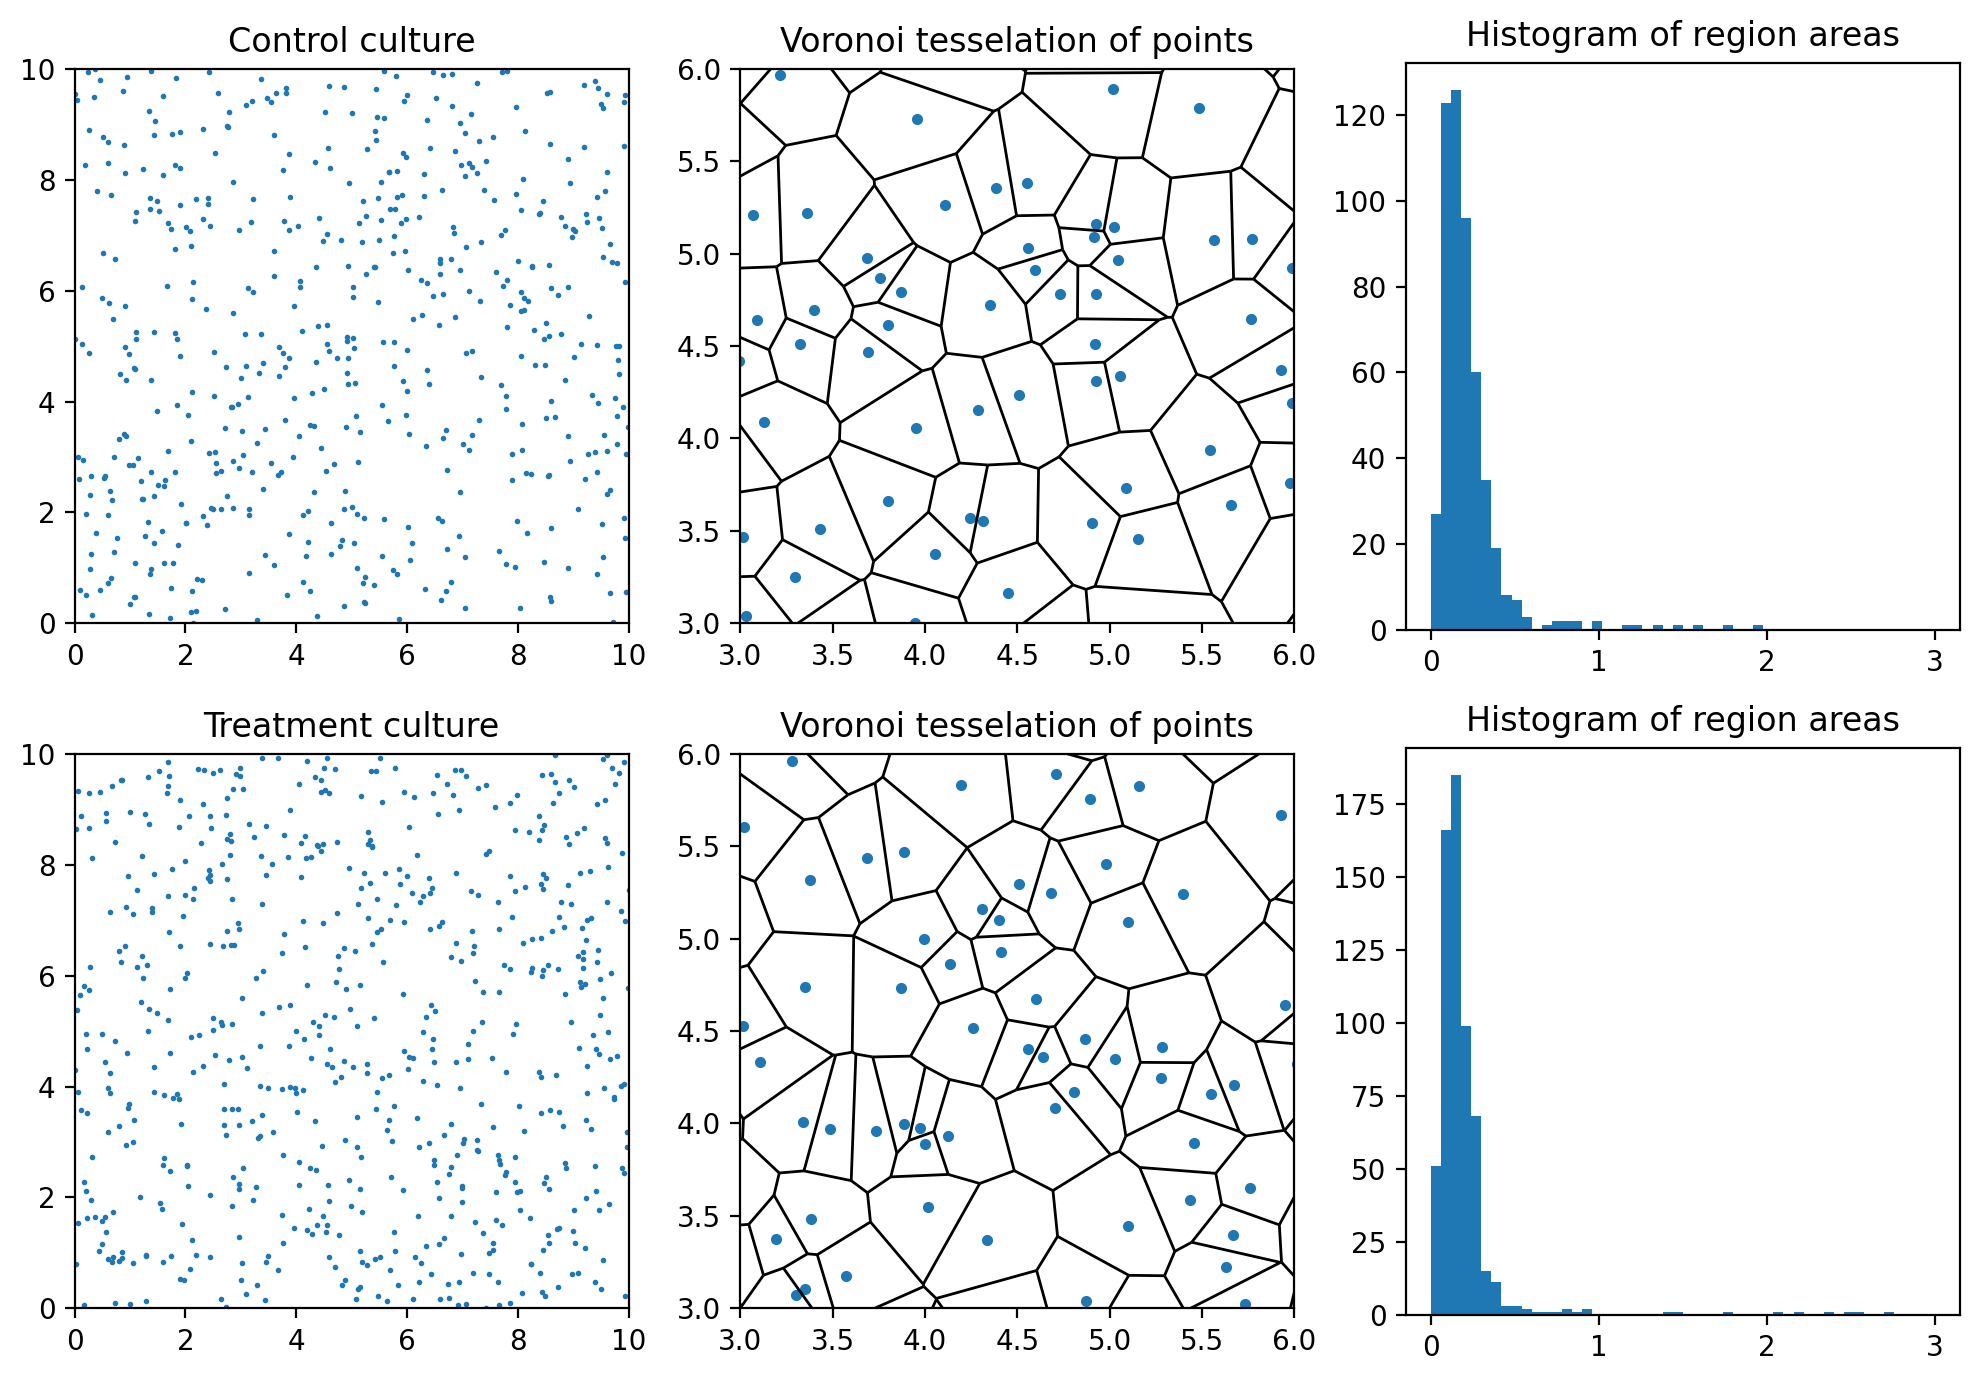

In [76]:
importlib.reload(pc)

fig,ax = plt.subplots(2,3,figsize=(10,7))  
dpoints=pc.point_field(intensity=intensity_control,ax=ax[0,0],title='Control culture',seed=100,plot=True)
lpoints=pc.point_field(intensity=intensity_treatment,ax=ax[1,0], title='Treatment culture',seed=200,plot=True)

from scipy.spatial import Voronoi, voronoi_plot_2d
dvor = Voronoi(dpoints)
dA=pc.compute_region_areas(dvor)
dA = dA[~np.isnan(dA)]
# dA=dA[dA<1.5]

lims = [3,6]
voronoi_plot_2d(dvor,show_points=True, show_vertices=False,ax=ax[0,1])
ax[0,1].set_aspect('equal')
ax[0,1].set_xlim(lims)
ax[0,1].set_ylim(lims)
ax[0,1].set_title('Voronoi tesselation of points')

ax[0,2].hist(dA,range=[0,3],bins=50);
ax[0,2].set_title('Histogram of region areas')

lvor = Voronoi(lpoints)
lA=pc.compute_region_areas(lvor)
lA = lA[~np.isnan(lA)]
# lA=lA[lA<1.5]
voronoi_plot_2d(lvor,show_points=True, show_vertices=False,ax=ax[1,1])
ax[1,1].set_aspect('equal')
ax[1,1].set_xlim(lims)
ax[1,1].set_ylim(lims)
ax[1,1].set_title('Voronoi tesselation of points')

ax[1,2].hist(lA,range=[0,3],bins=50);
ax[1,2].set_title('Histogram of region areas')
plt.tight_layout()

## Comparing samples

### Use the ICC to compare two samples

In [77]:
importlib.reload(pc)
m=np.array([lA.mean(),dA.mean()])
s=np.array([lA.std(),dA.std()])

pc.icc(m,s)

0.0032644209639845424

#### Not very separated

With a ICC of this magnitude we can conclude that the two cultures are not differing very much. Let's see what our hypothesis testing tells us. This can naturally also be confirmed by looking at the histograms; they are more or less overlapping.

### Can the t-test help us?

Let's try the t-test on the region areas 

$\mathcal{H}_0$: There is no difference between the cultures in the region area

In [78]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(dA, lA, equal_var=False)

print(f"p-value: {p_value:.4f}")

p-value: 0.1635


We confirm the null-hypothesis that there is no difference between the two samples.

#### Outliers biasing the hypothesis test
We observe that there are some extreme outliers in the data. Let's prune...

In [79]:
lAc=lA[lA<2]
dAc=dA[dA<2]

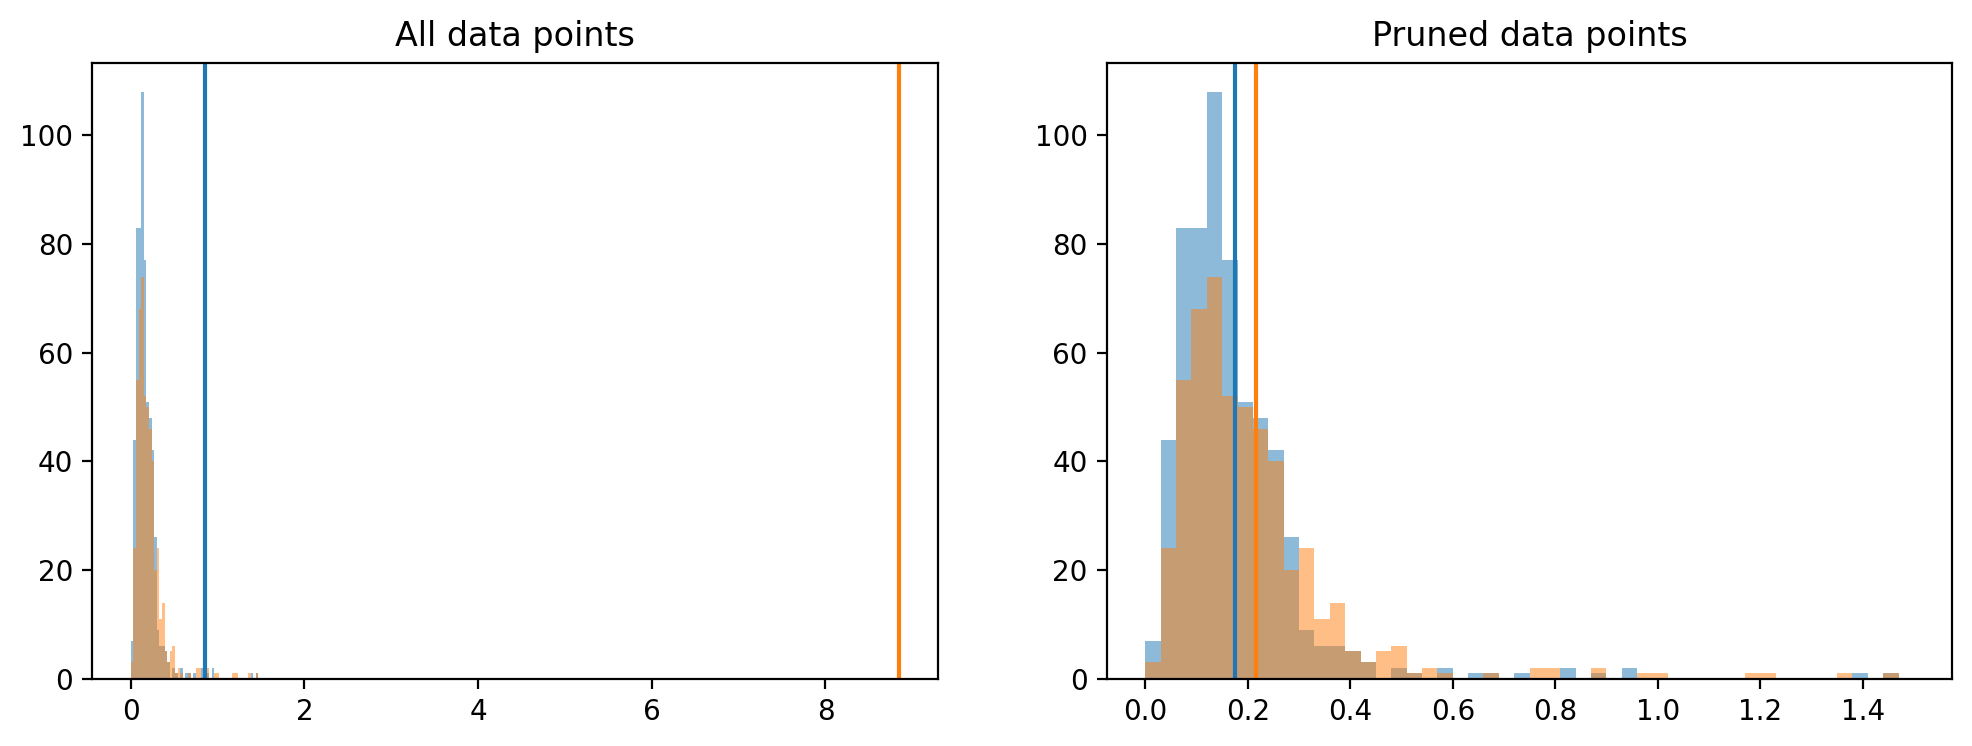

In [80]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].hist(lA,range=[0,1.5],bins=50,alpha=0.5);
ax[0].axvline(np.mean(lA),color=dcolors[0])
ax[0].hist(dA,range=[0,1.5],bins=50,alpha=0.5);
ax[0].axvline(np.mean(dA),color=dcolors[1]);
ax[0].set_title('All data points')

ax[1].hist(lAc,range=[0,1.5],bins=50,alpha=0.5);
ax[1].axvline(np.mean(lAc),color=dcolors[0])
ax[1].hist(dAc,range=[0,1.5],bins=50,alpha=0.5);
ax[1].axvline(np.mean(dAc),color=dcolors[1]);
ax[1].set_title('Pruned data points');

In [81]:
stat, p_value = ttest_ind(dAc, lAc, equal_var=False)

print(f"p-value: {p_value:.4f}")

p-value: 0.0001


#### What’s Really Happening?

Outliers increase variance, and the t-test depends on the ratio:

$$
\displaystyle
t=\frac{\text{difference in means}}{\text{pooled standard error}}
$$
 
→ Higher variance → larger denominator → smaller t → higher p-value

So outliers can dilute the test’s power and hide real effects.

#### Key Takeaway
Outliers can obscure true group differences. But you shouldn’t blindly remove them — it depends on context. In this particular case we know that voronoi regions at the boundary are infinite of very large. What we should have done here is to crop the regions at the image boundary. The cropping would of course also introduce an error. So, it is important to decide wether you can accept reducing the number of points or if the cropping is acceptable. 

### The Kolmogorov-Smirnov test

In statistics, the Kolmogorov–Smirnov test (also K–S test or KS test) is a nonparametric test of the equality of continuous one-dimensional probability distributions. 

It can be used to test whether 
- a sample came from a given reference probability distribution (one-sample K–S test), or
- two samples came from the same distribution (two-sample K–S test)

Intuitively, it provides a method to answer the question "How likely is it that we would see a collection of samples like this if they were drawn from that probability distribution?" or, in the second case, "How likely is it that we would see two sets of samples like this if they were drawn from the same (but unknown) probability distribution?"

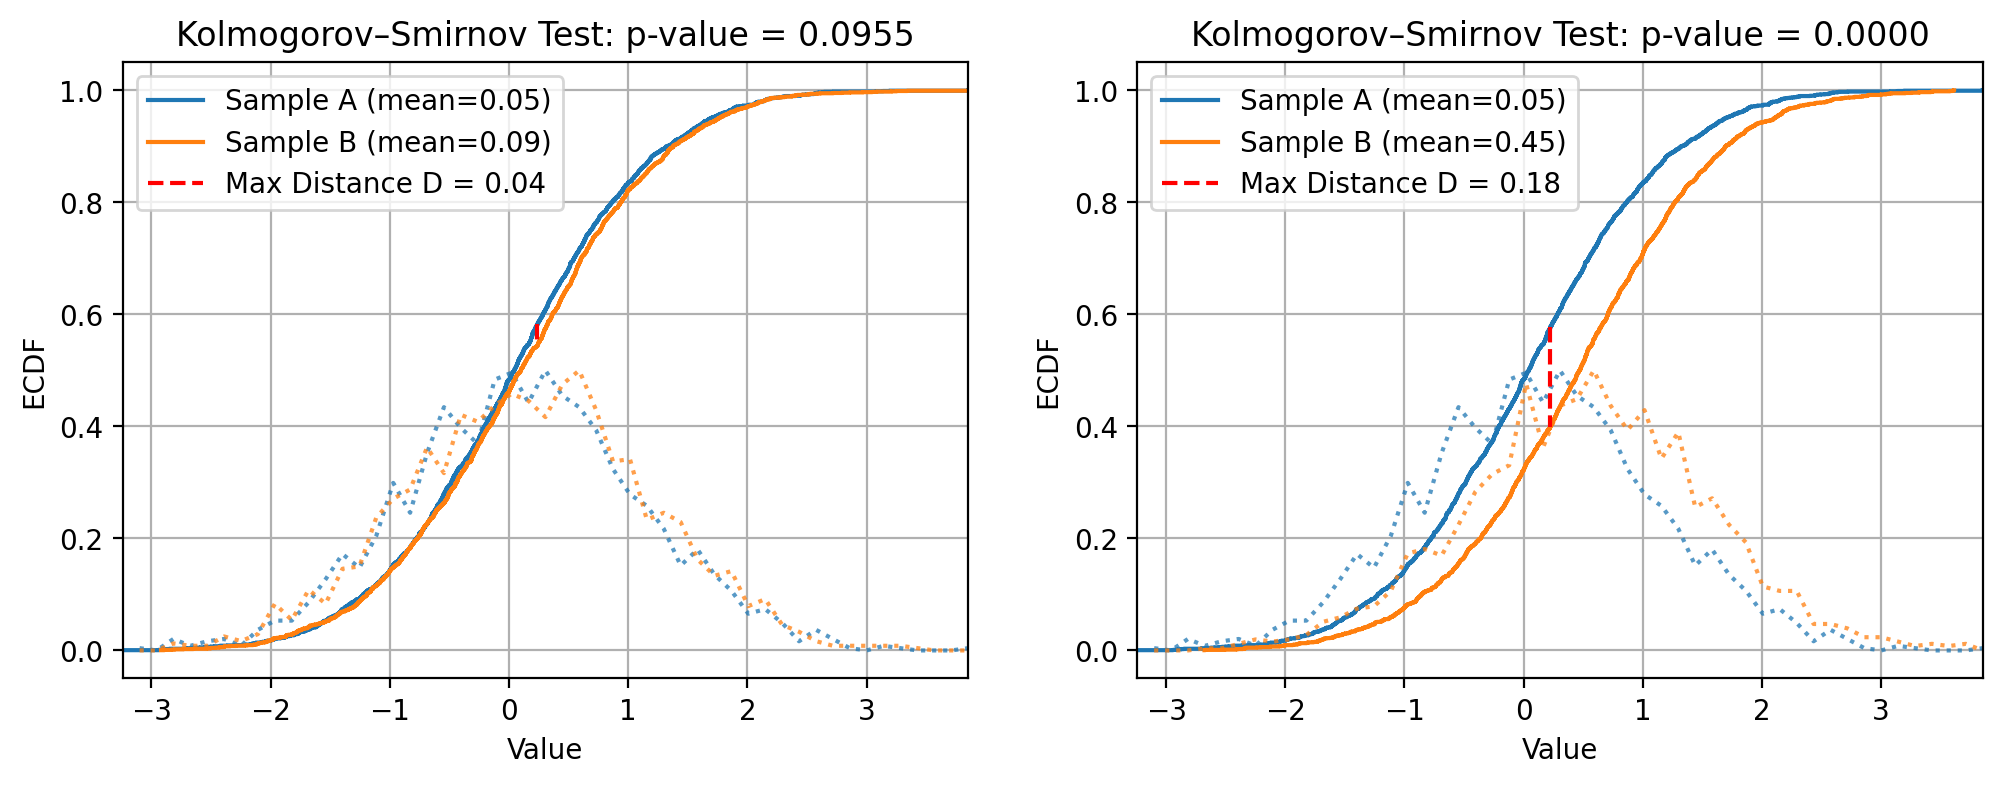

In [82]:
importlib.reload(pc)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Generate two synthetic samples
np.random.seed(42)
N=2000
sample_A = np.random.normal(0, 1, N)
sample_B = np.random.normal(0.1, 1, N)  # Shifted mean
sample_C = np.random.normal(0.5, 1, N)  # Shifted mean

fig,ax = plt.subplots(1,2,figsize=(12,4))

pc.plot_ks_test(sample_A,sample_B,ax[0])
pc.plot_ks_test(sample_A,sample_C,ax[1])

### Use the KS test to compare two cultures

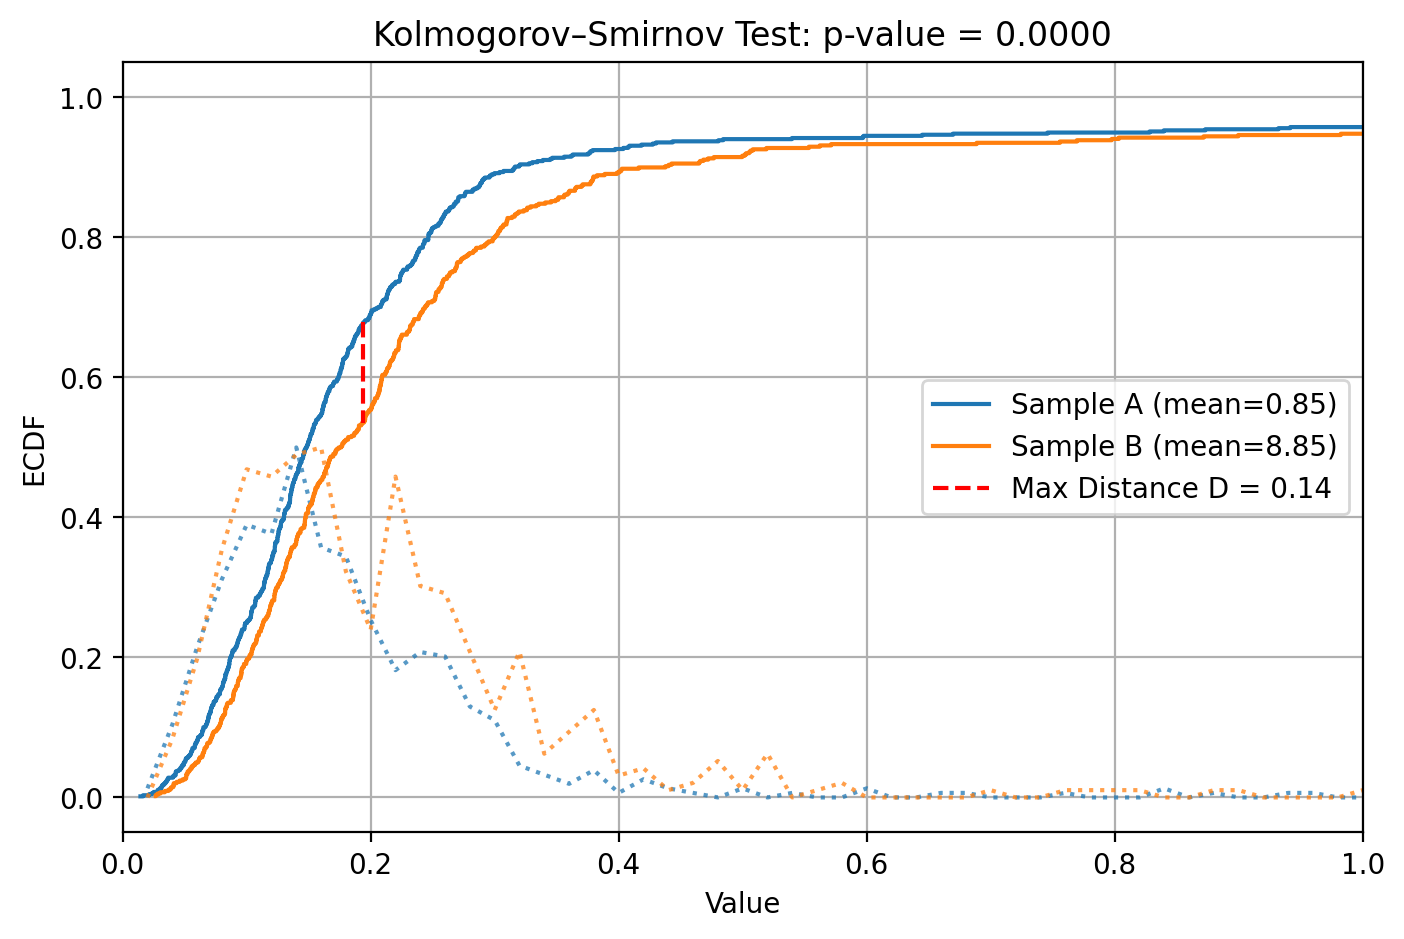

In [83]:
pc.plot_ks_test(lA,dA,xlim=[0,1])

## Comparing treatments

Comparing one sample from each treatment is not sufficient
- There are natural variations in each sample
- The test outcome relies on luck like tossing a coin

A scientific requires many samples from each treatment.

Revise our hypothesis:
$\mathcal{H}_0$: Do treatment A and treatment B produce systematically different spatial patterns across replicates

But this time increase the population

### Produce data for the example

We generate two populations
- Gaussian distribution of the sample point intensity
- 10 samples in each population

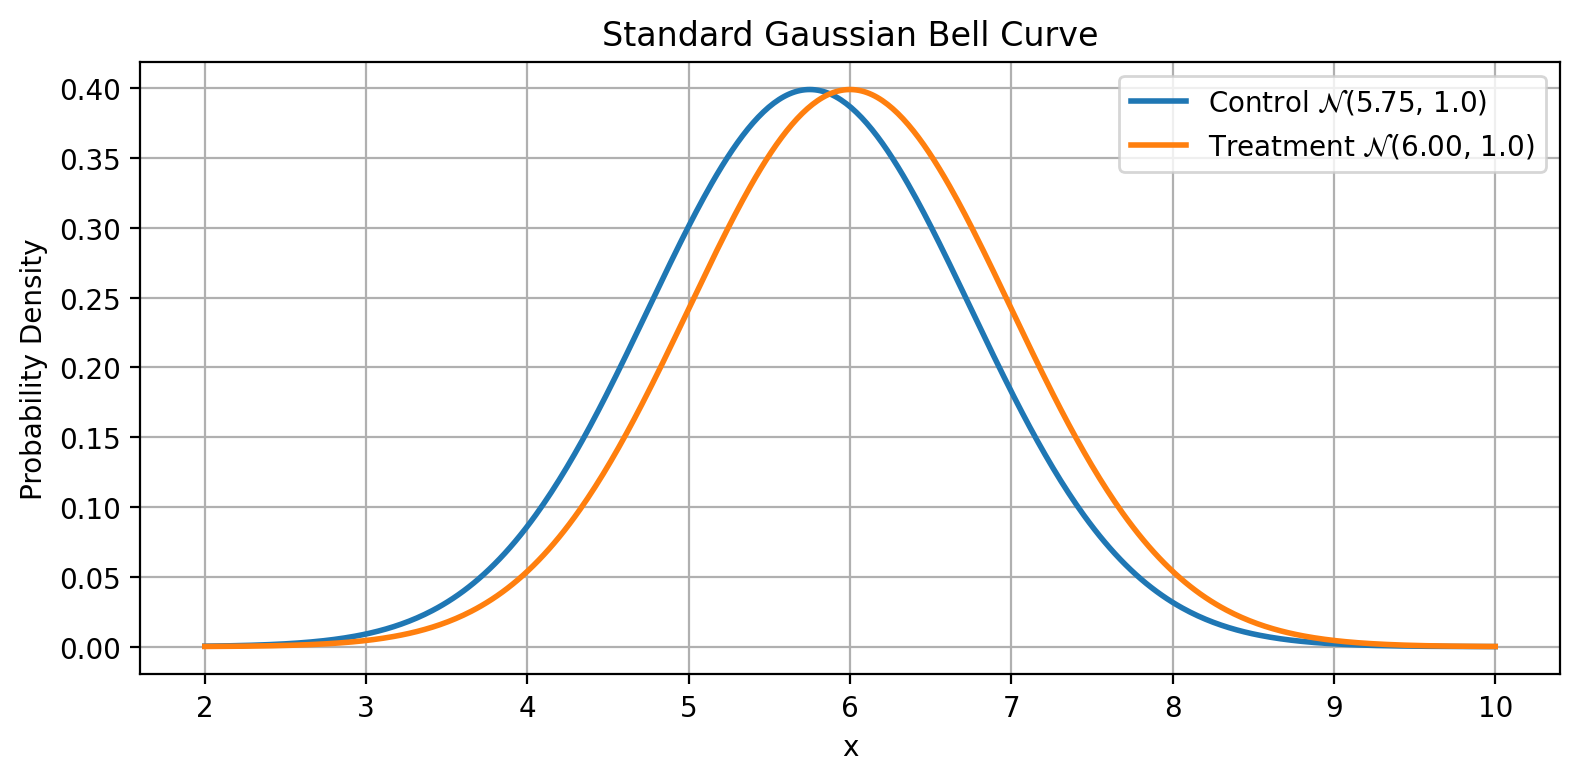

In [84]:
from scipy.stats import norm

# Define range and parameters
x = np.linspace(2, 10, 500)
mu = [5.75, 6]      # Mean
sigma = [1,1]   # Standard deviation

# Compute Gaussian PDF
y0 = norm.pdf(x, mu[0], sigma[0])
y1 = norm.pdf(x, mu[1], sigma[1])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, y0, label=r'Control $\mathcal{N}$('+'{0:0.2f}, {1:0.1f})'.format(mu[0],sigma[0]), lw=2)
plt.plot(x, y1, label=r'Treatment $\mathcal{N}$'+'({0:0.2f}, {1:0.1f})'.format(mu[1],sigma[1]), lw=2)
plt.title('Standard Gaussian Bell Curve')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.tight_layout()

Can we separate them using the area of the Voronoi regions?

### Perform the experiment 

We don't have experiment data here. So, we generate the points with random generators
1. Generate the point clouds
2. Compute Voronoi region areas

In [85]:
importlib.reload(pc)
nSamples = 10
np.random.seed(seed=42)
samples_control   = np.random.normal(5.75, 1, size=nSamples) 
samples_treatment = np.random.normal(6.0, 1, size=nSamples)
width, height = 10,10
threshold=1.5

A_control,p_control     = pc.compute_area_in_samples(samples_control, width=width,height=height,threshold=threshold)
A_treatment,p_treatment = pc.compute_area_in_samples(samples_treatment, width=width,height=height,threshold=threshold)

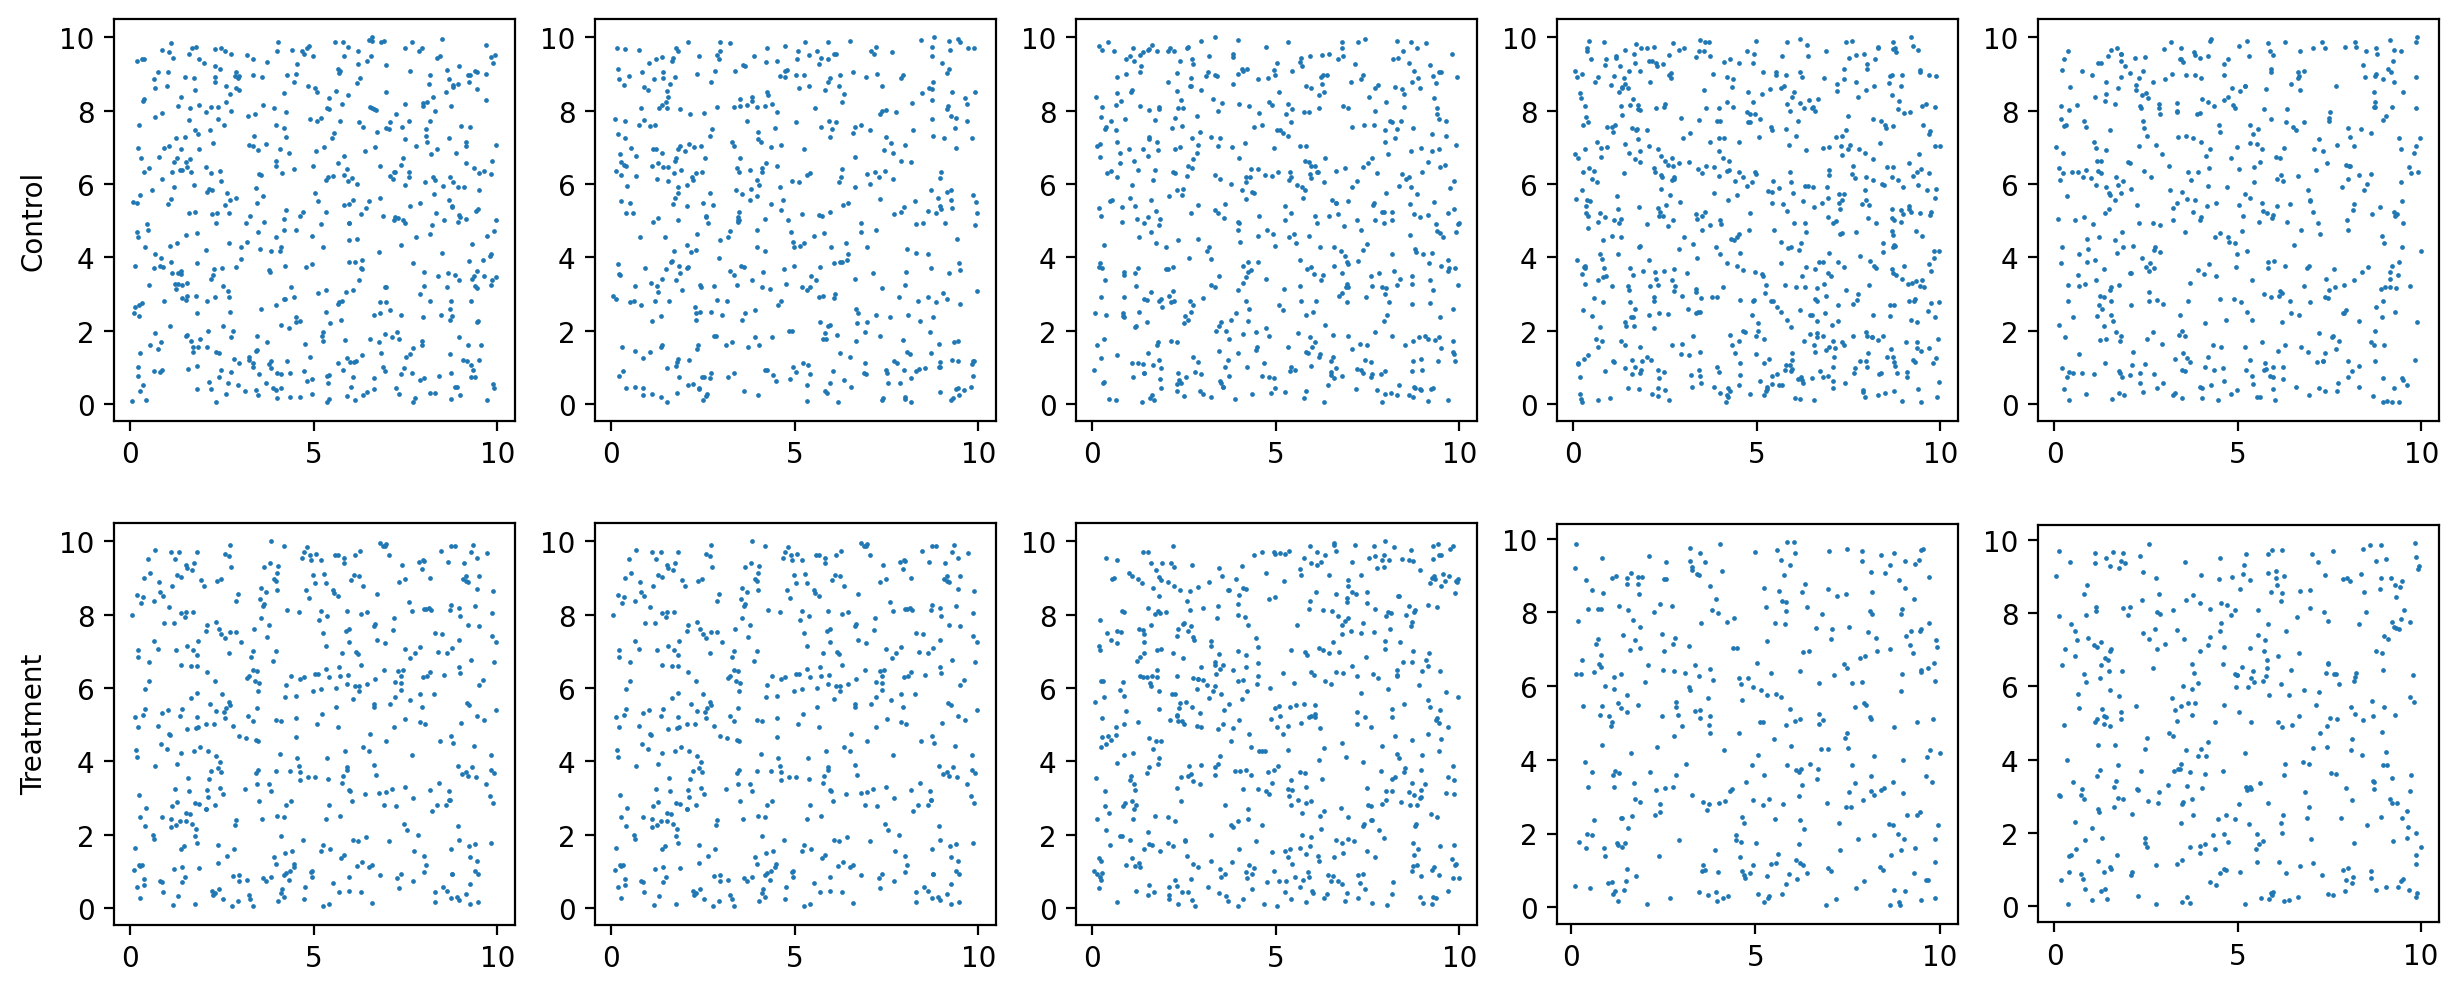

In [86]:
nPanels = 5
fig,axes=plt.subplots(2,nPanels,figsize=(15,6))

for ax,p in zip(axes[0],p_control[:nPanels]) :
    ax.scatter(p[:,1],p[:,0],s=0.5)
    ax.set_aspect('equal')
    
axes[0,0].set_ylabel('Control')
    
for ax,p in zip(axes[1],p_treatment[:nPanels]) :
    ax.scatter(p[:,1],p[:,0],s=0.5)
    ax.set_aspect('equal')

axes[1,0].set_ylabel('Treatment');

### Compare the populations

In [87]:
stat_func = np.mean
avg_control   = np.array([stat_func(s) for s in A_control])
avg_treatment = np.array([stat_func(s) for s in A_treatment])

stat, p_value = ttest_ind(avg_control, avg_treatment, equal_var=False)

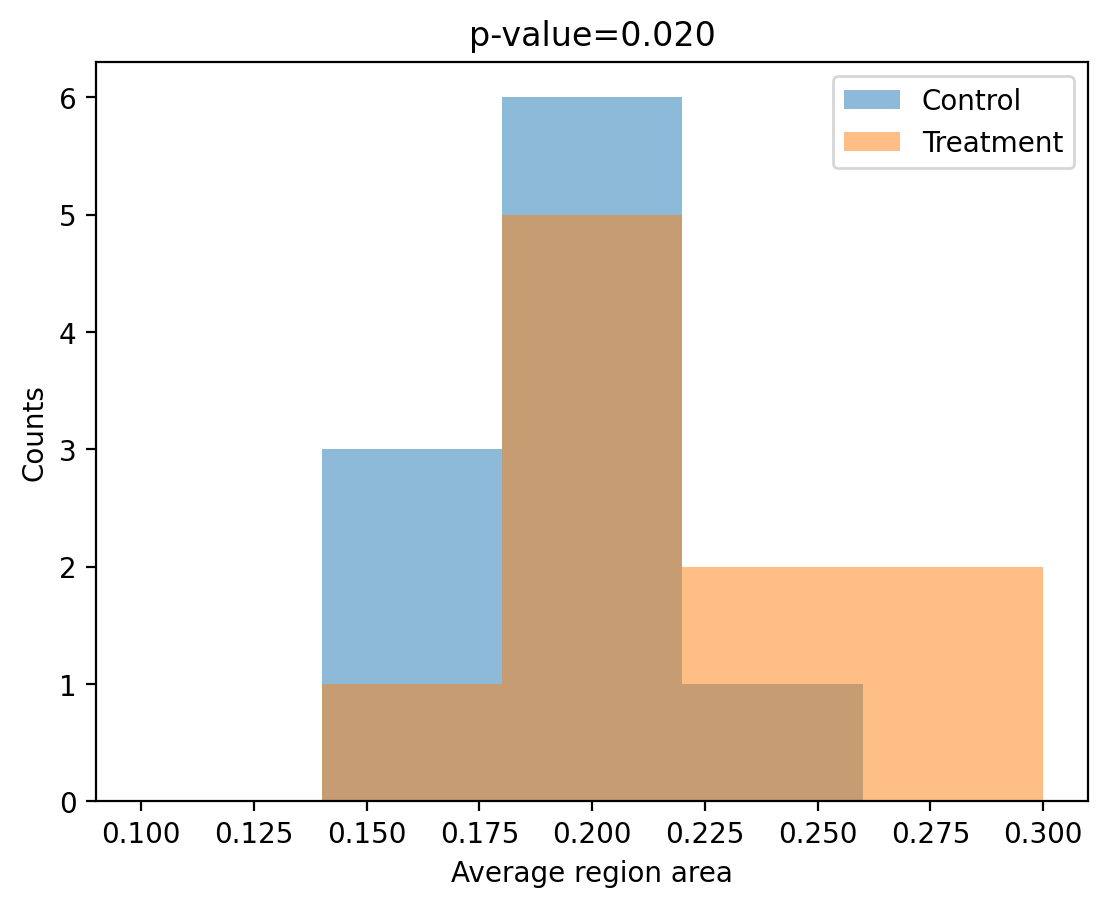

In [88]:
nBins = 5
plt.hist(avg_control,bins=nBins,alpha=0.5,range=[0.1,0.3], label='Control')
plt.hist(avg_treatment,bins=nBins,alpha=0.5,range=[0.1,0.3], label='Treatment');
plt.xlabel('Average region area')
plt.ylabel('Counts');
plt.legend()
plt.title('p-value={0:0.3f}'.format(p_value));

__Conclusion:__ given the data our t-test tells us to reject the null-hypothesis since the p-value is <0.05.

### Let's try the KS test

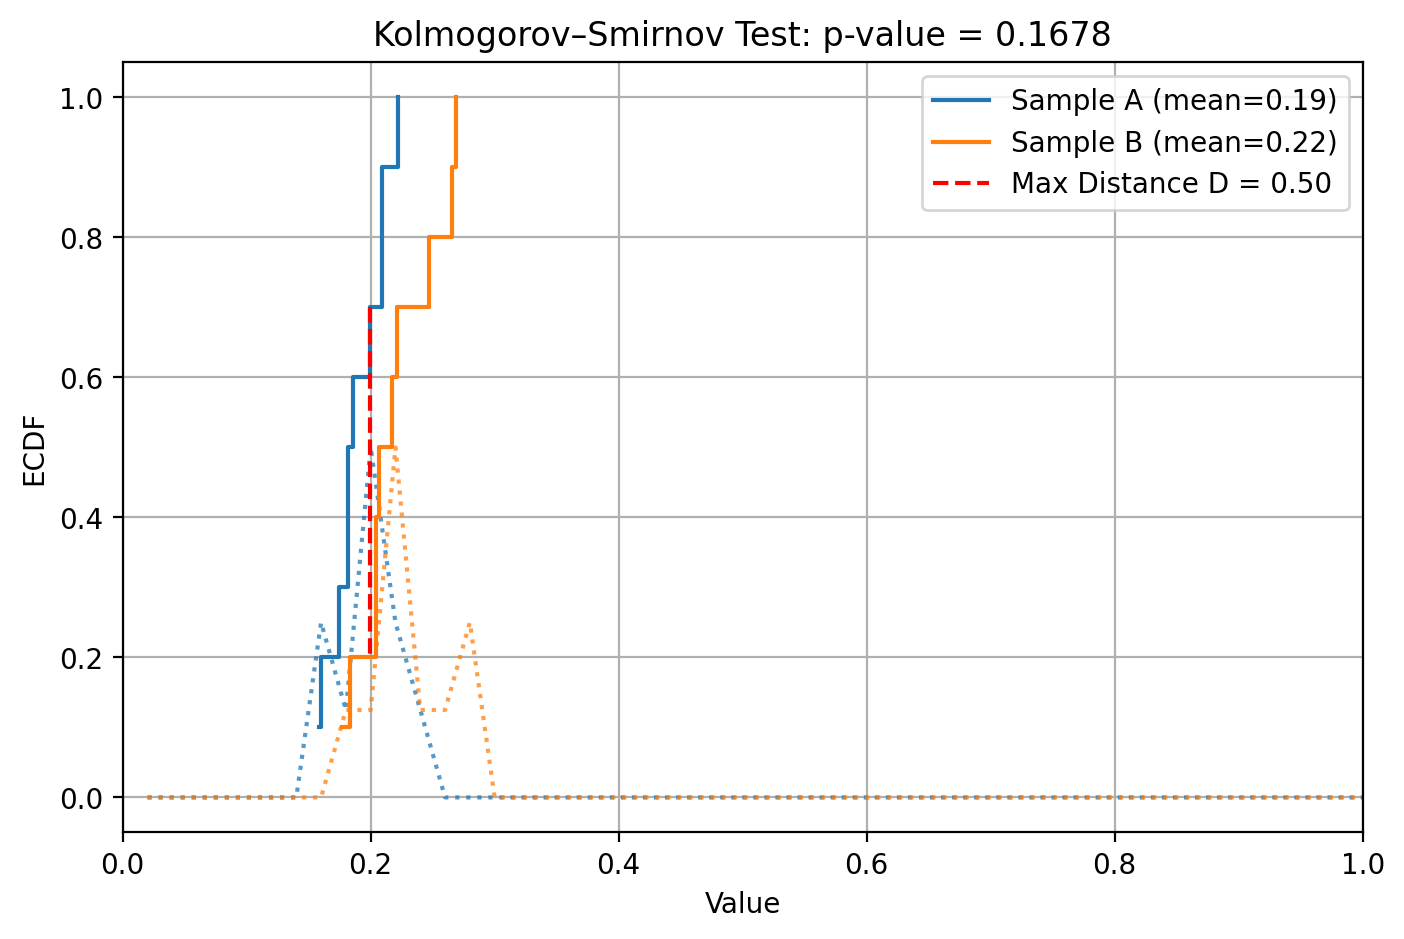

In [89]:
pc.plot_ks_test(avg_control,avg_treatment,xlim=[0,1])

This test confirms the null-hypothesis... why?

#### When is the KS-test reliable?

We saw in this example that the KS-test delivered a very different p-value compared with the t-test. The following table shows when it makes sense to use the KS-test. In our case we only had ten samples to compare.

| Sample Size | Suitability for KS Test |
|---|:--|
|< 20|Use with caution; very low power|
|20–50|Can work for large or obvious differences|
|≥ 50|Reasonable reliability for moderate differences|
|≥ 100|Good power and reliable p-values|
|≥ 1000|Very sensitive — may detect tiny, even irrelevant differences|


### How many samples are needed

The confidence in the test increases with the sample size...

... but
- Sample preparation
- Experiment
- Processing 
are expensive

For the current experiment, we get:

<center><img src='figures/samples_vs_pvals.png' style="height:400px"/><center>

```{figure} figures/samples_vs_pvals.png
---
scale: 100%
---
p-values for different sample size.
```

The plot show that the p-value generally decreases with inceasing number of samples in the test. The peak at 20 samples is an unfortunate coincidence due to insufficient test runs with the random generator.

The number of required samples also depends of the distribution of the data. You need less data for well separated samples $|\mu_0-\mu_1|>>\sigma$ than when there is great overlap.

## Conclusions from the statistical analysis

- We often have too little information for perfect analysis
- Student T-tests help
- Reject Null hypothesis on a specified confidence level
- Repeated measurements should be used 
- Correction is needed to avoid biasing in the conclusion

# Sensitivity to analysis parameters
We have a workflow to analyze _shape_ and _thickness_ of items in an image:

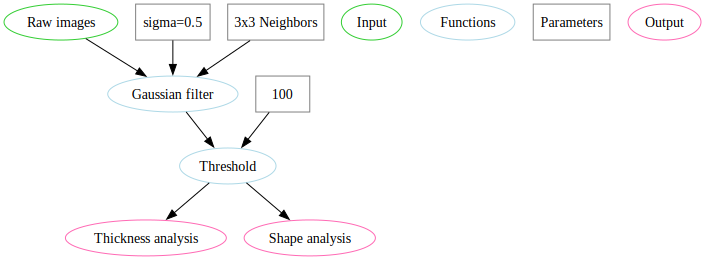

In [90]:
from graphviz import Digraph

dot = Digraph()

dot.node('Raw images',color='limegreen'),        dot.node('Gaussian filter', color='lightblue')
dot.node('sigma=0.5', color='gray',shape='box'), dot.node('3x3 Neighbors', color='gray',shape='box')
dot.node('Threshold', color='lightblue'),        dot.node('100', color='gray',shape='box')
dot.node('Thickness analysis',color='hotpink'),  dot.node('Shape analysis',color='hotpink')
dot.node('Input',color='limegreen'),        dot.node('Functions', color='lightblue')
dot.node('Parameters', color='gray',shape='box'),dot.node('Output',color='hotpink')

dot.edge('Raw images', 'Gaussian filter'),    dot.edge('sigma=0.5', 'Gaussian filter')
dot.edge('3x3 Neighbors', 'Gaussian filter'), dot.edge('Gaussian filter','Threshold')
dot.edge('Threshold', 'Thickness analysis'),  dot.edge('Threshold', 'Shape analysis')
dot.edge('100','Threshold')
dot

Three parameters can be controlled:
- Gaussian filter: $\sigma$ and _neighborhood size_
- Threshold level

### Parameter Sweep

The way we do this is usually a parameter sweep which means 
- taking one (or more) parameters 
- and varying them between the reasonable bounds (judged qualitatively).

<img src="figures/parameter_sweep.png" style="height:400px"/>

The outcome of a parameter sweep can look like in the figure below.
```{figure} figures/parameter_sweep.png
---
scale: 50%
name: fig_parametersweep
---
Volume measurements for different thresholds
```
We can see that the volume is generally decreasing when the threshold increases. Still, it seems that the volume is not that sensitive to the choice of threshold. Variations in the order of about 50 voxels. That would correspond to a radius change from 6.3 to 6.7 for the equivalent spheres. On the other hand, this minor change could be the difference between separated or touching objects.

### Is it always the same?
<table><tr><td>
<img src="figures/parameter_sweep_volume.png" style="height:400px"/></td>
<td><img src="figures/parameter_sweep_orientation.png" style="height:400px"/></td></tr></table>

The jittered scatter plot in {numref}`fig {number} <fig_parametersweep>` makes it hard to see the distribution of the measurements. A violin plot as in the figure below is a histogram view of the data that allows stacking for different observations.

```{figure} figures/parameter_sweep_volume.png
---
scale: 50%
name: fig_parameters_violin
---
A violin plot of the volume data.
```

Now, what happens if we look at a different item metric like the orientation of the items. 
```{figure} figures/parameter_sweep_orientation.png
---
scale: 50%
name: fig_parameters_orientation
---
Scatter plot of the orientation of the items.
```
Here, we see a similar trend as we saw with the volume. 

## Sensitivity
### Control system theory
Sensitivity is defined as 
- the change in the value of an output 
- against the change in the input.

$$ S = \frac{|\Delta \textrm{Metric}|}{|\Delta \textrm{Parameter}|} $$

### Image processing
Such a strict definition is not particularly useful for image processing since 
- a threshold has a unit of intensity and 
- a metric might be volume which has $m^3$   
$\rightarrow$ the sensitivity becomes volume per intensity!

### Practical Sensitivity

A more common approach is to estimate the variation in this parameter between images or within a single image (automatic threshold methods can be useful for this) and define the sensitivity based on this variation.

It is also common to normalize it with the mean value so the result is a percentage.

$$ S = \frac{max(\textrm{Metric})-min(\textrm{Metric})}{avg(\textrm{Metric})} $$

## Sensitivity: Real Measurements


In this graph it is magnitude of the slope. The steeper the slope the more the metric changes given a small change in the parameter

<img src="figures/sensitivity_counts.png" style="height:400px"/>

```{figure} figures/sensitivity_counts.png
---
width: 8cm 
---
Sensitivity measurement to measure how sensitive the object count is to the choice of the threshold.
```

## Sensitivity: compare more than one variable
Comparing Different Variables we see that 
- the best (lowest) value for the count sensitivity 
- is the highest for the volume and anisotropy. 

<img src="figures/sensitivity_compare.png" style="height:400px"/>

```{figure} figures/sensitivity_compare.png
---
width: 8cm 
name: fig_comparesensitivity
---
Sensitivity comparison for different metrics (Anisotropy, Count, Volume) to the choice of the threshold.
```

### A contradiction?

We see in {numref}`Fig <number> fig_comparesensitivity` that two parameters with relatively low sensitivity variations behave the same while the last one (_count_) fluctuates a lot with the threshold choice. Which one we use to guide our segmentation ultimately depends on the objective of the investigation. 

## Reproducibility
A very broad topic with plenty of sub-areas and deeper meanings. We mean two things by reproducibility

### Measurement

Everything for analysis + taking a measurement several times (noise and exact alignment vary each time) does not change the statistics _significantly_

- No sensitivity to mounting or rotation
- No sensitivity to noise
- No dependence on exact illumination

### Analysis

The process of going from images to numbers is detailed in a clear manner that __anyone__, __anywhere__ could follow and get the exact (within some tolerance) same numbers from your samples

- No platform dependence
- No proprietary or "in house" algorithms
- No manual *clicking*, *tweaking*, or *copying*
- A single script to go from image to result
 

###  Doing analyses in a disciplined manner

<img src="figures/diciplined_steps.svg" style="height:300" />

 - fixed, well-defined, steps
 - easy to regenerate results
 - no _magic_
 - documentation
  

### Advantages of a diciplined workflow


<div class="row">
<div class="column23">

#### Having everything automated

 - 100 samples is as easy as 1 sample
 - Some intitial extra effort pays off
 
#### Being able to adapt and reuse analyses

 - one really well working script
 - modify parameters to address e.g.
     - different types of cells
     - different regions

</div>
<div class="column13">
    
<img src="figures/automation_2x.png" style="height:500px">    
    
[xkcd 1319](https://xkcd.com/1319)
    
</div></div>

## Reproducible Analysis

Since we will need to perform the same analysis many times to understand how reproducible it is.

- Notebooks are good to develop and document analysis workflow.
- The basis for reproducible analysis are scripts and macros. 

### With python scripts
```python
#!/$PYTHONPATH/python
import sys
from myAnalysis import analysisScript # some analysis script you implemented

imageFile = sys.argv[0] # File name from command line

threshold = 130
analysisScript(fname=imageFile, threshold = threshold)
```

# Predicting and Validating - main categories

<img src="figures/MLalgorithms.png" />

There are plenty machine-learning techniques available. Each one dedicated to a specific type of problem and data collection.  

```{figure} figures/MLalgorithms.png
---
scale: 100%
name: fig_mlcheatsheet
---
A cheat sheet to identify the best machine learning technique for your problem.
```

{numref}`Fig <number> fig_mlcheatsheet` provides a guide to find the correct method for your problem.

A common task independent of which method you chose, it that you have to validate your processing workflow. This is important to be able to tell when and to what degree you can trust your workflow. 

Borrowed from http://peekaboo-vision.blogspot.ch/2013/01/machine-learning-cheat-sheet-for-scikit.html

## Overview


Basically all of these are ultimately functions which map inputs to outputs. 

### The input could be 

- an image
- a point
- a feature vector
- or a multidimensional tensor

### The output is

- a value (regression)
- a classification (classification)
- a group (clustering)
- a vector / matrix / tensor with _fewer_ degrees of input / less noise as the original data (dimensionality reduction)

### Overfitting

The most serious problem with machine learning and such approachs is overfitting your model to your data. Particularly as models get increasingly complex (random forest, neural networks, deep learning, ...), it becomes more and more difficult to apply common sense or even understand exactly what a model is doing and why a given answer is produced. 

Training a model like:
```python
magic_classifier = {}
# training
magic_classifier['Dog']  = 'Animal'
magic_classifier['Bob']  = 'Person'
magic_classifier['Fish'] = 'Animal'
```

Now use this classifier, on the training data it works really well

```python
magic_classifier['Dog']  == 'Animal' # true, 1/1 so far!
magic_classifier['Bob']  == 'Person' # true, 2/2 still perfect!
magic_classifier['Fish'] == 'Animal' # true, 3/3, wow!
```

On new data it doesn't work at all, it doesn't even execute.

```python
magic_classifier['Octopus'] == 'Animal' # exception?! but it was working so well
magic_classifier['Dan']     == 'Person' # exception?! 
```

This example appeared to be a perfect trainer for mapping names to animals or people, but it just memorized the inputs and reproduced them at the output and so didn't actually learn anything, it just copied.

## Validation

Relevant for each of the categories, but applied in a slightly different way depending on the group. 

The idea is to divide the dataset into groups called 
- ideally training, 
- validation, 
- and testing. 

The analysis is then 

- developed on __training__
- iteratively validated on __validation__
- ultimately tested on __testing__

# Summary

## Uncertainties
- Every measurement has an uncertainty
- Reporting these is important for good science.

## Statistics
- Try and understand the tests you are performing
- Simulations (even simple ones) are very helpful 
- If you have questions or concerns
    - Both ETHZ and Uni Zurich offer [__free__ consultation](https://math.ethz.ch/sfs/consulting/consulting-service.html) with real statisticians
    - They are rarely bearers of good news - you allways need more data... 
